# **ALL CODE**

In [68]:
import random
import matplotlib.pyplot as plt
import numpy as np
import math
from collections import deque, defaultdict, Counter
#from linearApprox import *
import itertools


#  **UTILITY CODE**

In [69]:
def get_augmented_state(state, edrs, goal_order=None):
    if goal_order is None:
        goal_order = sorted(edrs.keys())
    edr_vector = tuple(edrs[goal] for goal in goal_order)
    sorted_state = sorted(state, key=lambda x: (x[0][0], x[0][1]))
    return (tuple(sorted_state), edr_vector)

def ageEntanglements(augmented_state, maxAge):
    ent_state, edr_bins = augmented_state
    new_state = []
    for edge, age in ent_state:
        if age >= 0:
            new_age = age + 1
            if new_age > maxAge:
                new_state.append((edge, -1))
            else:
                new_state.append((edge, new_age))
        else:
            new_state.append((edge, age))
    return (tuple(new_state), edr_bins)

def generateEntanglement(augmented_state, pGen, initial_edges):
    ent_state, edr_bins = augmented_state

    # Set of initial edges (normalized to (min(u,v), max(u,v)) form)
    initial_edges_set = { (min(u,v), max(u,v)) for (u,v) in initial_edges }

    new_state = []
    seen_edges = set()

    for edge, age in ent_state:
        normalized_edge = (min(edge[0], edge[1]), max(edge[0], edge[1]))
        
        if normalized_edge in initial_edges_set:
            # This is an initial edge, so it can regrow
            if age < 0:  # currently dead
                if random.random() < pGen:
                    new_state.append((normalized_edge, 1))
                else:
                    new_state.append((normalized_edge, -1))
            else:
                new_state.append((normalized_edge, age))
        else:
            # Non-initial edge: only keep if still alive
            if age >= 0:
                new_state.append((normalized_edge, age))
            # Otherwise, if dead and non-initial, don't add back at all (completely delete)
        
        seen_edges.add(normalized_edge)

    # Safety check: Add missing initial edges if completely missing
    for edge in initial_edges_set:
        if edge not in seen_edges:
            if random.random() < pGen:
                new_state.append((edge, 1))
            else:
                new_state.append((edge, -1))

    return (tuple(new_state), edr_bins)






def jains_index(edrs):
    """Compute Jain's Fairness Index."""
    if all(edr == 0 for edr in edrs.values()):
        return 0.0
    numerator = sum(edrs.values())**2
    denominator = len(edrs) * sum(v**2 for v in edrs.values())
    return numerator / denominator if denominator > 0 else 0.0

def featurize_state(state, goal_order, master_edge_list):
    ent_state, edrs = state
    edge_age_map = {edge: age for edge, age in ent_state}

    edge_features = []
    for edge in master_edge_list:
        age = edge_age_map.get(edge, -1)
        edge_features.append(age / 10.0 if age >= 0 else -1.0)

    edr_features = list(edrs)
    return np.array(edge_features + edr_features, dtype=np.float32)


class LinearQApproximator:
    def __init__(self, feature_size):
        self.weights = {}  # Dict[action_key] = weight_vector
        self.feature_size = feature_size

    def _action_key(self, action):
        consumed_paths, goal_list = action

        # Handle the no-op case: goal_list is None for no-op action
        if goal_list is None:
            return ((), None)  # Ensure this is hashable for no-op action

        # Sort paths and goals for consistency in hashing
        sorted_paths = tuple(sorted(tuple(sorted(path)) for path in consumed_paths))
        sorted_goals = tuple(sorted(goal_list))
        return (sorted_paths, sorted_goals)

    def _init_weights(self, action_key):
        if action_key not in self.weights:
            self.weights[action_key] = np.zeros(self.feature_size)

    def get_q_value(self, features, action):
        key = self._action_key(action)
        self._init_weights(key)
        return float(np.dot(self.weights[key], features))

    def update(self, features, action, target, alpha):
        key = self._action_key(action)
        self._init_weights(key)
        prediction = np.dot(self.weights[key], features)
        error = target - prediction
        self.weights[key] += alpha * error * features


def get_possible_multi_actionsold(ent_state, goalEdges, nestedSwaps=False, max_path_length=None):
    import itertools

    actions = []
    existing_edges = {tuple(sorted(edge)) for edge, age in ent_state if age >= 0}

    def find_paths(start, visited=None, path=None, depth=0):
        if visited is None:
            visited = set()
        if path is None:
            path = []

        paths = []
        for edge in existing_edges:
            if edge in visited:
                continue
            u, v = edge
            if u == start or v == start:
                next_node = v if u == start else u
                new_path = path + [edge]
                paths.append(new_path)
                if max_path_length is None or depth < max_path_length:
                    paths.extend(find_paths(next_node, visited | {edge}, new_path, depth + 1))
        return paths

    single_goal_actions = []
    for goal in goalEdges:
        start, end = goal
        paths = find_paths(start)
        for path in paths:
            if not path or len(path)<2:
                continue
            nodes = [n for edge in path for n in edge]
            counts = {node: nodes.count(node) for node in nodes}
            endpoints = [node for node, count in counts.items() if count == 1]
            if len(endpoints) != 2:
                continue
            if not nestedSwaps:
                if set(endpoints) != set(goal):
                    continue
            normalized_path = [tuple(sorted(e)) for e in path]
            single_goal_actions.append((normalized_path, goal))
            actions.append(([normalized_path], [goal]))

    for k in range(2, len(single_goal_actions) + 1):
        for combo in itertools.combinations(single_goal_actions, k):
            paths, goals = zip(*combo)
            flat_edges = [tuple(sorted(e)) for path in paths for e in path]
            if len(flat_edges) == len(set(flat_edges)):
                actions.append((list(paths), list(goals)))

    actions.append(([], None))
    return actions


def compute_reward(action, goal_success_queues, pSwap, mode="basic", alphaReward=1.0, noop_penalty=0.0):
    epsilon = 1e-7  # smaller epsilon
    consumed_edges, goals = action

    if not goals or not consumed_edges:
        return -noop_penalty, False

    total_reward = 0.0
    any_success = False
    used_edges = set()

    for goal, path in zip(goals, consumed_edges):
        path_edges = set(path)
        if not path_edges.isdisjoint(used_edges):
            continue
        used_edges.update(path_edges)

        success_prob = pSwap ** (len(path) - 1)
        edr = sum(goal_success_queues[goal]) / len(goal_success_queues[goal]) + epsilon
        x = success_prob / edr
        success = (random.random() < success_prob)
        any_success = any_success or success

        if mode == "basic":
            if success:
                total_reward += math.log(1 + x)
        elif mode == "partial":
            base = math.log(1 + x)
            total_reward += base if success else 0.5 * base
        elif mode == 'linear':
            if success:
                total_reward += x
        elif mode == 'underserve':
            if success:
                total_reward += math.log(1/(edr+epsilon))
        elif mode == "alphafair":
            if alphaReward == 1.0:
                utility = math.log(1 + x)
            else:
                utility = ((1 + x) ** (1 - alphaReward) - 1) / (1 - alphaReward)

            if success:
                total_reward += utility
        else:
            raise ValueError(f"Unknown reward mode: {mode}")

    return total_reward, any_success


def performAction(action, augmented_state, pSwap, nestedSwaps=False, system_goals=None):
    consumed_paths, _ = action
    ent_state, edr_bins = augmented_state
    new_state = list(ent_state)

    normalized_goal_edges = set((min(u, v), max(u, v)) for u, v in (system_goals or []))
    busy_nodes = set(u for (u, v), age in ent_state if age >= 0 for u, v in [(u, v)])

    used_edges = set()  # Tracks entanglements used this timestep (normalized)

    for path in consumed_paths:
        if not path:
            continue

        normalized_path = [tuple(sorted(e)) for e in path]

        # Prevent reusing entanglements already used this timestep
        if any(edge in used_edges for edge in normalized_path):
            continue

        consumed_ages = []
        for edge_to_consume in normalized_path:
            for i, (edge, age) in enumerate(new_state):
                if tuple(sorted(edge)) == edge_to_consume:
                    consumed_ages.append(age)
                    busy_nodes.discard(edge[0])
                    busy_nodes.discard(edge[1])
                    new_state[i] = (edge, -1)
                    break

        # Mark all edges in this path as used
        used_edges.update(normalized_path)

        # Attempt swap
        success_prob = pSwap ** (len(path) - 1)
        swap_success = random.random() < success_prob

        if not swap_success:
            continue

        # Determine new edge from endpoints
        nodes = [n for edge in normalized_path for n in edge]
        node_counts = {node: nodes.count(node) for node in nodes}
        endpoints = [node for node, count in node_counts.items() if count == 1]

        if len(endpoints) != 2:
            continue

        start, end = endpoints
        new_edge = (min(start, end), max(start, end))

        if new_edge in normalized_path:
            continue

        if start in busy_nodes or end in busy_nodes:
            continue

        new_age = max(consumed_ages) if consumed_ages else 0
        alive_edges = {edge for edge, age in new_state if age >= 0}

        if new_edge not in alive_edges:
            if nestedSwaps or new_edge in normalized_goal_edges:
                new_state.append((new_edge, new_age))
                busy_nodes.update([start, end])

    # Remove dead edges
    new_state = [pair for pair in new_state if pair[1] != -1]
    return (tuple(new_state), edr_bins)

def get_possible_multi_actions(ent_state, goalEdges, nestedSwaps=False, max_path_length=None):
    import itertools

    actions = []
    existing_edges = {tuple(sorted(edge)) for edge, age in ent_state if age >= 0}

    def find_paths(start, visited=None, path=None, depth=0):
        if visited is None:
            visited = set()
        if path is None:
            path = []

        paths = []
        for edge in existing_edges:
            if edge in visited:
                continue
            u, v = edge
            if u == start or v == start:
                next_node = v if u == start else u
                new_path = path + [edge]
                paths.append(new_path)
                if max_path_length is None or depth < max_path_length:
                    paths.extend(find_paths(next_node, visited | {edge}, new_path, depth + 1))
        return paths

    # Single-goal actions
    single_goal_actions = []
    for goal in goalEdges:
        start, end = goal
        paths = find_paths(start)
        for path in paths:
            if not path or len(path) < 2:
                continue

            nodes = [n for edge in path for n in edge]
            counts = {node: nodes.count(node) for node in nodes}
            endpoints = [node for node, count in counts.items() if count == 1]
            if len(endpoints) != 2:
                continue

            if set(endpoints) != set(goal):
                continue

            normalized_path = [tuple(sorted(e)) for e in path]
            single_goal_actions.append((normalized_path, goal))
            actions.append(([normalized_path], [goal]))

    # Multi-goal disjoint actions
    for k in range(2, len(single_goal_actions) + 1):
        for combo in itertools.combinations(single_goal_actions, k):
            paths, goals = zip(*combo)

            if len(set(goals)) != len(goals):  # 🛡️ Prevent duplicate goals
                continue

            flat_edges = [tuple(sorted(e)) for path in paths for e in path]
            if len(flat_edges) == len(set(flat_edges)):  # 🛡️ Ensure disjoint paths
                actions.append((list(paths), list(goals)))

    # Always allow no-op action
    actions.append(([], None))

    return actions


# **SIMULATION CODE**

In [70]:
def simulate_policy(
    Q_table,
    edges,
    goal_edges,
    pSwap,
    pGen,
    max_age,
    num_steps,
    edr_window_size=1000,
    burn_in=None,
    plot=True,
    nestedSwaps=False
):
    nodes = set()
    for u, v in edges:
        nodes.add(u)
        nodes.add(v)
    nodes = sorted(list(nodes))

    master_edge_list = []
    for i in range(len(nodes)):
        for j in range(i+1, len(nodes)):
            master_edge_list.append((nodes[i], nodes[j]))

    if burn_in is None:
        burn_in = num_steps // 2

    raw = [(e, -1) for e in edges]
    current = get_augmented_state(raw, {g:0.0 for g in goal_edges}, goal_order=goal_edges)

    recent = {g: [] for g in goal_edges}
    edr_hist, jain_hist, tp_hist = {g:[] for g in goal_edges}, [], []
    valids, acts, qvals = [], [], []

    # New counters
    wait_when_options = 0
    options_available = 0

    for t in range(num_steps):
        ent_state, _ = current
        acts_all = get_possible_multi_actions(ent_state, goal_edges, nestedSwaps=nestedSwaps)

        if ([], None) not in acts_all:
            acts_all.append(([], None))
        real = [a for a in acts_all if a != ([], None)]
        avail = len(real) > 0
        valids.append(1 if avail else 0)

        feats = featurize_state(current, goal_edges, master_edge_list)
        best_a, best_q = max(((a, Q_table.get_q_value(feats, a)) for a in acts_all), key=lambda x: x[1])
        qvals.append(best_q)
        acts.append(1.0 if (avail and best_a in real) else 0.0)

        # --- Track waiting behavior ---
        if avail:
            options_available += 1
            if best_a == ([], None):
                wait_when_options += 1

        nxt = performAction(best_a, current, pSwap=pSwap, nestedSwaps=nestedSwaps)
        nxt = ageEntanglements(nxt, max_age)
        nxt = generateEntanglement(nxt, pGen, edges)

        consumed_paths, goals = best_a
        if goals is not None:
            for g, path in zip(goals, consumed_paths):
                if path:
                    succ = random.random() < (pSwap ** (len(path) - 1))
                    recent[g].append(1 if succ else 0)
                else:
                    recent[g].append(0)
            for g in goal_edges:
                if g not in goals:
                    recent[g].append(0)
        else:
            for g in goal_edges:
                recent[g].append(0)

        if len(recent[g]) > edr_window_size:
            recent[g].pop(0)

        edrs = {g: sum(recent[g]) / len(recent[g]) for g in goal_edges}
        for g in goal_edges:
            edr_hist[g].append(edrs[g])

        total = sum(edrs.values())
        tp_hist.append(total)
        jain_hist.append(jains_index(edrs))

        current = get_augmented_state(nxt[0], edrs, goal_order=goal_edges)

    if plot:
        # === Define fixed colors ===
        color_goal_1 = 'blue'
        color_goal_2 = 'orange'
        color_jain = 'purple'
        goal_colors = [color_goal_1, color_goal_2]

        # (1) EDR + Jain
        plt.figure(figsize=(10, 5))
        for i, g in enumerate(goal_edges):
            plt.plot(edr_hist[g], label=f"EDR {g}", color=goal_colors[i % len(goal_colors)], linewidth=2)
        plt.plot(jain_hist, '--', label="Jain's Index", linewidth=2, color=color_jain)
        plt.xlabel("Timestep")
        plt.ylabel("Value")
        plt.ylim(0, 1.05)
        plt.legend(loc="best")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # (2) Pareto Point
        plt.figure(figsize=(6, 5))
        avg_tp = np.mean(tp_hist[burn_in:])
        avg_jain = np.mean(jain_hist[burn_in:])
        plt.scatter([avg_tp], [avg_jain], s=100, c='crimson')
        plt.xlabel("Avg Throughput")
        plt.ylabel("Avg Jain's Index")
        plt.xlim(0, max(tp_hist) * 1.1)
        plt.ylim(0, 1.05)
        plt.grid(True)
        plt.text(avg_tp, avg_jain, f" ({avg_tp:.3f}, {avg_jain:.3f})", fontsize=10)
        plt.tight_layout()
        plt.show()

        # (3) Best Q-Value Evolution
        plt.figure(figsize=(8, 5))
        plt.plot(qvals, color='slateblue', linewidth=2)
        plt.xlabel("Timestep")
        plt.ylabel("Best Q-Value")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    # Final metrics
    burn_in_idx = 5000
    final_edrs = {g: np.mean(edr_hist[g][burn_in_idx:]) for g in goal_edges}
    final_tp = sum(final_edrs.values())
    final_jain = jains_index(final_edrs)

    # Compute waiting ratio
    if options_available > 0:
        wait_ratio = wait_when_options / options_available
    else:
        wait_ratio = 0.0

    print("\nMetrics After Burn-in (first 5000 steps ignored):")
    print("Mean EDRs:", {g: f"{v:.4f}" for g, v in final_edrs.items()})
    print(f"Total Throughput (sum of EDRs): {final_tp:.4f}")
    print(f"Jain's Fairness Index: {final_jain:.4f}")
    print(f"Waited when could have acted: {wait_when_options}/{options_available} = {wait_ratio:.4f}")

    return {
        "edr_history": edr_hist,
        "jain_history": jain_hist,
        "throughput_history": tp_hist,
        "q_values": qvals,
        "wait_ratio": wait_ratio  # <<< NEW
    }


In [71]:
def multi_simulate_policy(
    Q_table,
    edges,
    goal_edges,
    pSwap,
    pGen,
    max_age,
    num_steps,
    edr_window_size=100,
    burn_in=None,
    seeds=[10, 20, 30, 40, 50],
    plot=True,
    nestedSwaps=False
):
    if burn_in is None:
        burn_in = num_steps // 2

    all_edrs = {g: [] for g in goal_edges}
    all_jains = []
    all_tp = []

    edr_time_series = {g: [] for g in goal_edges}
    jain_time_series = []

    goal_colors = {
        goal_edges[0]: "tab:blue",
        goal_edges[1]: "tab:green"
    }

    for seed in seeds:
        random.seed(seed)
        np.random.seed(seed)

        result = simulate_policy(
            Q_table=Q_table,
            edges=edges,
            goal_edges=goal_edges,
            pSwap=pSwap,
            pGen=pGen,
            max_age=max_age,
            num_steps=num_steps,
            edr_window_size=edr_window_size,
            burn_in=burn_in,
            plot=False,
            nestedSwaps=nestedSwaps
        )

        # Final metrics
        edr_hist = result["edr_history"]
        jain_hist = result["jain_history"]
        tp_hist = result["throughput_history"]

        for g in goal_edges:
            edr_time_series[g].append(edr_hist[g])
        jain_time_series.append(jain_hist)

        burn_in_idx = 5000
        edrs_final = {g: np.mean(edr_hist[g][burn_in_idx:]) for g in goal_edges}
        tp_final = sum(edrs_final.values())
        jain_final = jains_index(edrs_final)

        for g in goal_edges:
            all_edrs[g].append(edrs_final[g])
        all_tp.append(tp_final)
        all_jains.append(jain_final)

    if plot:
        fig, axs = plt.subplots(1, 3, figsize=(18, 5))
        fig.suptitle(
            f"Multi-Sim — {len(seeds)} Seeds | pSwap={pSwap}, pGen={pGen}, maxAge={max_age}, steps={num_steps}",
            fontsize=14
        )

        # --- EDR time series ---
        ax0 = axs[0]
        for g in goal_edges:
            for run_edr in edr_time_series[g]:
                ax0.plot(run_edr, color=goal_colors[g], alpha=0.3)
            ax0.plot(np.mean(edr_time_series[g], axis=0), color=goal_colors[g], linewidth=2, label=f"EDR {g}")
        ax0.set_title("EDRs Over Time")
        ax0.set_xlabel("Timestep")
        ax0.set_ylabel("EDR")
        ax0.set_ylim(0, 1.05)
        ax0.legend()

        # --- Jain's Index time series ---
        ax1 = axs[1]
        for run_jain in jain_time_series:
            ax1.plot(run_jain, color="gray", alpha=0.3)
        ax1.plot(np.mean(jain_time_series, axis=0), color="black", linewidth=2, label="Jain’s Index")
        ax1.set_title("Jain's Index Over Time")
        ax1.set_xlabel("Timestep")
        ax1.set_ylabel("Jain's Fairness")
        ax1.set_ylim(0, 1.05)
        ax1.legend()

        # --- Pareto scatter plot ---
        ax2 = axs[2]
        ax2.scatter(all_tp, all_jains, c='crimson', s=60, label="Runs")
        ax2.scatter(np.mean(all_tp), np.mean(all_jains), c='black', s=100, marker='x', label="Mean")
        ax2.set_title("Pareto Points Across Seeds")
        ax2.set_xlabel("Avg Throughput")
        ax2.set_ylabel("Avg Jain")
        ax2.set_xlim(0, max(all_tp) * 1.1)
        ax2.set_ylim(0, 1.05)
        for tp, jn in zip(all_tp, all_jains):
            ax2.text(tp + 0.002, jn, f"({tp:.2f}, {jn:.2f})", fontsize=8)
        ax2.legend()

        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()

    return {
        "avg_edrs": {g: np.mean(all_edrs[g]) for g in goal_edges},
        "avg_tp": np.mean(all_tp),
        "avg_jain": np.mean(all_jains),
        "edrs_by_seed": all_edrs,
        "tp_by_seed": all_tp,
        "jain_by_seed": all_jains
    }


In [72]:
def compareOverParam(
    param_name, param_values,
    edges, goal_edges,
    pSwap, pGen, max_age,
    totalSteps, nLookahead,
    alpha, gamma,
    edr_window_size, reward_mode,
    temperature, temperature_decay,
    seed,
    nestedSwaps,
    training_function,
    simulate_steps=50_000,
    burn_in_ratio=0.5,
    **extra_kwargs
):
    edr_results = {g: [] for g in goal_edges}
    jain_results = []
    pareto_points = []
    full_raw_data = {}

    for value in param_values:
        print(f"\n=== Training with {param_name} = {value} ===")

        if param_name == 'pGen':
            pGen = value
        elif param_name == 'pSwap':
            pSwap = value
        else:
            raise ValueError("param_name must be 'pGen' or 'pSwap'.")

        # --- Build kwargs dynamically ---
        train_kwargs = {
            'edges': edges,
            'goal_edges': goal_edges,
            'pSwap': pSwap,
            'pGen': pGen,
            'max_age': max_age,
            'seed': seed,
            'totalSteps': totalSteps,
            'alpha': alpha,
            'gamma': gamma,
            'edr_window_size': edr_window_size,
            'reward_mode': reward_mode,
            'nestedSwaps': nestedSwaps,
        }

        # --- Add nLookahead if needed ---
        if training_function.__name__ == 'train_sarsa_linear_policy':
            train_kwargs['nLookahead'] = nLookahead
            train_kwargs['temperature'] = temperature
            train_kwargs['temperature_decay'] = temperature_decay
            train_kwargs['log_interval'] = edr_window_size
        elif training_function.__name__ == 'train_q_learning_linear_policy':
            # rename properly for q_learning
            train_kwargs['temperature'] = temperature  # <=== fix here
            train_kwargs['temperature_decay'] = temperature_decay

        # --- Add extra kwargs ---
        train_kwargs.update(extra_kwargs)

        # --- Now call training function cleanly ---
        Q = training_function(**train_kwargs)

        # Simulate
        sim_result = simulate_policy(
            Q_table=Q,
            edges=edges,
            goal_edges=goal_edges,
            pSwap=pSwap,
            pGen=pGen,
            max_age=max_age,
            num_steps=simulate_steps,
            edr_window_size=edr_window_size,
            plot=False,
            nestedSwaps=nestedSwaps
        )

        # Post-processing
        burn_in_steps = int(simulate_steps * burn_in_ratio)
        final_edrs = {g: np.mean(sim_result["edr_history"][g][burn_in_steps:]) for g in goal_edges}
        final_tp = sum(final_edrs.values())
        final_jain = jains_index(final_edrs)

        for g in goal_edges:
            edr_results[g].append(final_edrs[g])
        jain_results.append(final_jain)
        pareto_points.append((final_tp, final_jain))
        full_raw_data[value] = sim_result

    # --- Plotting (same as before) ---
    plt.figure(figsize=(8, 5))
    for g in goal_edges:
        plt.plot(param_values, edr_results[g], marker='o', label=f"EDR {g}")
    plt.xlabel(param_name)
    plt.ylabel("Mean EDR")
    plt.title(f"EDR vs {param_name}")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8, 5))
    plt.plot(param_values, jain_results, marker='s', label="Jain's Fairness")
    plt.xlabel(param_name)
    plt.ylabel("Jain's Index")
    plt.title(f"Jain's Fairness vs {param_name}")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    pareto_tp, pareto_jain = zip(*pareto_points)
    plt.figure(figsize=(8, 6))
    plt.scatter(pareto_tp, pareto_jain, c='crimson', s=80)
    for (tp, jain), val in zip(pareto_points, param_values):
        plt.text(tp, jain, f"{val:.2f}", fontsize=9)
    plt.xlabel("Throughput (sum EDRs)")
    plt.ylabel("Jain's Fairness Index")
    plt.title(f"Pareto Plot for different {param_name} values")
    plt.grid(True)
    plt.xlim(0, max(pareto_tp) * 1.1)
    plt.ylim(0, 1.05)
    plt.tight_layout()
    plt.show()

    return {
        "param_name": param_name,
        "param_values": param_values,
        "edr_results": edr_results,
        "jain_results": jain_results,
        "pareto_points": pareto_points,
        "full_raw_data": full_raw_data
    }


In [73]:
def compareOverParamRobust(
    param_name, param_values,
    edges, goal_edges,
    pSwap, pGen, max_age,
    totalSteps, nLookahead,
    alpha, gamma,
    edr_window_size, reward_mode,
    temperature, temperature_decay,
    seed,
    nestedSwaps,
    training_function,
    simulate_steps=50_000,
    burn_in_ratio=0.5,
    trainCount=3,
    simulateCount=3,
    **extra_kwargs
):
    edr_results = {g: [] for g in goal_edges}
    jain_results = []
    pareto_points = []
    full_raw_data = {}

    for idx_value, value in enumerate(param_values):
        print(f"\n=== Training with {param_name} = {value} ===")

        # --- Dynamic parameter assignment ---
        if param_name == 'pGen':
            pGen = value
        elif param_name == 'pSwap':
            pSwap = value
        else:
            raise ValueError("param_name must be 'pGen' or 'pSwap'.")

        edrs_all_runs = {g: [] for g in goal_edges}
        jains_all_runs = []
        tp_all_runs = []

        for train_idx in range(trainCount):
            train_seed = seed + idx_value * 100 + train_idx * 10  # Safe separation
            np.random.seed(train_seed)
            random.seed(train_seed)

            # --- Build kwargs dynamically ---
            train_kwargs = {
                'edges': edges,
                'goal_edges': goal_edges,
                'pSwap': pSwap,
                'pGen': pGen,
                'max_age': max_age,
                'seed': train_seed,
                'totalSteps': totalSteps,
                'alpha': alpha,
                'gamma': gamma,
                'edr_window_size': edr_window_size,
                'reward_mode': reward_mode,
                'nestedSwaps': nestedSwaps,
            }

            if training_function.__name__ == 'train_sarsa_linear_policy':
                train_kwargs['nLookahead'] = nLookahead
                train_kwargs['temperature'] = temperature
                train_kwargs['temperature_decay'] = temperature_decay
                train_kwargs['log_interval'] = edr_window_size
            elif training_function.__name__ == 'train_q_learning_linear_policy':
                train_kwargs['temperature'] = temperature
                train_kwargs['temperature_decay'] = temperature_decay

            train_kwargs.update(extra_kwargs)

            Q = training_function(**train_kwargs)

            # --- Simulate multiple times for each trained model ---
            sim_seeds = [train_seed + s * 1000 for s in range(simulateCount)]  # Different seeds for simulation
            multi_sim_result = multi_simulate_policy(
                Q_table=Q,
                edges=edges,
                goal_edges=goal_edges,
                pSwap=pSwap,
                pGen=pGen,
                max_age=max_age,
                num_steps=simulate_steps,
                edr_window_size=edr_window_size,
                burn_in=int(simulate_steps * burn_in_ratio),
                seeds=sim_seeds,
                plot=False,
                nestedSwaps=nestedSwaps
            )

            # --- Collect results ---
            for g in goal_edges:
                edrs_all_runs[g].append(multi_sim_result["avg_edrs"][g])
            jains_all_runs.append(multi_sim_result["avg_jain"])
            tp_all_runs.append(multi_sim_result["avg_tp"])

        # --- After all training runs ---
        final_avg_edrs = {g: np.mean(edrs_all_runs[g]) for g in goal_edges}
        final_avg_jain = np.mean(jains_all_runs)
        final_avg_tp = np.mean(tp_all_runs)

        for g in goal_edges:
            edr_results[g].append(final_avg_edrs[g])
        jain_results.append(final_avg_jain)
        pareto_points.append((final_avg_tp, final_avg_jain))
        full_raw_data[value] = {
            "edrs_by_run": edrs_all_runs,
            "jains_by_run": jains_all_runs,
            "tp_by_run": tp_all_runs
        }

    # --- Plotting ---
    plt.figure(figsize=(8, 5))
    for g in goal_edges:
        plt.plot(param_values, edr_results[g], marker='o', label=f"EDR {g}")
    plt.xlabel(param_name)
    plt.ylabel("Mean EDR")
    plt.title(f"EDR vs {param_name}")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8, 5))
    plt.plot(param_values, jain_results, marker='s', label="Jain's Fairness")
    plt.xlabel(param_name)
    plt.ylabel("Jain's Index")
    plt.title(f"Jain's Fairness vs {param_name}")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    pareto_tp, pareto_jain = zip(*pareto_points)
    plt.figure(figsize=(8, 6))
    plt.scatter(pareto_tp, pareto_jain, c='crimson', s=80)
    for (tp, jain), val in zip(pareto_points, param_values):
        plt.text(tp, jain, f"{val:.2f}", fontsize=9)
    plt.xlabel("Throughput (sum EDRs)")
    plt.ylabel("Jain's Fairness Index")
    plt.title(f"Pareto Plot for different {param_name} values")
    plt.grid(True)
    plt.xlim(0, max(pareto_tp) * 1.1)
    plt.ylim(0, 1.05)
    plt.tight_layout()
    plt.show()

    return {
        "param_name": param_name,
        "param_values": param_values,
        "edr_results": edr_results,
        "jain_results": jain_results,
        "pareto_points": pareto_points,
        "full_raw_data": full_raw_data
    }


In [74]:
def compareOverParamAndRewardMode(
    param_name, param_values, reward_modes,
    edges, goal_edges,
    pSwap, pGen, max_age,
    totalSteps, nLookahead,
    alpha, gamma,
    edr_window_size,
    temperature, temperature_decay,
    seed,
    nestedSwaps,
    training_function,
    simulate_steps=50_000,
    burn_in_ratio=0.5,
    **extra_kwargs
):
    all_results = {}

    for reward_mode in reward_modes:
        print(f"\n=== Running for reward mode: {reward_mode} ===")
        
        results = compareOverParam(
            param_name=param_name,
            param_values=param_values,
            edges=edges,
            goal_edges=goal_edges,
            pSwap=pSwap,
            pGen=pGen,
            max_age=max_age,
            totalSteps=totalSteps,
            nLookahead=nLookahead,
            alpha=alpha,
            gamma=gamma,
            edr_window_size=edr_window_size,
            reward_mode=reward_mode,
            temperature=temperature,
            temperature_decay=temperature_decay,
            seed=seed,
            nestedSwaps=nestedSwaps,
            training_function=training_function,
            simulate_steps=simulate_steps,
            burn_in_ratio=burn_in_ratio,
            **extra_kwargs
        )

        all_results[reward_mode] = results

    # --- Plot Mean EDR
    plt.figure(figsize=(8, 5))
    for reward_mode, res in all_results.items():
        for g in goal_edges:
            plt.plot(res['param_values'], res['edr_results'][g], marker='o', label=f"{reward_mode} - Goal {g}")
    plt.xlabel(param_name)
    plt.ylabel("Mean EDR")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # --- Plot Jain's Fairness Index
    plt.figure(figsize=(8, 5))
    for reward_mode, res in all_results.items():
        plt.plot(res['param_values'], res['jain_results'], marker='s', label=f"{reward_mode}")
    plt.xlabel(param_name)
    plt.ylabel("Jain's Index")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # --- Plot Pareto Frontier (Throughput vs Fairness)
    plt.figure(figsize=(8, 6))
    for reward_mode, res in all_results.items():
        pareto_tp, pareto_jain = zip(*res['pareto_points'])
        plt.plot(pareto_tp, pareto_jain, marker='o', label=f"{reward_mode}")  # <-- now connect points!
    plt.xlabel("Throughput (Sum EDRs)")
    plt.ylabel("Jain's Index")
    plt.grid(True)
    plt.legend()
    plt.xlim(0, None)
    plt.ylim(0.45, 1.05)
    plt.tight_layout()
    plt.show()

    return all_results


In [75]:
import matplotlib.pyplot as plt
import numpy as np

def compareOverParamAndRewardMode_robust(
    param_name, param_values, reward_modes,
    edges, goal_edges,
    pSwap, pGen, max_age,
    totalSteps, nLookahead,
    alpha, gamma,
    edr_window_size,
    temperature, temperature_decay,
    seed,
    nestedSwaps,
    training_function,
    simulate_steps=50_000,
    burn_in_ratio=0.5,
    n_repeats=3,
    **extra_kwargs
):
    all_results = {}

    for reward_mode in reward_modes:
        print(f"\n=== Running for reward mode: {reward_mode} ===")
        
        mode_results = []
        for repeat in range(n_repeats):
            print(f"  --- Repeat {repeat+1}/{n_repeats} ---")
            
            result = compareOverParam(
                param_name=param_name,
                param_values=param_values,
                edges=edges,
                goal_edges=goal_edges,
                pSwap=pSwap,
                pGen=pGen,
                max_age=max_age,
                totalSteps=totalSteps,
                nLookahead=nLookahead,
                alpha=alpha,
                gamma=gamma,
                edr_window_size=edr_window_size,
                reward_mode=reward_mode,
                temperature=temperature,
                temperature_decay=temperature_decay,
                seed=seed + repeat,  # different seed for each repeat
                nestedSwaps=nestedSwaps,
                training_function=training_function,
                simulate_steps=simulate_steps,
                burn_in_ratio=burn_in_ratio,
                **extra_kwargs
            )
            mode_results.append(result)
        
        all_results[reward_mode] = mode_results

    # --- Plot all individual runs ---
    for reward_mode, runs in all_results.items():
        for idx, res in enumerate(runs):
            plt.figure(figsize=(8, 5))
            for g in goal_edges:
                plt.plot(res['param_values'], res['edr_results'][g], marker='o', label=f"Goal {g} (Run {idx+1})")
            plt.xlabel(param_name)
            plt.ylabel("Mean EDR")
            plt.title(f"{reward_mode} - EDR (individual runs)")
            plt.grid(True)
            plt.legend()
            plt.tight_layout()
            plt.show()

    for reward_mode, runs in all_results.items():
        for idx, res in enumerate(runs):
            plt.figure(figsize=(8, 5))
            plt.plot(res['param_values'], res['jain_results'], marker='s', label=f"Run {idx+1}")
            plt.xlabel(param_name)
            plt.ylabel("Jain's Index")
            plt.title(f"{reward_mode} - Jain Index (individual runs)")
            plt.grid(True)
            plt.legend()
            plt.tight_layout()
            plt.show()

    for reward_mode, runs in all_results.items():
        for idx, res in enumerate(runs):
            pareto_tp, pareto_jain = zip(*res['pareto_points'])
            plt.figure(figsize=(8, 6))
            plt.plot(pareto_tp, pareto_jain, marker='o', label=f"Run {idx+1}")
            plt.xlabel("Throughput (Sum EDRs)")
            plt.ylabel("Jain's Index")
            plt.title(f"{reward_mode} - Pareto (individual runs)")
            plt.grid(True)
            plt.legend()
            plt.xlim(0, None)
            plt.ylim(0, 1.05)
            plt.tight_layout()
            plt.show()

    # --- Now calculate MEANS ---
    mean_results = {}

    for reward_mode, runs in all_results.items():
        param_vals = runs[0]['param_values']
        
        # Aggregate all EDRs and Jains
        edr_means = {g: np.mean([np.array(run['edr_results'][g]) for run in runs], axis=0) for g in goal_edges}
        jain_means = np.mean([np.array(run['jain_results']) for run in runs], axis=0)

        # Aggregate Pareto Points
        all_pareto_tp = []
        all_pareto_jain = []
        for run in runs:
            pareto_tp, pareto_jain = zip(*run['pareto_points'])
            all_pareto_tp.append(pareto_tp)
            all_pareto_jain.append(pareto_jain)

        pareto_tp_mean = np.mean(all_pareto_tp, axis=0)
        pareto_jain_mean = np.mean(all_pareto_jain, axis=0)

        mean_results[reward_mode] = {
            'param_values': param_vals,
            'edr_results': edr_means,
            'jain_results': jain_means,
            'pareto_points': list(zip(pareto_tp_mean, pareto_jain_mean))
        }

    # --- Plot the MEANS nicely ---
    plt.figure(figsize=(8, 5))
    for reward_mode, res in mean_results.items():
        for g in goal_edges:
            plt.plot(res['param_values'], res['edr_results'][g], marker='o', label=f"{reward_mode} - Goal {g}")
    plt.xlabel(param_name)
    plt.ylabel("Mean EDR")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8, 5))
    for reward_mode, res in mean_results.items():
        plt.plot(res['param_values'], res['jain_results'], marker='s', label=f"{reward_mode}")
    plt.xlabel(param_name)
    plt.ylabel("Jain's Index")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8, 6))
    for reward_mode, res in mean_results.items():
        pareto_tp, pareto_jain = zip(*res['pareto_points'])
        plt.plot(pareto_tp, pareto_jain, marker='o', label=f"{reward_mode}")
    plt.xlabel("Throughput (Sum EDRs)")
    plt.ylabel("Jain's Index")
    plt.grid(True)
    plt.legend()
    plt.xlim(0, None)
    plt.ylim(0.45, 1.05) 
    plt.tight_layout()
    plt.show()

    return all_results, mean_results


In [76]:
def compareOverAlpha(
    alpha_values,
    edges, goal_edges,
    pSwap, pGen, max_age,
    totalSteps, nLookahead,
    gamma,
    edr_window_size, reward_mode,
    temperature, temperature_decay,
    seed,
    nestedSwaps,
    training_function,
    simulate_steps=50_000,
    burn_in_ratio=0.5,
    **extra_kwargs
):
    edr_results = {g: [] for g in goal_edges}
    jain_results = []
    pareto_points = []
    full_raw_data = {}

    for alpha in alpha_values:
        print(f"\n=== Training with alpha = {alpha} ===")

        # --- Build kwargs dynamically ---
        train_kwargs = {
            'edges': edges,
            'goal_edges': goal_edges,
            'pSwap': pSwap,
            'pGen': pGen,
            'max_age': max_age,
            'seed': seed,
            'totalSteps': totalSteps,
            'alpha': alpha,   # <<< FIXED HERE
            'gamma': gamma,
            'edr_window_size': edr_window_size,
            'reward_mode': reward_mode,
            'nestedSwaps': nestedSwaps,
        }

        if training_function.__name__ == 'train_sarsa_linear_policy':
            train_kwargs['nLookahead'] = nLookahead
            train_kwargs['temperature'] = temperature
            train_kwargs['temperature_decay'] = temperature_decay
            train_kwargs['log_interval'] = edr_window_size
        elif training_function.__name__ == 'train_q_learning_linear_policy':
            train_kwargs['temperature'] = temperature
            train_kwargs['temperature_decay'] = temperature_decay

        train_kwargs.update(extra_kwargs)

        Q = training_function(**train_kwargs)

        sim_result = simulate_policy(
            Q_table=Q,
            edges=edges,
            goal_edges=goal_edges,
            pSwap=pSwap,
            pGen=pGen,
            max_age=max_age,
            num_steps=simulate_steps,
            edr_window_size=edr_window_size,
            plot=False,
            nestedSwaps=nestedSwaps
        )

        burn_in_steps = int(simulate_steps * burn_in_ratio)
        final_edrs = {g: np.mean(sim_result["edr_history"][g][burn_in_steps:]) for g in goal_edges}
        final_tp = sum(final_edrs.values())
        final_jain = jains_index(final_edrs)

        for g in goal_edges:
            edr_results[g].append(final_edrs[g])
        jain_results.append(final_jain)
        pareto_points.append((final_tp, final_jain))
        full_raw_data[alpha] = sim_result


    # --- Plotting results ---
    plt.figure(figsize=(8, 5))
    for g in goal_edges:
        plt.plot(alpha_values, edr_results[g], marker='o', label=f"EDR {g}")
    plt.xlabel("Alpha (Learning Rate)")
    plt.ylabel("Mean EDR")
    plt.title(f"EDR vs Alpha")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8, 5))
    plt.plot(alpha_values, jain_results, marker='s', label="Jain's Fairness", color='purple')
    plt.xlabel("Alpha (Learning Rate)")
    plt.ylabel("Jain's Index")
    plt.title(f"Jain's Fairness vs Alpha")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    pareto_tp, pareto_jain = zip(*pareto_points)
    plt.figure(figsize=(8, 6))
    plt.scatter(pareto_tp, pareto_jain, c='crimson', s=80)
    for (tp, jain), val in zip(pareto_points, alpha_values):
        plt.text(tp, jain, f"{val:.4f}", fontsize=9)
    plt.xlabel("Throughput (sum EDRs)")
    plt.ylabel("Jain's Fairness Index")
    plt.title(f"Pareto Plot for different Alpha values")
    plt.grid(True)
    plt.xlim(0, max(pareto_tp) * 1.1)
    plt.ylim(0, 1.05)
    plt.tight_layout()
    plt.show()



    return {
        "param_name": "alpha",
        "param_values": alpha_values,
        "edr_results": edr_results,
        "jain_results": jain_results,
        "pareto_points": pareto_points,
        "full_raw_data": full_raw_data
    }


In [77]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

def plot_training_results(
    q_diffs, q_diffs_per_goal, edr_steps, edr_hist,
    goal_edges, fairness_history, edge_creation_counter=None,
    method_name="",
    smoothing_window=1000
):
    import matplotlib.pyplot as plt
    import numpy as np

    # --- Plot Global Q-value Convergence (no smoothing) ---
    plt.figure(figsize=(10, 4))
    plt.plot(q_diffs, color='royalblue', alpha=0.8)
    plt.xlabel(f"{method_name} Updates")
    plt.ylabel("Global Q-value Difference")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # --- Define fixed colors ---
    color_goal_1 = 'blue'
    color_goal_2 = 'orange'
    color_noop = 'gray'

    # --- Plot Per-goal Q-value Convergence + No-Op Together (smoothed) ---
    plt.figure(figsize=(12, 6))
    goal_colors = [color_goal_1, color_goal_2]
    linestyles = ['-', '--', ':', '-.']

    for i, g in enumerate(goal_edges):
        diffs = np.array(q_diffs_per_goal[g])
        steps = np.arange(len(diffs))
        mask = ~np.isnan(diffs)

        if np.sum(mask) > smoothing_window:
            smooth_diffs = moving_average(diffs[mask], smoothing_window)
            smooth_steps = steps[mask][:len(smooth_diffs)]
            plt.plot(
                smooth_steps, smooth_diffs,
                label=f"Goal {g}",
                linestyle=linestyles[i % len(linestyles)],
                color=goal_colors[i % len(goal_colors)],
                alpha=0.9,
                linewidth=2
            )

    # Plot No-op line if available
    if 'noop' in q_diffs_per_goal:
        diffs = np.array(q_diffs_per_goal['noop'])
        steps = np.arange(len(diffs))
        mask = ~np.isnan(diffs)

        if np.sum(mask) > smoothing_window:
            smooth_diffs = moving_average(diffs[mask], smoothing_window)
            smooth_steps = steps[mask][:len(smooth_diffs)]
            plt.plot(
                smooth_steps, smooth_diffs,
                label="No-op Action",
                linestyle=':',
                color=color_noop,
                alpha=0.7,
                linewidth=2
            )

    plt.xlabel(f"{method_name} Updates")
    plt.ylabel("Per-goal Q-value Difference (smoothed)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # --- Plot EDR Evolution + Jain's Fairness ---
    plt.figure(figsize=(10, 5))

    for i, g in enumerate(goal_edges):
        plt.plot(edr_steps, edr_hist[g], label=f"EDR {g}", color=goal_colors[i % len(goal_colors)], linewidth=2)

    plt.plot(edr_steps, fairness_history, label="Jain's Fairness", linestyle="--", color='purple', linewidth=2)

    plt.xlabel("Training Step")
    plt.ylabel("EDR Estimate / Jain's Fairness")
    plt.ylim(0, 1.05)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # --- Plot Swapped Edge Creation Frequency ---
    if edge_creation_counter is not None:
        edges = list(edge_creation_counter.keys())
        counts = list(edge_creation_counter.values())
        edge_labels = [f"{u}-{v}" for u, v in edges]

        plt.figure(figsize=(10, 5))
        plt.bar(edge_labels, counts)
        plt.xticks(rotation=45)
        plt.ylabel("Number of Swapped Creations")
        plt.grid(True, axis='y')
        plt.title(f"{method_name}: Edge Creation Frequency")
        plt.tight_layout()
        plt.show()


#  **Q-LEARNING CODE HERE** 

In [78]:
def run_q_learning_linear_policy(
    initialEdges, goalEdges, totalSteps,
    gamma, alpha, pGen, pSwap, maxAge,
    edr_window_size=100, reward_mode="basic", rewardAlpha=1,
    noop_penalty=0.00, log_interval=1000,
    softmax=True, temperature=1.0, temperature_decay=0.9999,
    epsilon=0.01, nestedSwaps=False
):
    q_value_diffs = []
    q_value_diffs_per_goal = {g: [] for g in goalEdges}
    q_value_diffs_per_goal['noop'] = []  # <-- NEW

    goal_success_queues = {
        g: deque([1] * (edr_window_size // 2) + [0] * (edr_window_size // 2), maxlen=edr_window_size)
        for g in goalEdges
    }

    raw = [(e, -1) for e in initialEdges]
    edr_snap = {g: 0.0 for g in goalEdges}
    current = (tuple(raw), tuple(edr_snap[g] for g in goalEdges))

    # --- Build Master Edge List ---
    nodes = set()
    for u, v in initialEdges:
        nodes.add(u)
        nodes.add(v)
    nodes = sorted(list(nodes))

    master_edge_list = []
    for i in range(len(nodes)):
        for j in range(i+1, len(nodes)):
            master_edge_list.append((nodes[i], nodes[j]))

    feature_size = len(master_edge_list) + len(goalEdges)
    Q = LinearQApproximator(feature_size=feature_size)
    temperature_curr = temperature

    edr_tracking_steps = []
    fairness_history = []
    edge_creation_counter = Counter()
    edr_tracking_history = {g: [] for g in goalEdges}

    def select_action(state, temperature):
        feats = featurize_state(state, goalEdges, master_edge_list)
        acts = get_possible_multi_actions(state[0], goalEdges, nestedSwaps=nestedSwaps)
        if ([], None) not in acts:
            acts.append(([], None))

        if softmax:
            q_vals = np.array([Q.get_q_value(feats, a) for a in acts], dtype=np.float64)
            scaled_qs = q_vals / max(temperature, 1e-6)
            exp_qs = np.exp(scaled_qs - np.max(scaled_qs))
            probs = exp_qs / np.sum(exp_qs)
            chosen = acts[np.random.choice(len(acts), p=probs)]
        else:
            if random.random() < epsilon:
                chosen = random.choice(acts)
            else:
                chosen = max(acts, key=lambda a: Q.get_q_value(feats, a))

        return chosen

    state = current

    for t in range(totalSteps):
        temperature_curr = max(0.01, temperature_curr * temperature_decay)

        action = select_action(state, temperature_curr)
        next_state = performAction(action, state, pSwap=pSwap, nestedSwaps=nestedSwaps)

        # Track newly created swapped edges (not initial ones)
        new_edges = next_state[0]
        for (u, v), age in new_edges:
            if (u, v) not in initialEdges and (v, u) not in initialEdges:
                edge_creation_counter[(u, v)] += 1

        next_state = ageEntanglements(next_state, maxAge)
        next_state = generateEntanglement(next_state, pGen, initialEdges)

        r, succ = compute_reward(
            action, goal_success_queues, pSwap,
            mode=reward_mode, noop_penalty=noop_penalty, alphaReward=rewardAlpha
        )

        consumed_edges, goal_list = action
        successful_goals = set(goal_list) if succ else set()
        for gh in goalEdges:
            goal_success_queues[gh].append(1 if gh in successful_goals else 0)

        edr_snap = {g: sum(goal_success_queues[g]) / len(goal_success_queues[g]) for g in goalEdges}
        augmented_next_state = (next_state[0], tuple(edr_snap[g] for g in goalEdges))

        if t % log_interval == 0:
            edr_tracking_steps.append(t)
            for g in goalEdges:
                edr_tracking_history[g].append(edr_snap[g])
            fairness = jains_index(edr_snap)                
            fairness_history.append(fairness)

        feats = featurize_state(state, goalEdges, master_edge_list)
        feats_next = featurize_state(augmented_next_state, goalEdges, master_edge_list)
        next_actions = get_possible_multi_actions(augmented_next_state[0], goalEdges, nestedSwaps=nestedSwaps)
        if ([], None) not in next_actions:
            next_actions.append(([], None))
        max_q_next = max([Q.get_q_value(feats_next, a) for a in next_actions], default=0.0)

        target = r + gamma * max_q_next
        current_q = Q.get_q_value(feats, action)
        diff = abs(current_q - target)
        q_value_diffs.append(diff)

        if action[1] is None:
            q_value_diffs_per_goal['noop'].append(diff)
            for g in goalEdges:
                q_value_diffs_per_goal[g].append(np.nan)
        else:
            for g in goalEdges:
                if g in action[1]:
                    q_value_diffs_per_goal[g].append(diff)
                else:
                    q_value_diffs_per_goal[g].append(np.nan)

        Q.update(feats, action, target, alpha)
        state = augmented_next_state

    return Q, q_value_diffs, q_value_diffs_per_goal, edr_tracking_steps, edr_tracking_history, fairness_history, edge_creation_counter


def train_q_learning_linear_policy(
    edges, goal_edges, pSwap, pGen, max_age,
    seed, totalSteps, alpha, gamma,
    edr_window_size, reward_mode, 
    softmax, temperature, temperature_decay,
    nestedSwaps, noop_penalty=0.0, plotTraining=False, rewardAlpha=1

):
    random.seed(seed)
    np.random.seed(seed)
    log_interval = edr_window_size

    result = run_q_learning_linear_policy(
        initialEdges=edges,
        goalEdges=goal_edges,
        totalSteps=totalSteps,
        gamma=gamma,
        alpha=alpha,
        pGen=pGen,
        pSwap=pSwap,
        maxAge=max_age,
        edr_window_size=edr_window_size,
        reward_mode=reward_mode,
        noop_penalty=noop_penalty,
        log_interval=log_interval,
        softmax=softmax,
        temperature=temperature,
        temperature_decay=temperature_decay,
        nestedSwaps=nestedSwaps,
        rewardAlpha=rewardAlpha
    )

    if result is None:
        print("Error: Q-learning returned None.")
        return

    Q, q_diffs, q_diffs_per_goal, edr_steps, edr_hist, fairness_history, edge_creation_counter = result


    if plotTraining:
        plot_training_results(
        q_diffs,
        q_diffs_per_goal,
        edr_steps,
        edr_hist,
        goal_edges,
        fairness_history,      # <<< ADD THIS
        edge_creation_counter,
        method_name="Q-Learning"
    )


    return Q


#  **SARSA CODE HERE**

In [79]:
print('ssa')
def run_n_step_sarsa_linear_multi(
    initialEdges, goalEdges, totalSteps, nLookahead,
    gamma, alpha, pGen, pSwap, maxAge,
    edr_window_size=100, reward_mode="basic", rewardAlpha=1,
    noop_penalty=0.00, log_interval=1000,
    temperature=1.0, temperature_decay=0.9999, nestedSwaps=False, Q_Existing=None
):
    # --- Build Master Edge List ---
    nodes = set()
    for u, v in initialEdges:
        nodes.add(u)
        nodes.add(v)
    nodes = sorted(list(nodes))

    master_edge_list = []
    for i in range(len(nodes)):
        for j in range(i+1, len(nodes)):
            master_edge_list.append((nodes[i], nodes[j]))

    feature_size = len(master_edge_list) + len(goalEdges)
    if Q_Existing is None:
        Q = LinearQApproximator(feature_size=feature_size)
    else:
        Q = Q_Existing

    q_value_diffs = []
    q_value_diffs_per_goal = {g: [] for g in goalEdges}
    q_value_diffs_per_goal['noop'] = []  # Add No-op as a "goal" for tracking

    edge_creation_counter = Counter()


    goal_success_queues = {
        g: deque([1] * (edr_window_size // 2) + [0] * (edr_window_size // 2), maxlen=edr_window_size)
        for g in goalEdges
    }

    raw = [(e, -1) for e in initialEdges]
    edr_snap = {g: 0.0 for g in goalEdges}
    current = (tuple(raw), tuple(edr_snap[g] for g in goalEdges))

    state_buffer = deque([current])
    reward_buffer = deque()
    temperature = temperature

    edr_tracking_steps = []
    fairness_history = []
    edr_tracking_history = {g: [] for g in goalEdges}


    # --- Updated select_action ---
    # def select_action(state, temperature):
    #     feats = featurize_state(state, goalEdges, master_edge_list)
    #     acts = get_possible_multi_actions(state[0], goalEdges, nestedSwaps=nestedSwaps)

    #     if ([], None) not in acts:
    #         acts.append(([], None))

    #     q_values = np.array([Q.get_q_value(feats, a) for a in acts], dtype=np.float64)
    #     scaled_qs = q_values / max(temperature, 1e-6)
    #     exp_qs = np.exp(scaled_qs - np.max(scaled_qs))
    #     probs = exp_qs / np.sum(exp_qs)

    #     idx = np.random.choice(len(acts), p=probs)
    #     chosen = acts[idx]
        
    #     return chosen
    
    def select_action(state, temperature):
        softmax=True
        feats = featurize_state(state, goalEdges, master_edge_list)
        acts = get_possible_multi_actions(state[0], goalEdges, nestedSwaps=nestedSwaps)
        if ([], None) not in acts:
            acts.append(([], None))

        if softmax:
            q_vals = np.array([Q.get_q_value(feats, a) for a in acts], dtype=np.float64)
            
            if np.any(np.isnan(q_vals)) or np.any(np.isinf(q_vals)):
                # fallback if Q-values are broken
                probs = np.ones(len(acts)) / len(acts)
            else:
                scaled_qs = q_vals / max(temperature, 1e-6)
                exp_qs = np.exp(scaled_qs - np.max(scaled_qs))
                sum_exp = np.sum(exp_qs)

                if sum_exp < 1e-8 or np.isnan(sum_exp):
                    # fallback if exp_qs are messed up
                    probs = np.ones(len(acts)) / len(acts)
                else:
                    probs = exp_qs / sum_exp
            
            chosen = acts[np.random.choice(len(acts), p=probs)]
        else:
            print('no epsilon')
            epsilon = 0.001 #??
            if random.random() < epsilon:
                chosen = random.choice(acts)
            else:
                chosen = max(acts, key=lambda a: Q.get_q_value(feats, a))

        return chosen


    # --- Start Training Loop ---
    action_buffer = deque([select_action(current, temperature)])
    initial_alpha = alpha  # Save initial value
    final_decay_factor = 0.05
    
    for t in range(totalSteps):
        alpha = initial_alpha * (final_decay_factor ** (t / totalSteps))
        alpha = max(alpha, 1e-5)  # Optional floor
        if (t+1) % 100_000 == 0:
            print(f"Step {t+1}")
        if (t+1) % 1_000_000 == 0:
            print(f"Step {t+1}: alpha = {alpha:.6f}")

        temperature = max(0.01, temperature * temperature_decay)
        S_t = state_buffer[-1]
        A_t = action_buffer[-1]
        
        # --- Debug print when exactly 3 actions are available ---
        
        acts = get_possible_multi_actions(S_t[0], goalEdges, nestedSwaps=nestedSwaps)
        if ([], None) not in acts:
            acts.append(([], None))

        ns = performAction(A_t, S_t, pSwap=pSwap, nestedSwaps=nestedSwaps, system_goals=goalEdges)
        # Track newly created swapped edges (not original edges)
        new_edges = ns[0]  # list of (edge, age)
        for (u, v), age in new_edges:
            if (u, v) not in initialEdges and (v, u) not in initialEdges:
                edge_creation_counter[(u, v)] += 1



        ns = ageEntanglements(ns, maxAge)
        ns = generateEntanglement(ns, pGen, initial_edges=initialEdges)
        r, succ = compute_reward(
            A_t, goal_success_queues, pSwap,
            mode=reward_mode, noop_penalty=noop_penalty, alphaReward=rewardAlpha
        )

        consumed_edges, goal_list = A_t
        successful_goals = set(goal_list) if succ else set()
        
        for gh in goalEdges:
            goal_success_queues[gh].append(1 if gh in successful_goals else 0)

        reward_buffer.append(r)

        edr_snap = {g: sum(goal_success_queues[g]) / len(goal_success_queues[g]) for g in goalEdges}
        next_state = (ns[0], tuple(edr_snap[g] for g in goalEdges))
        if t % log_interval == 0:
            edr_tracking_steps.append(t)
            for g in goalEdges:
                edr_tracking_history[g].append(edr_snap[g])
                # Compute Jain's Index at each log point
            fairness = jains_index(edr_snap)
            fairness_history.append(fairness)


        A_next = select_action(next_state, temperature)

        state_buffer.append(next_state)
        action_buffer.append(A_next)

        if len(reward_buffer) >= nLookahead:
            G = sum((gamma**i) * reward_buffer[i] for i in range(nLookahead))
            s_n = state_buffer[nLookahead]
            a_n = action_buffer[nLookahead]
            feats_n = featurize_state(s_n, goalEdges, master_edge_list)
            G += (gamma**nLookahead) * Q.get_q_value(feats_n, a_n)

            s_tau = state_buffer[0]
            a_tau = action_buffer[0]
            feats_tau = featurize_state(s_tau, goalEdges, master_edge_list)
            old_q = Q.get_q_value(feats_tau, a_tau)
            diff = abs(G - old_q)
            q_value_diffs.append(diff)
            
            
            for gg in goalEdges:
                if a_tau[1] is not None and gg in a_tau[1]:
                    q_value_diffs_per_goal[gg].append(diff)
                else:
                    q_value_diffs_per_goal[gg].append(float('nan'))

            # Special handling for no-op
            if a_tau[1] is None:  # If it's no-op action
                q_value_diffs_per_goal['noop'].append(diff)
            else:
                q_value_diffs_per_goal['noop'].append(float('nan'))


            Q.update(feats_tau, a_tau, G, alpha)

            state_buffer.popleft()
            action_buffer.popleft()
            reward_buffer.popleft()

    while reward_buffer:
        n = len(reward_buffer)
        G = sum((gamma**i) * reward_buffer[i] for i in range(n))
        if n < len(state_buffer):
            s_n = state_buffer[n]
            a_n = action_buffer[n]
            feats_n = featurize_state(s_n, goalEdges, master_edge_list)
            G += (gamma**n) * Q.get_q_value(feats_n, a_n)

        s_tau = state_buffer[0]
        a_tau = action_buffer[0]
        feats_tau = featurize_state(s_tau, goalEdges, master_edge_list)
        old_q = Q.get_q_value(feats_tau, a_tau)
        diff = abs(G - old_q)
        q_value_diffs.append(diff)

        for gg in goalEdges:
            if a_tau[1] is not None and gg in a_tau[1]:
                q_value_diffs_per_goal[gg].append(diff)
            else:
                q_value_diffs_per_goal[gg].append(float('nan'))

        Q.update(feats_tau, a_tau, G, alpha)

        state_buffer.popleft()
        action_buffer.popleft()
        reward_buffer.popleft()

    return Q, q_value_diffs, q_value_diffs_per_goal, edr_tracking_steps, edr_tracking_history, fairness_history, edge_creation_counter


def train_sarsa_linear_policy(
    edges, goal_edges, pSwap, pGen, max_age,
    seed, totalSteps, nLookahead,
    alpha, gamma,
    edr_window_size, reward_mode,
    log_interval,
    temperature, temperature_decay, nestedSwaps,
    noop_penalty=0.0, plotTraining=False, Q_Existing=None, rewardAlpha=1, softmax=None
):
    random.seed(seed)
    np.random.seed(seed)
    log_interval = edr_window_size

    result = run_n_step_sarsa_linear_multi(
        initialEdges=edges,
        goalEdges=goal_edges,
        totalSteps=totalSteps,
        nLookahead=nLookahead,
        gamma=gamma,
        alpha=alpha,
        pGen=pGen,
        pSwap=pSwap,
        maxAge=max_age,
        edr_window_size=edr_window_size,
        reward_mode=reward_mode,
        noop_penalty=noop_penalty,
        log_interval=log_interval,
        temperature=temperature,
        temperature_decay=temperature_decay,
        nestedSwaps=nestedSwaps,
        Q_Existing=Q_Existing,
        rewardAlpha=rewardAlpha,
    )

    if result is None:
        print("Error: run_n_step_sarsa_linear_multi returned None.")
        return

    Q, q_diffs, q_diffs_per_goal, edr_steps, edr_hist, fairness_history, edge_creation_counter = result

    if plotTraining:
        plot_training_results(
            q_diffs, q_diffs_per_goal, edr_steps, edr_hist,
            goal_edges, fairness_history, edge_creation_counter,
            method_name="SARSA"
        )

    return Q




ssa


In [80]:
def compareOverParamAndModel(
    param_name, param_values, models,
    edges, goal_edges,
    pSwap, pGen, max_age,
    totalSteps, nLookahead,
    alpha, gamma,
    edr_window_size,
    temperature, temperature_decay,
    seed,
    nestedSwaps,
    simulate_steps=50_000,
    burn_in_ratio=0.5,
    reward_mode="basic",
    **extra_kwargs
):
    all_results = {}

    # --- Training kwargs (only what training functions expect) ---
    training_keys = [
        'edges', 'goal_edges', 'pSwap', 'pGen', 'max_age', 'seed', 'totalSteps', 'nLookahead',
        'alpha', 'gamma', 'edr_window_size', 'reward_mode',
        'temperature', 'temperature_decay', 'nestedSwaps', 'softmax', 'log_interval'
    ]

    for model_name, train_func in models.items():
        print(f"\n=== Running for model: {model_name} ===")

        results = {
            'param_values': [],
            'edr_results': {g: [] for g in goal_edges},
            'jain_results': [],
            'pareto_points': []
        }

        for param_val in param_values:
            print(f"  --- Param {param_name} = {param_val} ---")
                        
            # Assemble kwargs for training
            kwargs = {
                'edges': edges,
                'goal_edges': goal_edges,
                'pSwap': pSwap,
                'pGen': pGen,
                'max_age': max_age,
                'seed': seed,
                'totalSteps': totalSteps,
                'alpha': alpha,
                'gamma': gamma,
                'edr_window_size': edr_window_size,
                'reward_mode': reward_mode,
                'nestedSwaps': nestedSwaps,
                'temperature': temperature,
                'temperature_decay': temperature_decay,
            }
            kwargs.update(extra_kwargs)

            # Add model-specific kwargs
            if 'sarsa' in model_name.lower():
                kwargs['nLookahead'] = nLookahead
                kwargs['log_interval'] = edr_window_size
            else:
                # Q-learning doesn't need nLookahead or log_interval
                kwargs.pop('nLookahead', None)
                kwargs.pop('log_interval', None)


            # Overwrite pSwap or pGen for the sweep
            if param_name == 'pSwap':
                kwargs['pSwap'] = param_val
            elif param_name == 'pGen':
                kwargs['pGen'] = param_val

            # Filter only training-related kwargs
            train_kwargs = {k: v for k, v in kwargs.items() if k in training_keys}

            # Train the model
            model = train_func(**train_kwargs)


            # Simulate the trained model
            sim_results = simulate_policy(
                Q_table=model, 
                edges=edges, 
                goal_edges=goal_edges,
                pSwap=kwargs['pSwap'],
                pGen=kwargs['pGen'],
                max_age=max_age,
                num_steps=simulate_steps,
                nestedSwaps=nestedSwaps,
                plot=False  # no per-run plots while sweeping
            )

            # Aggregate simulation results
            burn_in_idx = 5000  # hardcoded burn-in same as simulate_policy
            final_edrs = {g: np.mean(sim_results['edr_history'][g][burn_in_idx:]) for g in goal_edges}
            final_tp = sum(final_edrs.values())
            final_jain = np.mean(sim_results['jain_history'][burn_in_idx:])

            # Save results
            results['param_values'].append(param_val)
            for g in goal_edges:
                results['edr_results'][g].append(final_edrs[g])
            results['jain_results'].append(final_jain)
            results['pareto_points'].append((final_tp, final_jain))

        all_results[model_name] = results

    # --- Plot Mean EDR
    plt.figure(figsize=(8, 5))
    for model_name, res in all_results.items():
        for g in goal_edges:
            plt.plot(res['param_values'], res['edr_results'][g], marker='o', label=f"{model_name} - Goal {g}")
    plt.xlabel(param_name)
    plt.ylabel("Mean EDR")
    plt.title("Effect of Model Choice on EDR")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # --- Plot Jain's Fairness Index
    plt.figure(figsize=(8, 5))
    for model_name, res in all_results.items():
        plt.plot(res['param_values'], res['jain_results'], marker='s', label=f"{model_name}")
    plt.xlabel(param_name)
    plt.ylabel("Jain's Index")
    plt.title("Effect of Model Choice on Fairness")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # --- Plot Pareto Frontier (Throughput vs Fairness)
    plt.figure(figsize=(7, 4))
    for model_name, res in all_results.items():
        pareto_tp, pareto_jain = zip(*res['pareto_points'])
        plt.plot(pareto_tp, pareto_jain, marker='o', label=f"{model_name}")
    plt.xlabel("Throughput (Sum EDRs)")
    plt.ylabel("Jain's Index")
    plt.title("Throughput vs Fairness Trade-off")
    plt.grid(True)
    plt.legend()
    plt.xlim(0, None)
    plt.ylim(0.45, 1.05)
    plt.tight_layout()
    plt.show()

    return all_results


In [81]:
import numpy as np
import matplotlib.pyplot as plt
import random

def run_sarsa_qlearning_over_maxage(
    edges, goal_edges,
    pSwap, pGen,
    seed,
    totalSteps,
    alpha, gamma,
    windowSize,
    reward_mode,
    temperature, temperature_decay,
    nestedSwaps,
    maxAge_values,
    simulate_steps=50_000,
    burn_in_steps=5000
):
    random.seed(seed)
    np.random.seed(seed)

    # Prepare arrays to record results
    sarsa_jain_scores = []
    sarsa_throughput_scores = []
    qlearn_jain_scores = []
    qlearn_throughput_scores = []

    for maxAge_val in maxAge_values:
        print(f"\n=== Training for maxAge={maxAge_val} ===")

        # --- SARSA ---
        Q_sarsa = train_sarsa_linear_policy(
            edges=edges,
            goal_edges=goal_edges,
            pSwap=pSwap,
            pGen=pGen,
            max_age=maxAge_val,
            seed=seed,
            totalSteps=totalSteps,
            nLookahead=5,  # Fixed for SARSA
            alpha=alpha,
            gamma=gamma,
            edr_window_size=windowSize,
            reward_mode=reward_mode,
            log_interval=windowSize,
            temperature=temperature,
            temperature_decay=temperature_decay,
            nestedSwaps=nestedSwaps,
            noop_penalty=0.0,
            plotTraining=False,
            rewardAlpha=0.5
        )

        sim_sarsa = simulate_policy(
            Q_table=Q_sarsa,
            edges=edges,
            goal_edges=goal_edges,
            pSwap=pSwap,
            pGen=pGen,
            max_age=maxAge_val,
            num_steps=simulate_steps,
            edr_window_size=windowSize,
            burn_in=burn_in_steps,
            plot=False,
            nestedSwaps=nestedSwaps
        )

        final_jain_sarsa = np.mean(sim_sarsa['jain_history'][burn_in_steps:])
        final_tp_sarsa = np.mean(sim_sarsa['throughput_history'][burn_in_steps:])
        sarsa_jain_scores.append(final_jain_sarsa)
        sarsa_throughput_scores.append(final_tp_sarsa)

        # --- Q-Learning ---
        Q_qlearn = train_q_learning_linear_policy(
            edges=edges,
            goal_edges=goal_edges,
            pSwap=pSwap,
            pGen=pGen,
            max_age=maxAge_val,
            seed=seed,
            totalSteps=totalSteps,
            alpha=alpha,
            gamma=gamma,
            edr_window_size=windowSize,
            reward_mode=reward_mode,
            softmax=True,   # <<< Important fix!
            temperature=temperature,
            temperature_decay=temperature_decay,
            nestedSwaps=nestedSwaps,
            noop_penalty=0.0,
            plotTraining=False,
            rewardAlpha=0.5
        )

        sim_qlearn = simulate_policy(
            Q_table=Q_qlearn,
            edges=edges,
            goal_edges=goal_edges,
            pSwap=pSwap,
            pGen=pGen,
            max_age=maxAge_val,
            num_steps=simulate_steps,
            edr_window_size=windowSize,
            burn_in=burn_in_steps,
            plot=False,
            nestedSwaps=nestedSwaps
        )

        final_jain_qlearn = np.mean(sim_qlearn['jain_history'][burn_in_steps:])
        final_tp_qlearn = np.mean(sim_qlearn['throughput_history'][burn_in_steps:])
        qlearn_jain_scores.append(final_jain_qlearn)
        qlearn_throughput_scores.append(final_tp_qlearn)

    # --- Plot results ---

    # (1) Jain's Index vs maxAge
    plt.figure(figsize=(8, 5))
    plt.plot(maxAge_values, sarsa_jain_scores, marker='o', linestyle='-', label="SARSA")
    plt.plot(maxAge_values, qlearn_jain_scores, marker='s', linestyle='-', label="Q-Learning")
    plt.xlabel("maxAge")
    plt.ylabel("Jain's Index")
    plt.title("Jain's Fairness vs maxAge (SARSA vs Q-Learning)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # (2) Throughput vs maxAge
    plt.figure(figsize=(8, 5))
    plt.plot(maxAge_values, sarsa_throughput_scores, marker='o', linestyle='-', label="SARSA")
    plt.plot(maxAge_values, qlearn_throughput_scores, marker='s', linestyle='-', label="Q-Learning")
    plt.xlabel("maxAge")
    plt.ylabel("Throughput (Sum of EDRs)")
    plt.title("Throughput vs maxAge (SARSA vs Q-Learning)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # --- Return all results ---
    return {
        "maxAge_values": maxAge_values,
        "sarsa_jain": sarsa_jain_scores,
        "sarsa_throughput": sarsa_throughput_scores,
        "qlearn_jain": qlearn_jain_scores,
        "qlearn_throughput": qlearn_throughput_scores
    }


In [82]:
def compareNestedVsNonNested(
    param_name, param_values,
    sarsa_func,
    edges, goal_edges,
    pSwap, pGen, max_age,
    totalSteps, nLookahead,
    alpha, gamma,
    edr_window_size,
    temperature, temperature_decay,
    seed,
    simulate_steps=50_000,
    reward_mode="basic",
    **extra_kwargs
):
    import numpy as np
    import matplotlib.pyplot as plt

    all_results = {'nested': {}, 'non_nested': {}}

    training_keys = [
        'edges', 'goal_edges', 'pSwap', 'pGen', 'max_age', 'seed', 'totalSteps', 'nLookahead',
        'alpha', 'gamma', 'edr_window_size', 'reward_mode',
        'temperature', 'temperature_decay', 'nestedSwaps', 'softmax', 'log_interval'
    ]

    for nested_flag in [True, False]:
        mode = 'nested' if nested_flag else 'non_nested'
        print(f"\n=== Running for {'Nested Swaps' if nested_flag else 'Non-Nested Swaps'} ===")

        results = {
            'param_values': [],
            'throughputs': [],
            'jain_results': [],
            'wait_rates': [],
            'pareto_points': []
        }

        for param_val in param_values:
            print(f"  --- Param {param_name} = {param_val} ---")

            kwargs = {
                'edges': edges,
                'goal_edges': goal_edges,
                'pSwap': pSwap,
                'pGen': pGen,
                'max_age': max_age,
                'seed': seed,
                'totalSteps': totalSteps,
                'nLookahead': nLookahead,
                'alpha': alpha,
                'gamma': gamma,
                'edr_window_size': edr_window_size,
                'reward_mode': reward_mode,
                'temperature': temperature,
                'temperature_decay': temperature_decay,
                'nestedSwaps': nested_flag,
                'log_interval': edr_window_size,
            }
            kwargs.update(extra_kwargs)

            if param_name == 'pSwap':
                kwargs['pSwap'] = param_val
            elif param_name == 'pGen':
                kwargs['pGen'] = param_val

            train_kwargs = {k: v for k, v in kwargs.items() if k in training_keys}

            model = sarsa_func(**train_kwargs)

            sim_results = simulate_policy(
                Q_table=model,
                edges=edges,
                goal_edges=goal_edges,
                pSwap=kwargs['pSwap'],
                pGen=kwargs['pGen'],
                max_age=max_age,
                num_steps=simulate_steps,
                nestedSwaps=nested_flag,
                plot=False
            )

            burn_in_idx = 5000
            final_edrs = {g: np.mean(sim_results['edr_history'][g][burn_in_idx:]) for g in goal_edges}
            final_tp = sum(final_edrs.values())
            final_jain = np.mean(sim_results['jain_history'][burn_in_idx:])
            wait_rate = sim_results['wait_ratio']

            results['param_values'].append(param_val)
            results['throughputs'].append(final_tp)
            results['jain_results'].append(final_jain)
            results['wait_rates'].append(wait_rate)
            results['pareto_points'].append((final_tp, final_jain))

        all_results[mode] = results

    # === Now the simple plots ===

    param_values = np.array(param_values)
    param_labels = {
    'pSwap': r'Probability of Successful Swapping ($p_\mathrm{swap}$)',
    'pGen': r'Probability of Link Generation ($p_\mathrm{gen}$)',
    }
    param_label = param_labels.get(param_name, param_name)


    # Plot 1: Throughput vs param
    plt.figure(figsize=(8,5))
    plt.plot(param_values, all_results['nested']['throughputs'], marker='o', label='Nested Swaps')
    plt.plot(param_values, all_results['non_nested']['throughputs'], marker='s', label='Non-Nested Swaps')
    plt.xlabel(param_label)
    plt.ylabel("Total Throughput")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Plot 2: Jain's Fairness Index vs param
    plt.figure(figsize=(8,5))
    plt.plot(param_values, all_results['nested']['jain_results'], marker='o', label='Nested Swaps')
    plt.plot(param_values, all_results['non_nested']['jain_results'], marker='s', label='Non-Nested Swaps')
    plt.xlabel(param_label)
    plt.ylabel("Jain's Fairness Index")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Plot 3: Pareto Frontier (Throughput vs Jain)
    plt.figure(figsize=(8,5))
    nested_tp, nested_jain = zip(*all_results['nested']['pareto_points'])
    non_nested_tp, non_nested_jain = zip(*all_results['non_nested']['pareto_points'])
    plt.plot(nested_tp, nested_jain, marker='o', label='Nested Swaps')
    plt.plot(non_nested_tp, non_nested_jain, marker='s', label='Non-Nested Swaps')
    plt.xlabel("Total Throughput")
    plt.ylabel("Jain's Index")
    plt.grid(True)
    plt.legend()
    plt.xlim(0, None)
    plt.ylim(0.45, 1.05)
    plt.tight_layout()
    plt.show()

    # Plot 4: Wait Rate vs param
    plt.figure(figsize=(8,5))
    plt.plot(param_values, all_results['nested']['wait_rates'], marker='o', label='Nested Swaps')
    plt.plot(param_values, all_results['non_nested']['wait_rates'], marker='s', label='Non-Nested Swaps')
    plt.xlabel(param_label)
    plt.ylabel("Wait Rate")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return all_results


In [83]:
def compareTrainingMethods(
    param_name, param_values,
    training_func,
    edges, goal_edges,
    pSwap, pGen, max_age,
    totalSteps,
    alpha, gamma,
    edr_window_size,
    temperature, temperature_decay,
    seed,
    simulate_steps=50_000,
    reward_mode="basic",
    nLookahead=None,
    method_type="sarsa",  # "sarsa", "qlearning", or "greedy"
    **extra_kwargs
):
    import numpy as np
    import matplotlib.pyplot as plt

    all_results = {'nested': {}, 'non_nested': {}}

    # Define training keys based on method
    if method_type == "sarsa":
        training_keys = [
            'edges', 'goal_edges', 'pSwap', 'pGen', 'max_age', 'seed', 'totalSteps', 'nLookahead',
            'alpha', 'gamma', 'edr_window_size', 'reward_mode',
            'temperature', 'temperature_decay', 'nestedSwaps', 'softmax', 'log_interval'
        ]
    elif method_type == "qlearning":
        training_keys = [
            'edges', 'goal_edges', 'pSwap', 'pGen', 'max_age', 'seed', 'totalSteps',
            'alpha', 'gamma', 'edr_window_size', 'reward_mode',
            'temperature', 'temperature_decay', 'nestedSwaps', 'softmax', 'log_interval'
        ]
    elif method_type == "greedy":
        training_keys = []  # Greedy doesn't "train" a model
    else:
        raise ValueError(f"Unknown method_type: {method_type}")

    # If Greedy, no nested swaps, no training
    nested_flags = [False] if method_type == "greedy" else [True, False]

    for nested_flag in nested_flags:
        mode = 'nested' if nested_flag else 'non_nested'
        print(f"\n=== Running for {'Nested Swaps' if nested_flag else 'Non-Nested Swaps'} ===")

        results = {
            'param_values': [],
            'throughputs': [],
            'jain_results': [],
            'wait_rates': [],
            'pareto_points': []
        }

        for param_val in param_values:
            print(f"  --- Param {param_name} = {param_val} ---")

            # Set base kwargs
            kwargs = {
                'edges': edges,
                'goal_edges': goal_edges,
                'pSwap': pSwap,
                'pGen': pGen,
                'max_age': max_age,
                'seed': seed,
                'totalSteps': totalSteps,
                'alpha': alpha,
                'gamma': gamma,
                'edr_window_size': edr_window_size,
                'reward_mode': reward_mode,
                'temperature': temperature,
                'temperature_decay': temperature_decay,
                'nestedSwaps': nested_flag,
                'log_interval': edr_window_size,
            }
            if nLookahead is not None:
                kwargs['nLookahead'] = nLookahead

            kwargs.update(extra_kwargs)

            # Override sweeped param
            if param_name == 'pSwap':
                kwargs['pSwap'] = param_val
            elif param_name == 'pGen':
                kwargs['pGen'] = param_val

            # --- Now train or simulate ---
            if method_type in ["sarsa", "qlearning"]:
                train_kwargs = {k: v for k, v in kwargs.items() if k in training_keys}
                model = training_func(**train_kwargs)

                # Simulate learned policy
                sim_results = simulate_policy(
                    Q_table=model,
                    edges=edges,
                    goal_edges=goal_edges,
                    pSwap=kwargs['pSwap'],
                    pGen=kwargs['pGen'],
                    max_age=max_age,
                    num_steps=simulate_steps,
                    nestedSwaps=nested_flag,
                    plot=False
                )
            elif method_type == "greedy":
                # Directly run greedy simulator
                edr_history, fairness_history, goals_achieved, goal_attempts, total_timesteps, aged, actions = training_func(
                    edges, goal_edges,
                    pSwap=kwargs['pSwap'],
                    pGen=kwargs['pGen'],
                    maxAge=kwargs['max_age'],
                    policy=extra_kwargs.get('policy', 'utility'),
                    num_steps=simulate_steps
                )
                sim_results = {
                    'edr_history': edr_history,
                    'jain_history': fairness_history['jains_index'],
                    'wait_ratio': np.mean(aged[-1000:])  # approximate
                }

            # --- Analyze results ---
            burn_in_idx = 5000
            final_edrs = {g: np.mean(sim_results['edr_history'][g][burn_in_idx:]) for g in goal_edges}
            final_tp = sum(final_edrs.values())
            final_jain = np.mean(sim_results['jain_history'][burn_in_idx:])
            wait_rate = sim_results['wait_ratio']

            results['param_values'].append(param_val)
            results['throughputs'].append(final_tp)
            results['jain_results'].append(final_jain)
            results['wait_rates'].append(wait_rate)
            results['pareto_points'].append((final_tp, final_jain))

        all_results[mode] = results

    # === Plotting ===

    param_values = np.array(param_values)
    param_labels = {
        'pSwap': r'Probability of Successful Swapping ($p_\mathrm{swap}$)',
        'pGen': r'Probability of Link Generation ($p_\mathrm{gen}$)',
    }
    param_label = param_labels.get(param_name, param_name)

    # Plot 1: Throughput vs param
    plt.figure(figsize=(8,5))
    if method_type == "greedy":
        plt.plot(param_values, all_results['non_nested']['throughputs'], marker='s', label='Greedy')
    else:
        plt.plot(param_values, all_results['nested']['throughputs'], marker='o', label='Nested Swaps')
        plt.plot(param_values, all_results['non_nested']['throughputs'], marker='s', label='Non-Nested Swaps')
    plt.xlabel(param_label)
    plt.ylabel("Total Throughput")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Plot 2: Jain's Fairness Index vs param
    plt.figure(figsize=(8,5))
    if method_type == "greedy":
        plt.plot(param_values, all_results['non_nested']['jain_results'], marker='s', label='Greedy')
    else:
        plt.plot(param_values, all_results['nested']['jain_results'], marker='o', label='Nested Swaps')
        plt.plot(param_values, all_results['non_nested']['jain_results'], marker='s', label='Non-Nested Swaps')
    plt.xlabel(param_label)
    plt.ylabel("Jain's Fairness Index")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Plot 3: Pareto Frontier (Throughput vs Jain)
    plt.figure(figsize=(8,5))
    if method_type == "greedy":
        non_nested_tp, non_nested_jain = zip(*all_results['non_nested']['pareto_points'])
        plt.plot(non_nested_tp, non_nested_jain, marker='s', label='Greedy')
    else:
        nested_tp, nested_jain = zip(*all_results['nested']['pareto_points'])
        non_nested_tp, non_nested_jain = zip(*all_results['non_nested']['pareto_points'])
        plt.plot(nested_tp, nested_jain, marker='o', label='Nested Swaps')
        plt.plot(non_nested_tp, non_nested_jain, marker='s', label='Non-Nested Swaps')
    plt.xlabel("Total Throughput")
    plt.ylabel("Jain's Index")
    plt.grid(True)
    plt.legend()
    plt.xlim(0, None)
    plt.ylim(0.45, 1.05)
    plt.tight_layout()
    plt.show()

    return all_results


jain matrix and edr matrix

[[0.5        0.5        0.50229503 0.50467854 0.50954801 0.51233041
  0.52201917 0.53838227 0.5        0.5       ]
 [0.5        0.5        0.5        0.52988175 0.53982937 0.56099546
  0.57768545 0.59370976 0.5        0.5       ]
 [0.50071118 0.5        0.5        0.53292938 0.55030856 0.57309289
  0.60052613 0.69488192 0.5        0.5       ]
 [0.50334301 0.5        0.51947727 0.53870008 0.55861251 0.58154082
  0.62414957 0.72707747 0.5        0.5       ]
 [0.5        0.50603841 0.51255878 0.52779306 0.53871887 0.58209765
  0.68473935 0.71945041 0.5        0.9462098 ]
 [0.50227394 0.5013926  0.51969908 0.53628335 0.55789785 0.57971529
  0.64647994 0.69588931 0.90363203 0.95166383]
 [0.50169699 0.5        0.51163531 0.52658791 0.55013583 0.5706594
  0.59552357 0.69832202 0.82943808 0.99005154]
 [0.50114731 0.50307657 0.50713109 0.52508739 0.53946558 0.55480011
  0.60263676 0.77936055 0.94333359 0.99980178]
 [0.50052377 0.50077387 0.5        0.51552506 0.52293985 0.53320577
  0.56028313 0.80059782 0.951061   0.99927277]
 [0.5        0.5        0.5        0.5        0.5        0.5
  0.59978133 0.69951495 0.88162794 1.        ]]
------------------------------------------------------------------------------------------------------------------------------------------------------
[[0.00316243 0.00686    0.0100903  0.01339076 0.01650929 0.02023828
  0.02313859 0.02755494 0.03026867 0.0335976 ]
 [0.0100775  0.02016653 0.0302049  0.04017264 0.05086861 0.06205667
  0.07426959 0.08787841 0.0894448  0.099519  ]
 [0.01785382 0.0348183  0.05180517 0.07112581 0.09143479 0.11104224
  0.1336142  0.15296906 0.16082853 0.17847687]
 [0.02436973 0.0521463  0.07935118 0.1075979  0.1365404  0.16656432
  0.19792452 0.2277803  0.2407397  0.2677936 ]
 [0.0346023  0.07079648 0.10444902 0.14243317 0.18244908 0.22355622
  0.26241463 0.31216899 0.31955547 0.4341626 ]
 [0.04509889 0.08984521 0.13310239 0.18237074 0.23303386 0.28396194
  0.33336851 0.39711657 0.46052857 0.54928729]
 [0.0545215  0.1143096  0.16366197 0.22150666 0.28571463 0.34957529
  0.41774527 0.4842695  0.57083754 0.67081742]
 [0.06859111 0.13523556 0.20539268 0.27371264 0.34600758 0.42597713
  0.49489732 0.5541944  0.65165273 0.78565699]
 [0.081887   0.16615752 0.24788433 0.33396325 0.42158335 0.50858295
  0.59096953 0.63105812 0.74202484 0.89546676]
 [0.10151673 0.19945233 0.29835907 0.4007114  0.49902087 0.5987393
  0.63895587 0.7301051  0.83842497 0.99999422]]

# **RUNNING CODE**

In [88]:
# === Fixed parameters ===
edges = [(0,1), (1,2), (2,3), (3,4), (2,5)]
goal_edges = [(0,4), (3,5)]
pSwap = 0.9
pGen = 0.3
maxAge = 3
nLookahead = 5
alpha = 0.005
gamma = 0.995
windowSize = 1000
reward_mode = 'basic'
temperature = 6.0
final_temperature = 0.1
seed = 30
burn_in = 5000
simulate_steps = 50_000
totalSteps = 100_000

param_name = 'pSwap'
param_values = [0.5, 0.6]

temperature_decay = (final_temperature / temperature) ** (1 / totalSteps)

import numpy as np
import matplotlib.pyplot as plt

# --- Run Q-learning ---
print("\n=== Q-Learning ===")
qlearning_results = {'nested': {}, 'non_nested': {}}
for nested_flag in [True, False]:
    mode = 'nested' if nested_flag else 'non_nested'
    throughputs = []
    jain_results = []
    wait_rates = []
    pareto_points = []

    for param_val in param_values:
        model = train_q_learning_linear_policy(
            edges=edges,
            goal_edges=goal_edges,
            pSwap=param_val if param_name == 'pSwap' else pSwap,
            pGen=param_val if param_name == 'pGen' else pGen,
            max_age=maxAge,
            seed=seed,
            totalSteps=totalSteps,
            alpha=alpha,
            gamma=gamma,
            edr_window_size=windowSize,
            reward_mode=reward_mode,
            softmax=True,
            temperature=temperature,
            temperature_decay=temperature_decay,
            nestedSwaps=nested_flag,
            rewardAlpha=1,
            noop_penalty=0.0,
            plotTraining=False
        )

        sim_results = simulate_policy(
            Q_table=model,
            edges=edges,
            goal_edges=goal_edges,
            pSwap=param_val if param_name == 'pSwap' else pSwap,
            pGen=param_val if param_name == 'pGen' else pGen,
            max_age=maxAge,
            num_steps=simulate_steps,
            nestedSwaps=nested_flag,
            plot=False
        )

        burn_in_idx = burn_in
        final_edrs = {g: np.mean(sim_results['edr_history'][g][burn_in_idx:]) for g in goal_edges}
        final_tp = sum(final_edrs.values())
        final_jain = np.mean(sim_results['jain_history'][burn_in_idx:])
        wait_rate = sim_results['wait_ratio']

        throughputs.append(final_tp)
        jain_results.append(final_jain)
        wait_rates.append(wait_rate)
        pareto_points.append((final_tp, final_jain))

    qlearning_results[mode]['throughputs'] = throughputs
    qlearning_results[mode]['jain_results'] = jain_results
    qlearning_results[mode]['wait_rates'] = wait_rates
    qlearning_results[mode]['pareto_points'] = pareto_points


# --- Run SARSA ---
print("\n=== SARSA ===")
sarsa_results = {'nested': {}, 'non_nested': {}}
for nested_flag in [True, False]:
    mode = 'nested' if nested_flag else 'non_nested'
    throughputs = []
    jain_results = []
    wait_rates = []
    pareto_points = []

    for param_val in param_values:
        model = train_sarsa_linear_policy(
            edges=edges,
            goal_edges=goal_edges,
            pSwap=param_val if param_name == 'pSwap' else pSwap,
            pGen=param_val if param_name == 'pGen' else pGen,
            max_age=maxAge,
            seed=seed,
            totalSteps=totalSteps,
            nLookahead=nLookahead,
            alpha=alpha,
            gamma=gamma,
            edr_window_size=windowSize,
            reward_mode=reward_mode,
            temperature=temperature,
            temperature_decay=temperature_decay,
            nestedSwaps=nested_flag,
            plotTraining=False
        )

        sim_results = simulate_policy(
            Q_table=model,
            edges=edges,
            goal_edges=goal_edges,
            pSwap=param_val if param_name == 'pSwap' else pSwap,
            pGen=param_val if param_name == 'pGen' else pGen,
            max_age=maxAge,
            num_steps=simulate_steps,
            nestedSwaps=nested_flag,
            plot=False
        )

        burn_in_idx = burn_in
        final_edrs = {g: np.mean(sim_results['edr_history'][g][burn_in_idx:]) for g in goal_edges}
        final_tp = sum(final_edrs.values())
        final_jain = np.mean(sim_results['jain_history'][burn_in_idx:])
        wait_rate = sim_results['wait_ratio']

        throughputs.append(final_tp)
        jain_results.append(final_jain)
        wait_rates.append(wait_rate)
        pareto_points.append((final_tp, final_jain))

    sarsa_results[mode]['throughputs'] = throughputs
    sarsa_results[mode]['jain_results'] = jain_results
    sarsa_results[mode]['wait_rates'] = wait_rates
    sarsa_results[mode]['pareto_points'] = pareto_points


# === Plot results ===

param_label = {
    'pSwap': r'Probability of Successful Swapping ($p_\mathrm{swap}$)',
    'pGen': r'Probability of Link Generation ($p_\mathrm{gen}$)'
}.get(param_name, param_name)

param_values = np.array(param_values)

# --- Plot 1: Throughput ---
plt.figure(figsize=(8,5))
plt.plot(param_values, sarsa_results['nested']['throughputs'], marker='o', label='SARSA Nested')
plt.plot(param_values, sarsa_results['non_nested']['throughputs'], marker='o', linestyle='--', label='SARSA Non-Nested')
plt.plot(param_values, qlearning_results['nested']['throughputs'], marker='s', label='Q-Learning Nested')
plt.plot(param_values, qlearning_results['non_nested']['throughputs'], marker='s', linestyle='--', label='Q-Learning Non-Nested')
plt.xlabel(param_label)
plt.ylabel("Total Throughput")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# --- Plot 2: Jain's Fairness ---
plt.figure(figsize=(8,5))
plt.plot(param_values, sarsa_results['nested']['jain_results'], marker='o', label='SARSA Nested')
plt.plot(param_values, sarsa_results['non_nested']['jain_results'], marker='o', linestyle='--', label='SARSA Non-Nested')
plt.plot(param_values, qlearning_results['nested']['jain_results'], marker='s', label='Q-Learning Nested')
plt.plot(param_values, qlearning_results['non_nested']['jain_results'], marker='s', linestyle='--', label='Q-Learning Non-Nested')
plt.xlabel(param_label)
plt.ylabel("Jain's Fairness Index")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# --- Plot 3: Pareto (Throughput vs Fairness) ---
plt.figure(figsize=(8,5))
nested_tp_sarsa, nested_jain_sarsa = zip(*sarsa_results['nested']['pareto_points'])
non_nested_tp_sarsa, non_nested_jain_sarsa = zip(*sarsa_results['non_nested']['pareto_points'])
nested_tp_q, nested_jain_q = zip(*qlearning_results['nested']['pareto_points'])
non_nested_tp_q, non_nested_jain_q = zip(*qlearning_results['non_nested']['pareto_points'])
plt.plot(nested_tp_sarsa, nested_jain_sarsa, marker='o', label='SARSA Nested')
plt.plot(non_nested_tp_sarsa, non_nested_jain_sarsa, marker='o', linestyle='--', label='SARSA Non-Nested')
plt.plot(nested_tp_q, nested_jain_q, marker='s', label='Q-Learning Nested')
plt.plot(non_nested_tp_q, non_nested_jain_q, marker='s', linestyle='--', label='Q-Learning Non-Nested')
plt.xlabel("Total Throughput")
plt.ylabel("Jain's Fairness Index")
plt.grid(True)
plt.legend()
plt.xlim(0, None)
plt.ylim(0.45, 1.05)
plt.tight_layout()
plt.show()

# --- Plot 4: Wait Rate ---
plt.figure(figsize=(8,5))
plt.plot(param_values, sarsa_results['nested']['wait_rates'], marker='o', label='SARSA Nested')
plt.plot(param_values, sarsa_results['non_nested']['wait_rates'], marker='o', linestyle='--', label='SARSA Non-Nested')
plt.plot(param_values, qlearning_results['nested']['wait_rates'], marker='s', label='Q-Learning Nested')
plt.plot(param_values, qlearning_results['non_nested']['wait_rates'], marker='s', linestyle='--', label='Q-Learning Non-Nested')
plt.xlabel(param_label)
plt.ylabel("Wait Rate")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



=== Q-Learning ===

Metrics After Burn-in (first 5000 steps ignored):
Mean EDRs: {(0, 4): '0.0017', (3, 5): '0.0877'}
Total Throughput (sum of EDRs): 0.0893
Jain's Fairness Index: 0.5192
Waited when could have acted: 2451/11823 = 0.2073

Metrics After Burn-in (first 5000 steps ignored):
Mean EDRs: {(0, 4): '0.0070', (3, 5): '0.1009'}
Total Throughput (sum of EDRs): 0.1079
Jain's Fairness Index: 0.5691
Waited when could have acted: 1058/11150 = 0.0949

Metrics After Burn-in (first 5000 steps ignored):
Mean EDRs: {(0, 4): '0.0050', (3, 5): '0.0834'}
Total Throughput (sum of EDRs): 0.0884
Jain's Fairness Index: 0.5600
Waited when could have acted: 0/10366 = 0.0000

Metrics After Burn-in (first 5000 steps ignored):
Mean EDRs: {(0, 4): '0.0074', (3, 5): '0.1015'}
Total Throughput (sum of EDRs): 0.1088
Jain's Fairness Index: 0.5721
Waited when could have acted: 220/10465 = 0.0210

=== SARSA ===


TypeError: train_sarsa_linear_policy() missing 1 required positional argument: 'log_interval'


=== Training SARSA with totalSteps = 100000 ===
Step 100000


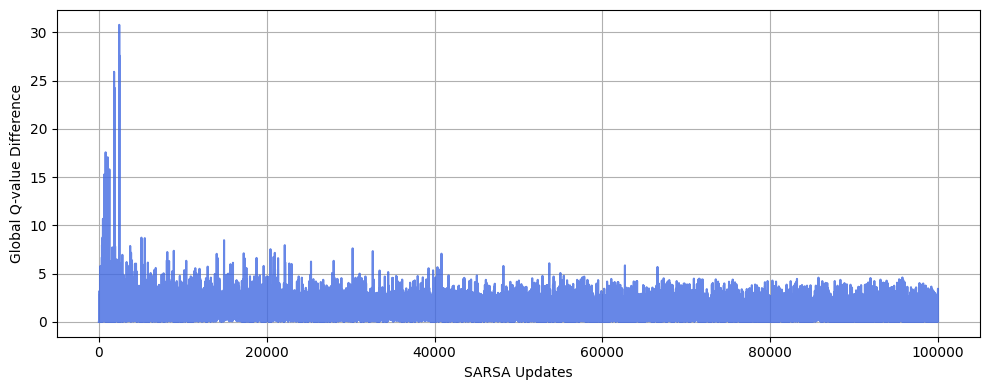

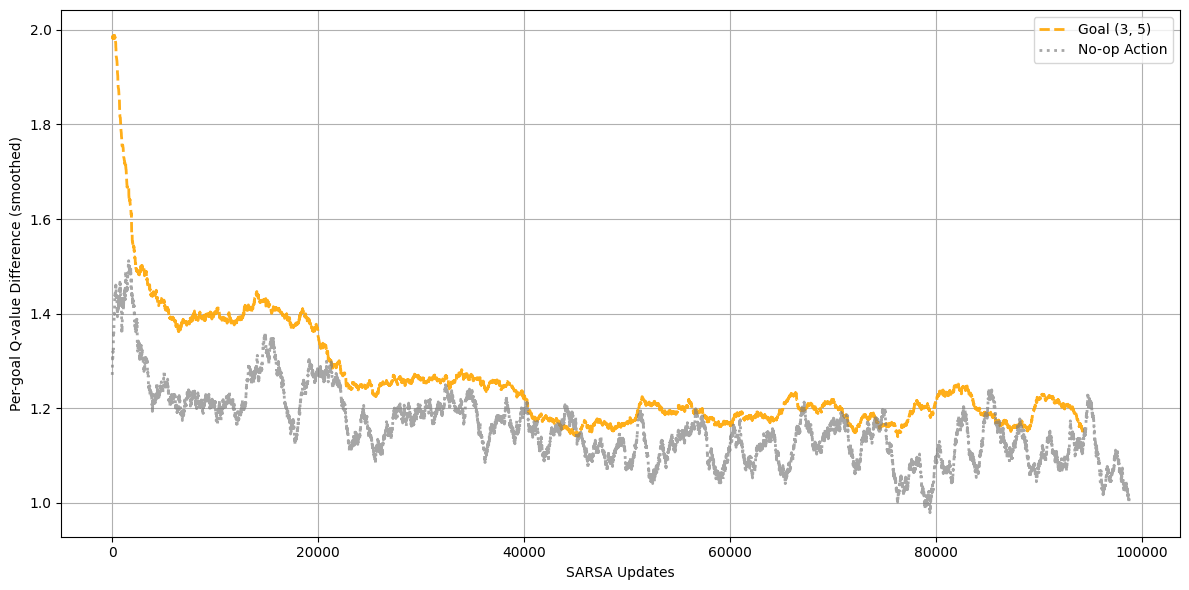

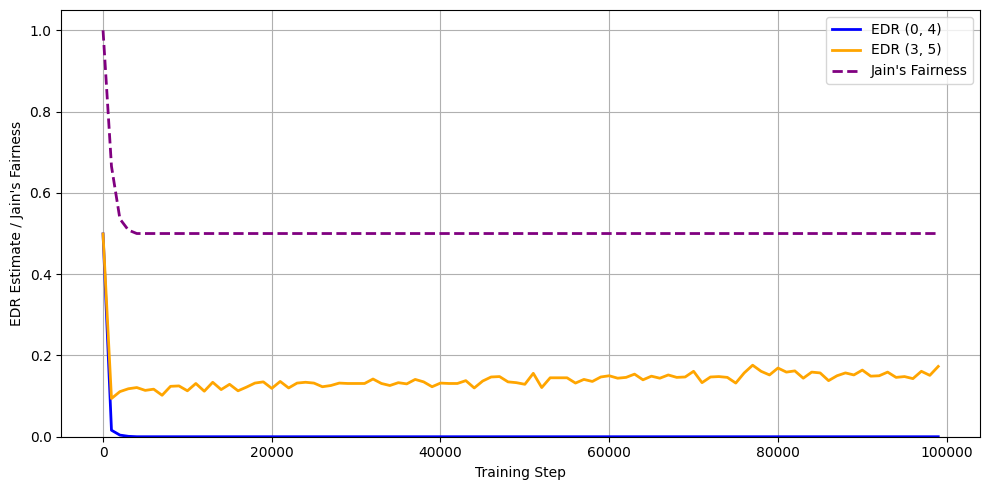

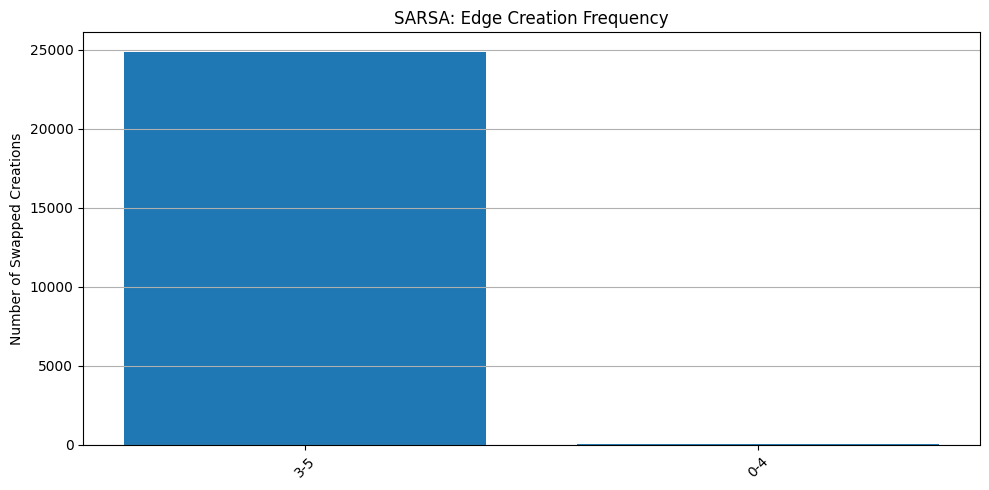

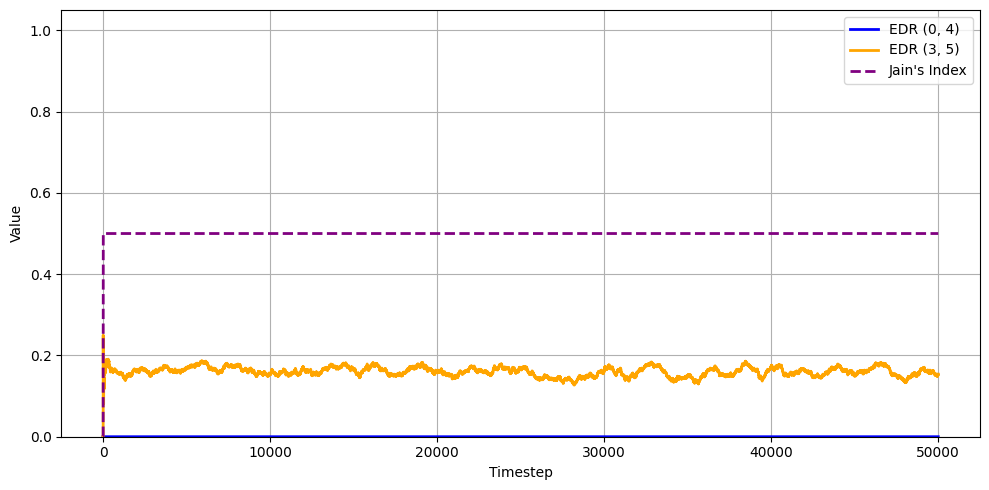

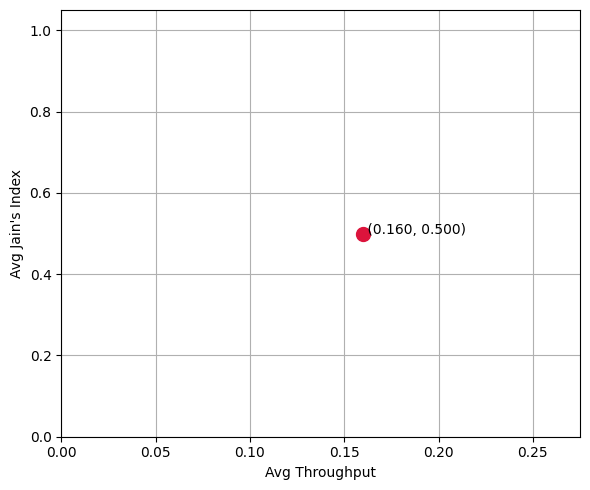

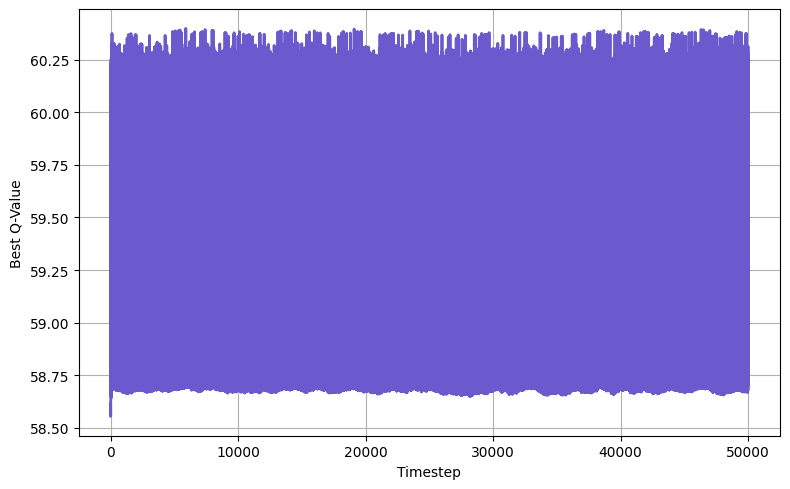


Metrics After Burn-in (first 5000 steps ignored):
Mean EDRs: {(0, 4): '0.0000', (3, 5): '0.1599'}
Total Throughput (sum of EDRs): 0.1599
Jain's Fairness Index: 0.5000
Waited when could have acted: 2310/11209 = 0.2061


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random

# === Fixed parameters ===
edges = [(0,1), (1,2), (2,3), (3,4), (2,5)]
goal_edges = [(0,4), (3,5)]
pSwap = 0.9
pGen = 0.3
maxAge = 3
nLookahead = 5
alpha = 0.005
gamma = 0.995
windowSize = 1000
reward_mode = 'basic'
temperature = 6.0
final_temperature = 0.1
nestedSwaps = False
seed = 30
burn_in = 5000
simulate_steps = 50_000
totalSteps = 100_000  # Single run

# Compute correct temperature decay
def compute_temp_decay(final_temp, init_temp, total_steps):
    return (final_temp / init_temp) ** (1.0 / (total_steps * 1.2))

# Set seeds
random.seed(seed)
np.random.seed(seed)

print(f"\n=== Training SARSA with totalSteps = {totalSteps} ===")

# Compute temperature decay
temperature_decay = compute_temp_decay(final_temperature, temperature, totalSteps)

# --- Train SARSA ---
Q = train_sarsa_linear_policy(
    edges=edges,
    goal_edges=goal_edges,
    pSwap=pSwap,
    pGen=pGen,
    max_age=maxAge,
    seed=seed,
    totalSteps=totalSteps,
    nLookahead=nLookahead,
    alpha=alpha,
    gamma=gamma,
    edr_window_size=windowSize,
    reward_mode=reward_mode,
    log_interval=windowSize,
    temperature=temperature,
    temperature_decay=temperature_decay,
    nestedSwaps=nestedSwaps,
    noop_penalty=0.0,
    plotTraining=True,
    rewardAlpha=0.5,
)

# --- Simulate the trained policy ---
simulation_results = simulate_policy(
    Q_table=Q,
    edges=edges,
    goal_edges=goal_edges,
    pSwap=pSwap,
    pGen=pGen,
    max_age=maxAge,
    num_steps=simulate_steps,
    edr_window_size=windowSize,
    burn_in=burn_in,
    plot=True,
    nestedSwaps=nestedSwaps
)



=== Training SARSA with totalSteps = 1000000 ===
Step 100000
Step 200000
Step 300000
Step 400000
Step 500000
Step 600000
Step 700000
Step 800000
Step 900000
Step 1000000
Step 1000000: alpha = 0.000250

Metrics After Burn-in (first 5000 steps ignored):
Mean EDRs: {(0, 4): '0.0218', (3, 5): '0.2638'}
Total Throughput (sum of EDRs): 0.2856
Jain's Fairness Index: 0.5821
Waited when could have acted: 0/27019 = 0.0000


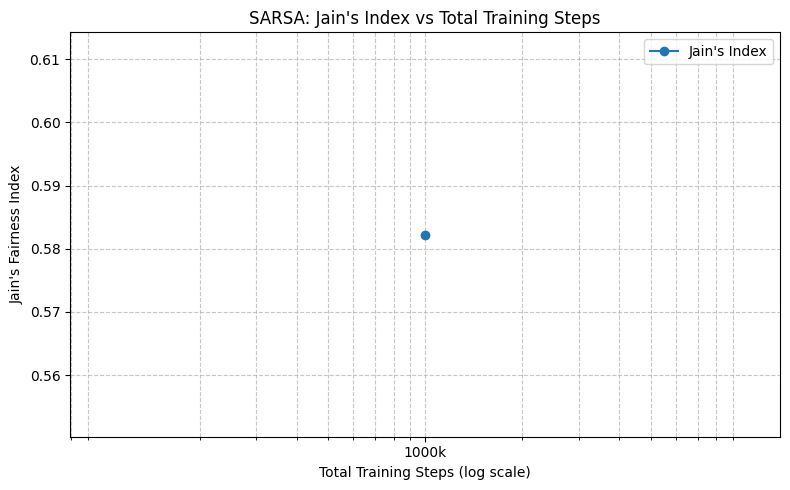

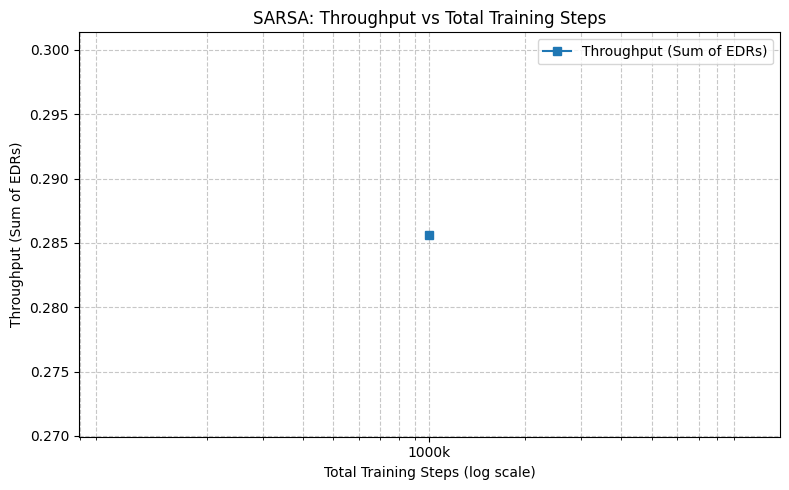


=== Final Results ===
Steps: 1,000,000 => Jain: 0.5823, Throughput: 0.2856


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random

# === Fixed parameters ===
edges = [(0,1), (1,2), (2,3), (3,4), (2,5)]
goal_edges = [(0,4), (3,5)]
pSwap = 0.6
pGen = 0.6
maxAge = 3
nLookahead = 5
alpha = 0.005
gamma = 0.995
windowSize = 1000
reward_mode = 'basic'
temperature = 6.0
final_temperature = 0.1
nestedSwaps = False
seed = 30
burn_in = 5000
simulate_steps = 50_000

# Compute decay for each training size
def compute_temp_decay(final_temp, init_temp, total_steps):
    return (final_temp / init_temp) ** (1.0 / (total_steps * 1.2))

# === Training step sizes to try ===
training_steps_list = [1_000_000]

# === Storage for results ===
jain_scores = []
throughput_scores = []

# === Loop over different totalSteps ===
for totalSteps in training_steps_list:
    print(f"\n=== Training SARSA with totalSteps = {totalSteps} ===")
    
    # Set random seeds for reproducibility
    random.seed(seed)
    np.random.seed(seed)

    # Compute correct temperature decay
    temperature_decay = compute_temp_decay(final_temperature, temperature, totalSteps)

    # Train SARSA
    Q = train_sarsa_linear_policy(
        edges=edges,
        goal_edges=goal_edges,
        pSwap=pSwap,
        pGen=pGen,
        max_age=maxAge,
        seed=seed,
        totalSteps=totalSteps,
        nLookahead=nLookahead,
        alpha=alpha,
        gamma=gamma,
        edr_window_size=windowSize,
        reward_mode=reward_mode,
        log_interval=windowSize,
        temperature=temperature,
        temperature_decay=temperature_decay,
        nestedSwaps=nestedSwaps,
        noop_penalty=0.0,
        plotTraining=False,
        rewardAlpha=0.5,
    )

    # Simulate the trained policy
    simulation_results = simulate_policy(
        Q_table=Q,
        edges=edges,
        goal_edges=goal_edges,
        pSwap=pSwap,
        pGen=pGen,
        max_age=maxAge,
        num_steps=simulate_steps,
        edr_window_size=windowSize,
        burn_in=burn_in,
        plot=False,
        nestedSwaps=nestedSwaps
    )

    # Extract final metrics
    final_jain = np.mean(simulation_results['jain_history'][burn_in:])
    final_tp = np.mean(simulation_results['throughput_history'][burn_in:])

    jain_scores.append(final_jain)
    throughput_scores.append(final_tp)

# === Plot results ===

# (1) Jain's Index vs Training Steps
plt.figure(figsize=(8,5))
plt.plot(training_steps_list, jain_scores, marker='o', linestyle='-', label="Jain's Index")
plt.xscale('log')
plt.xlabel("Total Training Steps (log scale)")
plt.ylabel("Jain's Fairness Index")
plt.title("SARSA: Jain's Index vs Total Training Steps")
plt.grid(True, which='both', linestyle='--', alpha=0.7)
plt.xticks(training_steps_list, labels=[f"{v//1000}k" for v in training_steps_list])
plt.legend()
plt.tight_layout()
plt.show()

# (2) Throughput vs Training Steps
plt.figure(figsize=(8,5))
plt.plot(training_steps_list, throughput_scores, marker='s', linestyle='-', label="Throughput (Sum of EDRs)")
plt.xscale('log')
plt.xlabel("Total Training Steps (log scale)")
plt.ylabel("Throughput (Sum of EDRs)")
plt.title("SARSA: Throughput vs Total Training Steps")
plt.grid(True, which='both', linestyle='--', alpha=0.7)
plt.xticks(training_steps_list, labels=[f"{v//1000}k" for v in training_steps_list])
plt.legend()
plt.tight_layout()
plt.show()

# === Also print the final results nicely ===
print("\n=== Final Results ===")
for steps, jain, tp in zip(training_steps_list, jain_scores, throughput_scores):
    print(f"Steps: {steps:,} => Jain: {jain:.4f}, Throughput: {tp:.4f}")



=== Training for maxAge=1 ===
Step 100000
Step 200000
Step 300000
Step 400000
Step 500000

Metrics After Burn-in (first 5000 steps ignored):
Mean EDRs: {(0, 4): '0.0109', (3, 5): '0.2137'}
Total Throughput (sum of EDRs): 0.2247
Jain's Fairness Index: 0.5510
Waited when could have acted: 0/20325 = 0.0000

Metrics After Burn-in (first 5000 steps ignored):
Mean EDRs: {(0, 4): '0.0287', (3, 5): '0.1715'}
Total Throughput (sum of EDRs): 0.2002
Jain's Fairness Index: 0.6625
Waited when could have acted: 0/20544 = 0.0000

=== Training for maxAge=2 ===
Step 100000
Step 200000
Step 300000
Step 400000
Step 500000

Metrics After Burn-in (first 5000 steps ignored):
Mean EDRs: {(0, 4): '0.0186', (3, 5): '0.2540'}
Total Throughput (sum of EDRs): 0.2726
Jain's Fairness Index: 0.5730
Waited when could have acted: 0/25564 = 0.0000

Metrics After Burn-in (first 5000 steps ignored):
Mean EDRs: {(0, 4): '0.0247', (3, 5): '0.2402'}
Total Throughput (sum of EDRs): 0.2648
Jain's Fairness Index: 0.6017
Waite

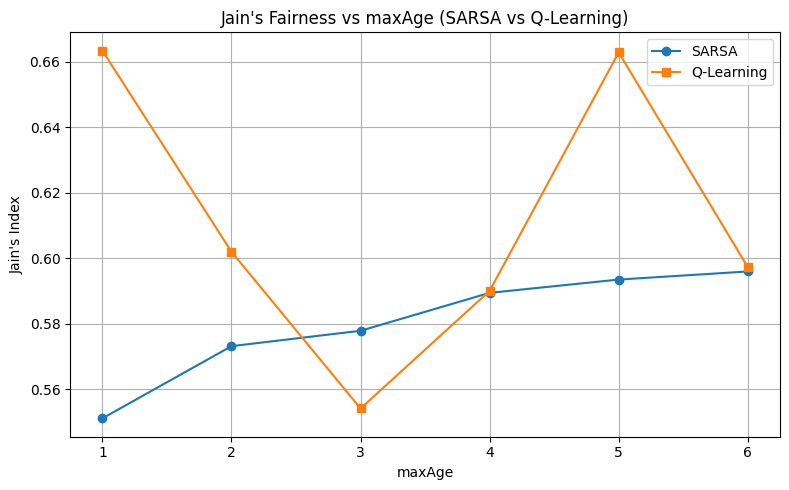

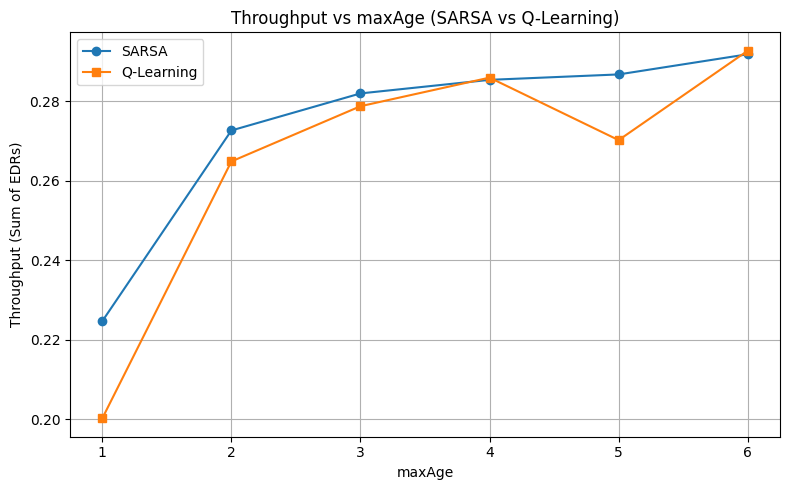

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random

# Fixed parameters
edges = [(0,1), (1,2), (2,3), (3,4), (2,5)]
goal_edges = [(0,4), (3,5)]
pSwap = 0.6
pGen = 0.6

seed = 30
random.seed(seed)
np.random.seed(seed)

totalSteps = 1_000_000
nLookahead = 5
alpha = 0.005
gamma = 0.995
windowSize = 1000
reward_mode = 'basic'
temperature = 6.0
final_temperature = 0.1
temperature_decay = (final_temperature / temperature) ** (1.0 / (totalSteps * 1.2))
nestedSwaps = False



# Sweep values
maxAge_values = [1, 2, 3, 4, 5, 6]
simulate_steps = 50_000
burn_in_steps = 5000

# Set seeds
random.seed(seed)
np.random.seed(seed)

# -------------------------------
# Now run both SARSA and Q-Learning sweep
# -------------------------------

results = run_sarsa_qlearning_over_maxage(
    edges=edges,
    goal_edges=goal_edges,
    pSwap=pSwap,
    pGen=pGen,
    seed=seed,
    totalSteps=totalSteps,
    alpha=alpha,
    gamma=gamma,
    windowSize=windowSize,
    reward_mode=reward_mode,
    temperature=temperature,
    temperature_decay=temperature_decay,
    nestedSwaps=nestedSwaps,
    maxAge_values=maxAge_values,
    simulate_steps=simulate_steps,
    burn_in_steps=burn_in_steps
)



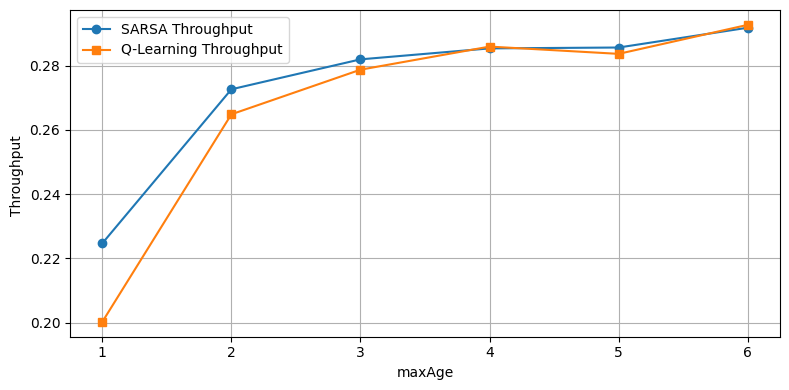

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# === Updated Corrected Results ===
updated_results = {
    'maxAge_values': [1, 2, 3, 4, 5, 6],
    'sarsa_jain': [
        0.5511252349963784,
        0.5731671957291401,
        0.5778690554932743,
        0.5894485077385416,
        0.5961433396251156,  # << Updated
        0.5959768808341853
    ],
    'sarsa_throughput': [
        0.22465582448545163,
        0.27263062827396856,
        0.28195329535937896,
        0.2853684133463278,
        0.2856397411583364,  # << Updated
        0.2918039915694813
    ],
    'qlearn_jain': [
        0.6633945726361116,
        0.6019832680527356,
        0.5541360315029189,
        0.5900578627966049,
        0.5936352563077143,  # << Updated
        0.5973222989029048
    ],
    'qlearn_throughput': [
        0.2002022626611015,
        0.2648402721135618,
        0.2787346111384299,
        0.2859283996804062,
        0.28366489479606616,  # << Updated
        0.2926986277487099
    ]
}

# === Plotting ===

# Unpack for easier access
maxAge_values = updated_results['maxAge_values']
sarsa_jain = updated_results['sarsa_jain']
qlearn_jain = updated_results['qlearn_jain']
sarsa_throughput = updated_results['sarsa_throughput']
qlearn_throughput = updated_results['qlearn_throughput']


# --- Plot Throughput ---
plt.figure(figsize=(8, 4))
plt.plot(maxAge_values, sarsa_throughput, marker='o', linestyle='-', label="SARSA Throughput")
plt.plot(maxAge_values, qlearn_throughput, marker='s', linestyle='-', label="Q-Learning Throughput")
plt.xlabel("maxAge")
plt.ylabel("Throughput ")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# === Updated Corrected Results with Greedy added ===
updated_results = {
    'maxAge_values': [1, 2, 3, 4, 5, 6],
    'sarsa_jain': [
        0.5511252349963784,
        0.5731671957291401,
        0.5778690554932743,
        0.5894485077385416,
        0.5961433396251156,
        0.5959768808341853
    ],
    'sarsa_throughput': [
        0.22465582448545163,
        0.27263062827396856,
        0.28195329535937896,
        0.2853684133463278,
        0.2856397411583364,
        0.2918039915694813
    ],
    'qlearn_jain': [
        0.6633945726361116,
        0.6019832680527356,
        0.5541360315029189,
        0.5900578627966049,
        0.5936352563077143,
        0.5973222989029048
    ],
    'qlearn_throughput': [
        0.2002022626611015,
        0.2648402721135618,
        0.2787346111384299,
        0.2859283996804062,
        0.28366489479606616,
        0.2926986277487099
    ],
    'greedy_jain': [
        0.6655063114610119,
        0.7784523425676729,
        0.8171546281955429,
        0.818798276208865,
        0.8182058832044875,
        0.8183561555168837
    ],
    'greedy_throughput': [
        0.19612000000000002,
        0.21924,
        0.22248,
        0.2269,
        0.23434,
        0.2331
    ]
}

# === Unpack ===
maxAge_values = updated_results['maxAge_values']
sarsa_throughput = updated_results['sarsa_throughput']
qlearn_throughput = updated_results['qlearn_throughput']
greedy_throughput = updated_results['greedy_throughput']

# === Plot Throughput (only) ===
plt.figure(figsize=(9, 5))

# SARSA
plt.plot(maxAge_values, sarsa_throughput, marker='o', linestyle='-', color='blue', label="SARSA")

# Q-Learning
plt.plot(maxAge_values, qlearn_throughput, marker='o', linestyle='-', color='orange', label="Q-Learning")

# Greedy
plt.plot(maxAge_values, greedy_throughput, marker='o', linestyle='-', color='green', label="Greedy")

plt.xlabel("maxAge")
plt.ylabel("Throughput (Sum of EDRs)")
plt.title("Throughput vs maxAge (SARSA vs Q-Learning vs Greedy)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



=== Running for pSwap=0.2, pGen=0.2 ===

Metrics After Burn-in (first 5000 steps ignored):
Mean EDRs: {(0, 4): '0.0000', (3, 5): '0.0203'}
Total Throughput (sum of EDRs): 0.0203
Jain's Fairness Index: 0.5000
Waited when could have acted: 786/4873 = 0.1613

=== Running for pSwap=0.4, pGen=0.2 ===

Metrics After Burn-in (first 5000 steps ignored):
Mean EDRs: {(0, 4): '0.0010', (3, 5): '0.0402'}
Total Throughput (sum of EDRs): 0.0412
Jain's Fairness Index: 0.5251
Waited when could have acted: 0/4552 = 0.0000

=== Running for pSwap=0.6, pGen=0.2 ===

Metrics After Burn-in (first 5000 steps ignored):
Mean EDRs: {(0, 4): '0.0037', (3, 5): '0.0584'}
Total Throughput (sum of EDRs): 0.0622
Jain's Fairness Index: 0.5639
Waited when could have acted: 0/4516 = 0.0000

=== Running for pSwap=0.8, pGen=0.2 ===

Metrics After Burn-in (first 5000 steps ignored):
Mean EDRs: {(0, 4): '0.0108', (3, 5): '0.0727'}
Total Throughput (sum of EDRs): 0.0835
Jain's Fairness Index: 0.6448
Waited when could have a

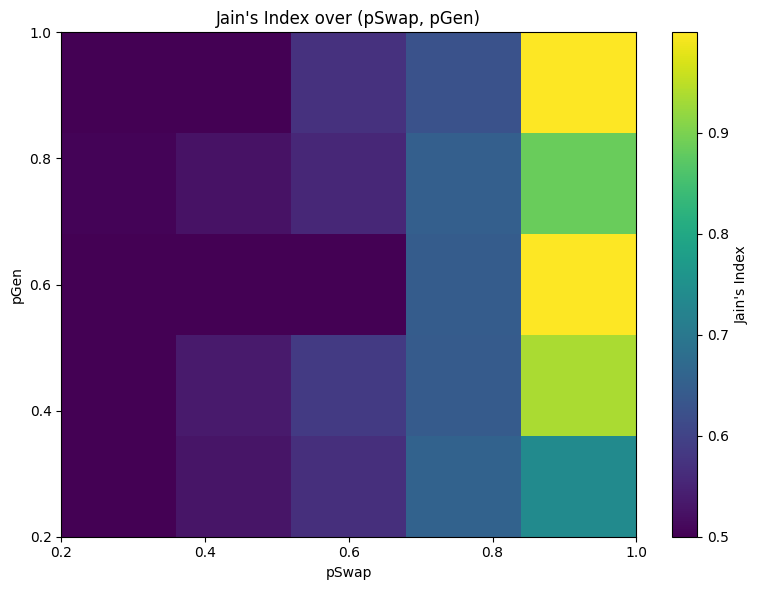

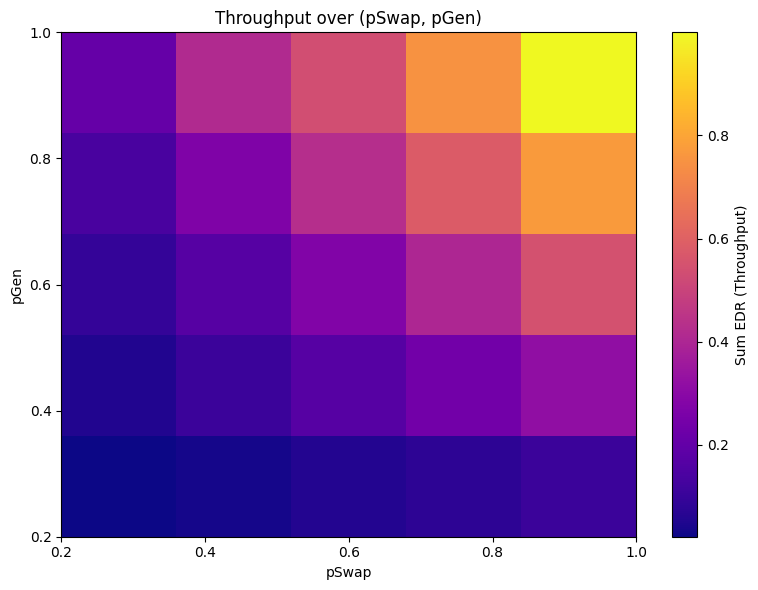

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random

# Set up parameters
seed = 30
random.seed(seed)
np.random.seed(seed)

edges = [(0,1), (1,2), (2,3), (3,4), (2,5)]
goal_edges = [(0,4), (3,5)]

pSwap = 0.6
pGen = 0.6
maxAge = 3
totalSteps = 1_000_000

gamma = 0.995
alpha = 0.005  # <-- Don't forget to define alpha if not already
windowSize = 1000
reward_mode = 'basic' 
temperature = 6.0
final_temperature = 0.1
temperature_decay = (final_temperature / temperature) ** (1.0 / (totalSteps * 1.2))
nestedSwaps = False

# --- Define your sweeps ---
pSwap_values = [0.2, 0.4, 0.6, 0.8, 1.0]
pGen_values = [0.2, 0.4, 0.6, 0.8, 1.0]

# Prepare matrices
jain_matrix = np.zeros((len(pGen_values), len(pSwap_values)))
edr_matrix = np.zeros((len(pGen_values), len(pSwap_values)))

# --- Loop over (pGen, pSwap) grid ---
for i, pGen_val in enumerate(pGen_values):
    for j, pSwap_val in enumerate(pSwap_values):
        print(f"\n=== Running for pSwap={pSwap_val}, pGen={pGen_val} ===")
        
        # --- Train the agent
        Q_model = train_q_learning_linear_policy(
            edges=edges,
            goal_edges=goal_edges,
            pSwap=pSwap_val,
            pGen=pGen_val,
            max_age=maxAge,
            seed=seed,
            totalSteps=totalSteps,
            alpha=alpha,
            gamma=gamma,
            edr_window_size=windowSize,
            reward_mode=reward_mode,
            softmax=True,
            temperature=temperature,
            temperature_decay=temperature_decay,
            nestedSwaps=nestedSwaps,
            plotTraining=False
        )

        # --- Simulate policy (after training)
        result = simulate_policy(
            Q_model,
            edges=edges,
            goal_edges=goal_edges,
            pSwap=pSwap_val,
            pGen=pGen_val,
            max_age=maxAge,
            num_steps=40_000,
            edr_window_size=windowSize,
            plot=False,  # <--- Turn off plotting to make sweep faster
            nestedSwaps=nestedSwaps
        )

        # --- Extract Jain and Throughput (Sum EDRs)
        edr_histories = result["edr_history"]
        final_edrs = {g: np.mean(edr_histories[g][-5000:]) for g in goal_edges}
        fairness = jains_index(final_edrs)
        throughput = sum(final_edrs.values())

        jain_matrix[i, j] = fairness
        edr_matrix[i, j] = throughput

# --- Now plot heatmaps ---

# (1) Jain's Index Heatmap
plt.figure(figsize=(8,6))
plt.imshow(jain_matrix, origin='lower', cmap='viridis',
           extent=[min(pSwap_values), max(pSwap_values), min(pGen_values), max(pGen_values)],
           aspect='auto')
plt.colorbar(label="Jain's Index")
plt.xlabel('pSwap')
plt.ylabel('pGen')
plt.title("Jain's Index over (pSwap, pGen)")
plt.xticks(pSwap_values)
plt.yticks(pGen_values)
plt.grid(False)
plt.tight_layout()
plt.show()

# (2) EDR Sum (Throughput) Heatmap
plt.figure(figsize=(8,6))
plt.imshow(edr_matrix, origin='lower', cmap='plasma',
           extent=[min(pSwap_values), max(pSwap_values), min(pGen_values), max(pGen_values)],
           aspect='auto')
plt.colorbar(label="Sum EDR (Throughput)")
plt.xlabel('pSwap')
plt.ylabel('pGen')
plt.title("Throughput over (pSwap, pGen)")
plt.xticks(pSwap_values)
plt.yticks(pGen_values)
plt.grid(False)
plt.tight_layout()
plt.show()


In [ ]:
print(jain_matrix)
print(edr_matrix)

[[0.5        0.5281832  0.56688655 0.65664541 0.73837336]
 [0.5        0.5358237  0.58503671 0.64294107 0.93545963]
 [0.5        0.5        0.5        0.64510312 0.99889798]
 [0.50443058 0.52342995 0.55574278 0.6503786  0.8842256 ]
 [0.5        0.5        0.57110471 0.62656899 0.99916059]]
[[0.0221372  0.03715113 0.05686215 0.07881783 0.10633009]
 [0.0527652  0.10877192 0.16984705 0.23922145 0.31978126]
 [0.0919334  0.1701     0.2753194  0.40062305 0.54778923]
 [0.13981655 0.27224971 0.42779234 0.5814286  0.77383925]
 [0.2069652  0.411963   0.53696571 0.74970215 0.99998688]]



=== Running for pSwap=0.2, pGen=0.2 ===

=== Training with pSwap = 0.2 ===
Step 100000
Step 200000
Step 300000
Step 400000
Step 500000
Step 600000
Step 700000
Step 800000
Step 900000
Step 1000000
Step 1000000: alpha = 0.000250

Metrics After Burn-in (first 5000 steps ignored):
Mean EDRs: {(0, 4): '0.0000', (3, 5): '0.0207'}
Total Throughput (sum of EDRs): 0.0207
Jain's Fairness Index: 0.5000
Waited when could have acted: 810/4863 = 0.1666


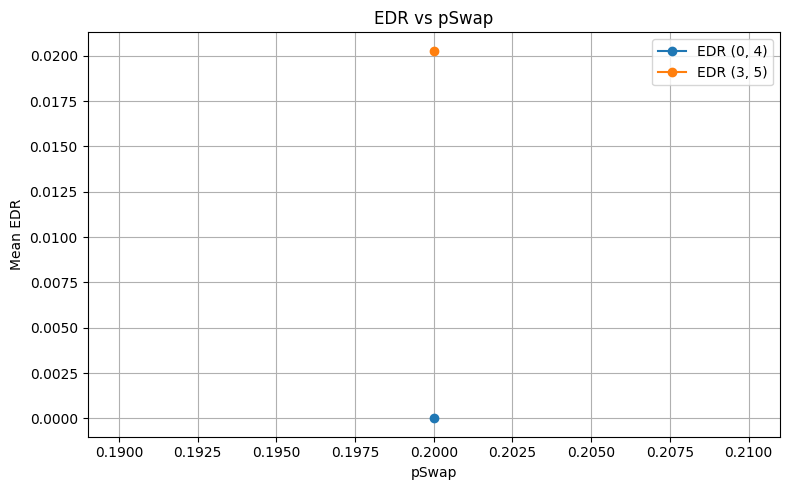

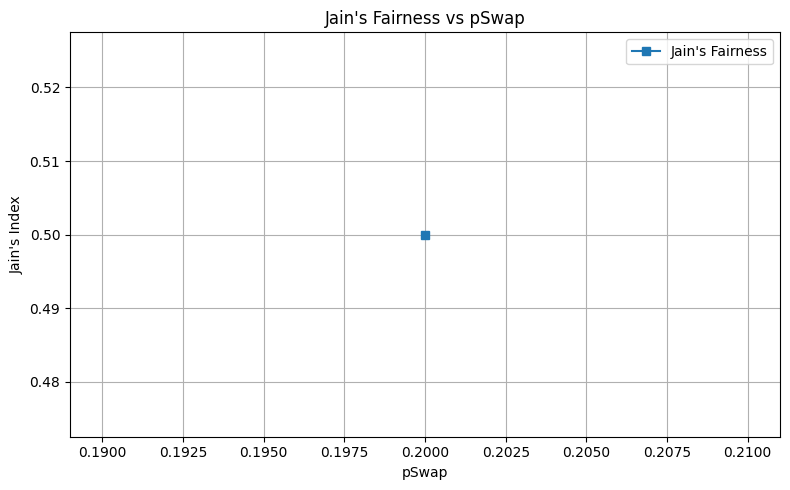

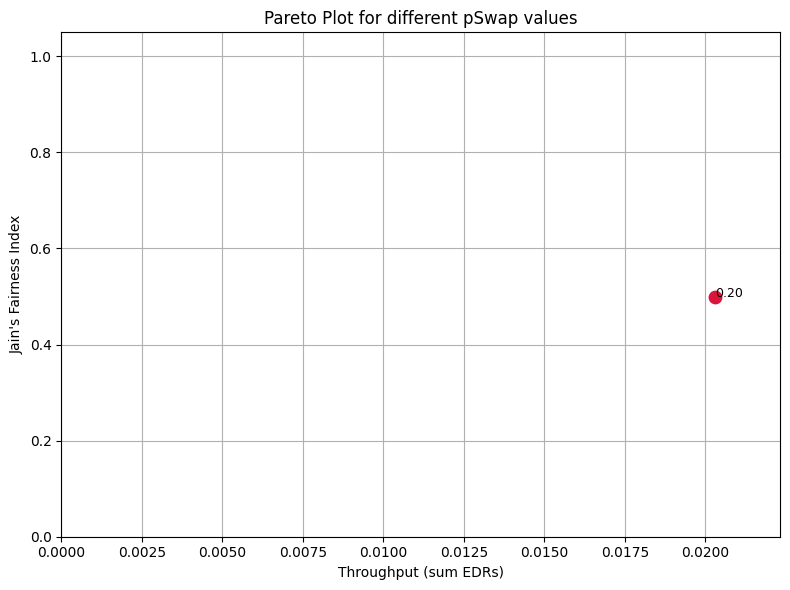


=== Running for pSwap=0.4, pGen=0.2 ===

=== Training with pSwap = 0.4 ===
Step 100000
Step 200000
Step 300000
Step 400000
Step 500000
Step 600000
Step 700000
Step 800000
Step 900000
Step 1000000
Step 1000000: alpha = 0.000250

Metrics After Burn-in (first 5000 steps ignored):
Mean EDRs: {(0, 4): '0.0011', (3, 5): '0.0398'}
Total Throughput (sum of EDRs): 0.0408
Jain's Fairness Index: 0.5265
Waited when could have acted: 0/4523 = 0.0000


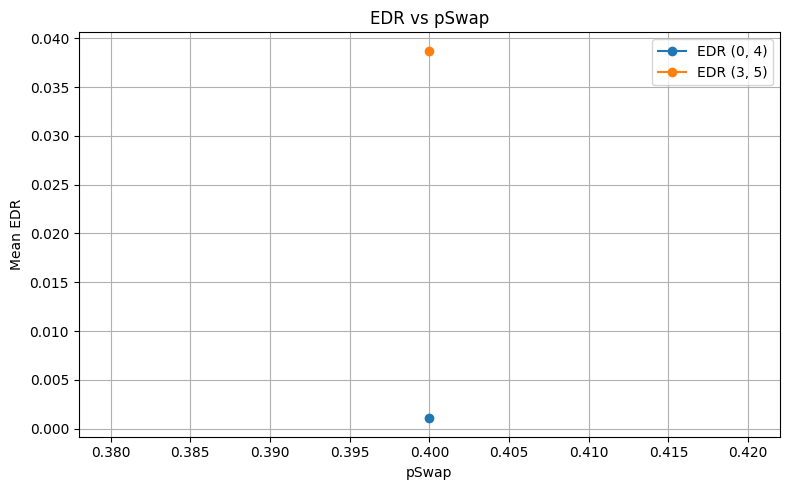

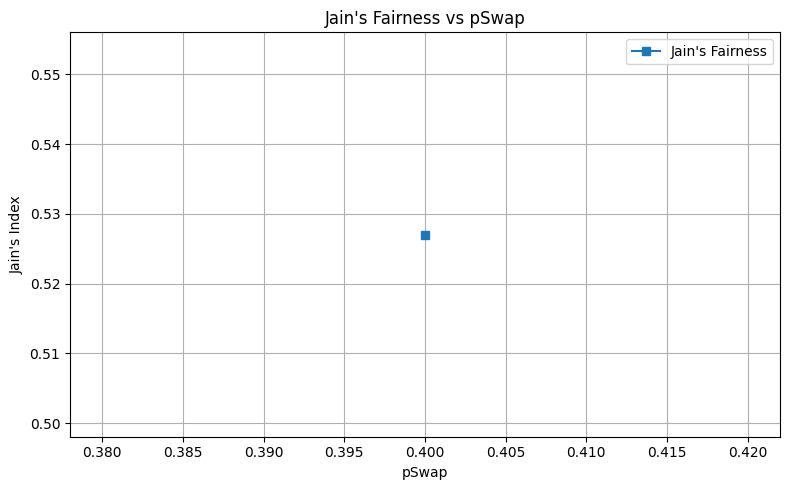

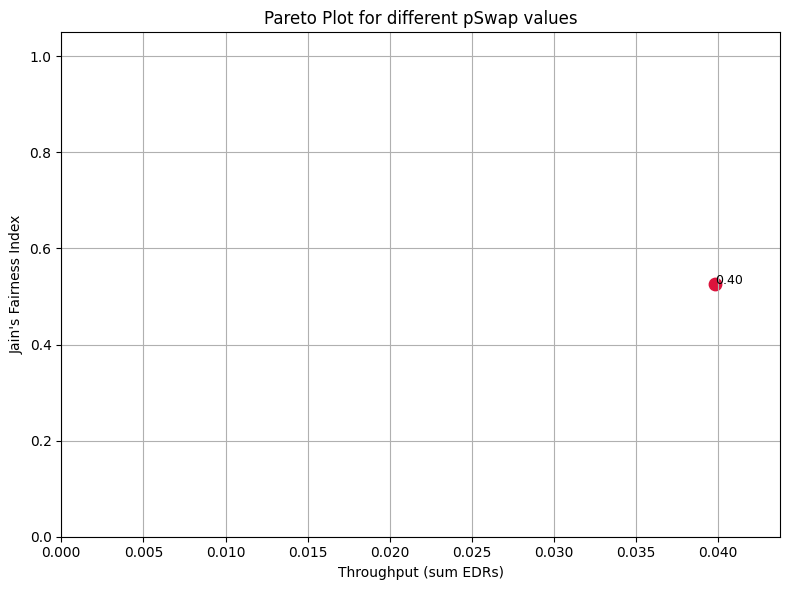


=== Running for pSwap=0.6, pGen=0.2 ===

=== Training with pSwap = 0.6 ===
Step 100000
Step 200000
Step 300000
Step 400000
Step 500000
Step 600000
Step 700000
Step 800000
Step 900000
Step 1000000
Step 1000000: alpha = 0.000250

Metrics After Burn-in (first 5000 steps ignored):
Mean EDRs: {(0, 4): '0.0036', (3, 5): '0.0575'}
Total Throughput (sum of EDRs): 0.0611
Jain's Fairness Index: 0.5621
Waited when could have acted: 0/4507 = 0.0000


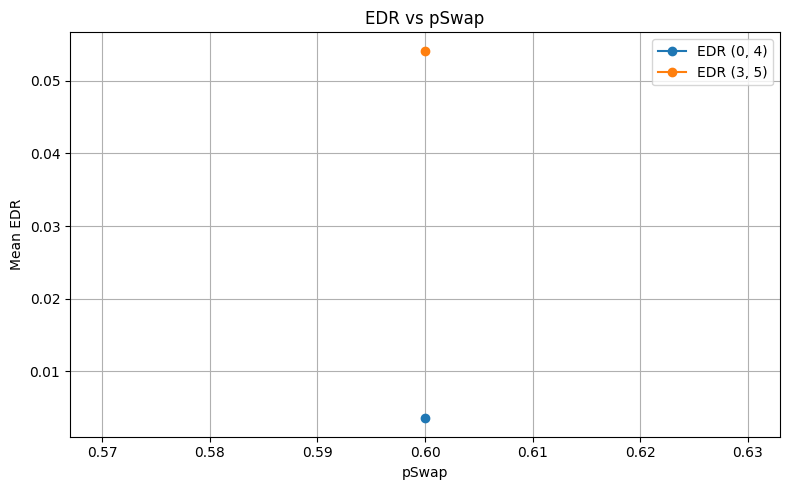

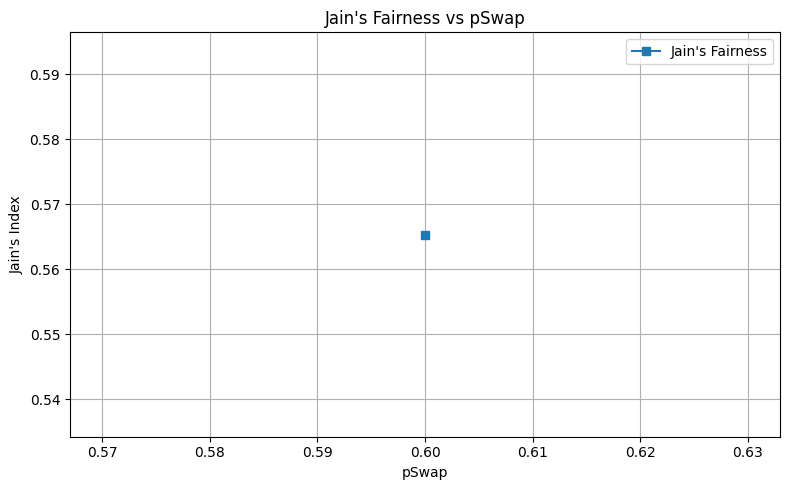

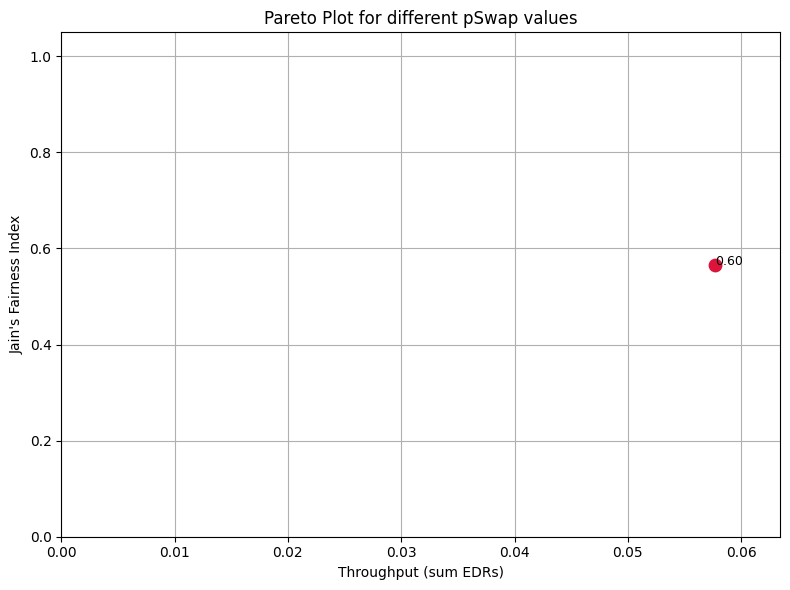


=== Running for pSwap=0.8, pGen=0.2 ===

=== Training with pSwap = 0.8 ===
Step 100000
Step 200000
Step 300000
Step 400000
Step 500000
Step 600000
Step 700000
Step 800000
Step 900000
Step 1000000
Step 1000000: alpha = 0.000250

Metrics After Burn-in (first 5000 steps ignored):
Mean EDRs: {(0, 4): '0.0104', (3, 5): '0.0716'}
Total Throughput (sum of EDRs): 0.0820
Jain's Fairness Index: 0.6420
Waited when could have acted: 0/4450 = 0.0000


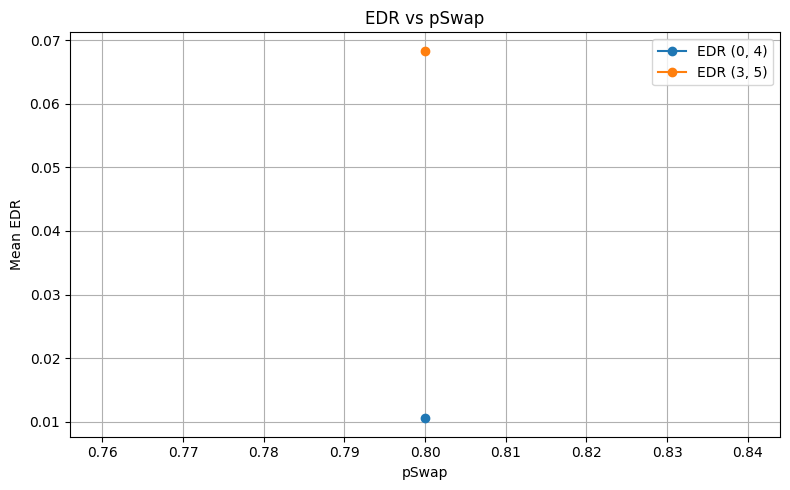

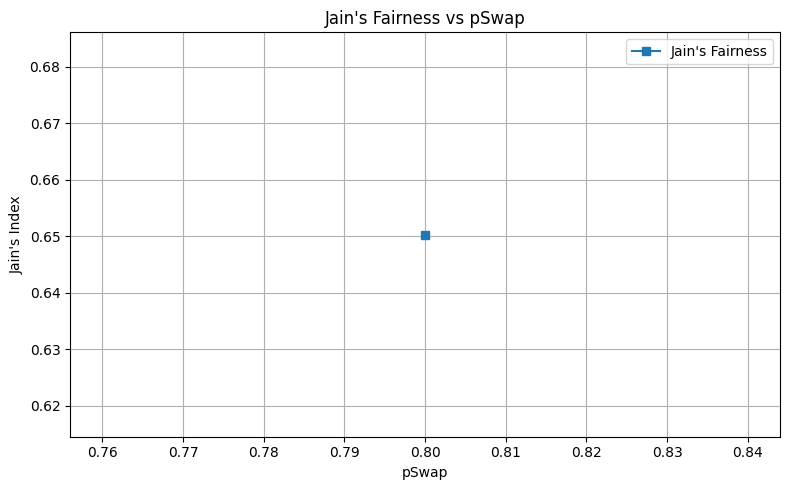

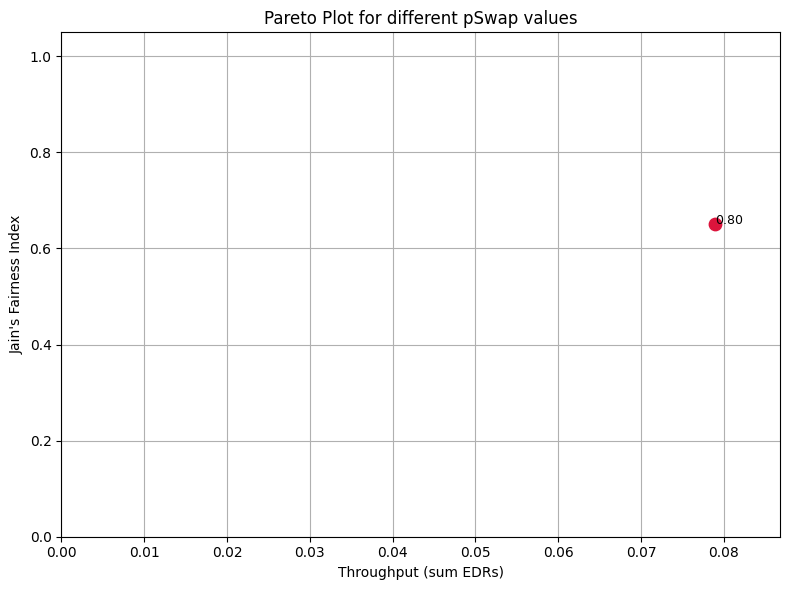


=== Running for pSwap=1, pGen=0.2 ===

=== Training with pSwap = 1 ===
Step 100000
Step 200000
Step 300000
Step 400000
Step 500000
Step 600000
Step 700000
Step 800000
Step 900000
Step 1000000
Step 1000000: alpha = 0.000250

Metrics After Burn-in (first 5000 steps ignored):
Mean EDRs: {(0, 4): '0.0000', (3, 5): '0.1002'}
Total Throughput (sum of EDRs): 0.1002
Jain's Fairness Index: 0.5000
Waited when could have acted: 824/4845 = 0.1701


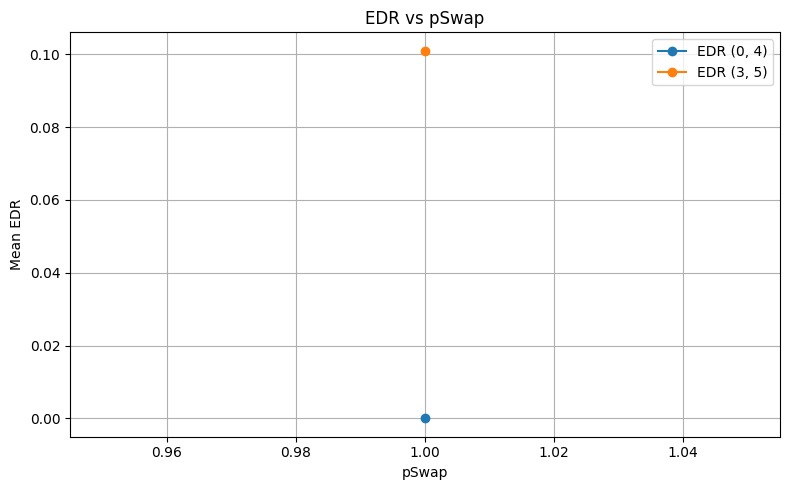

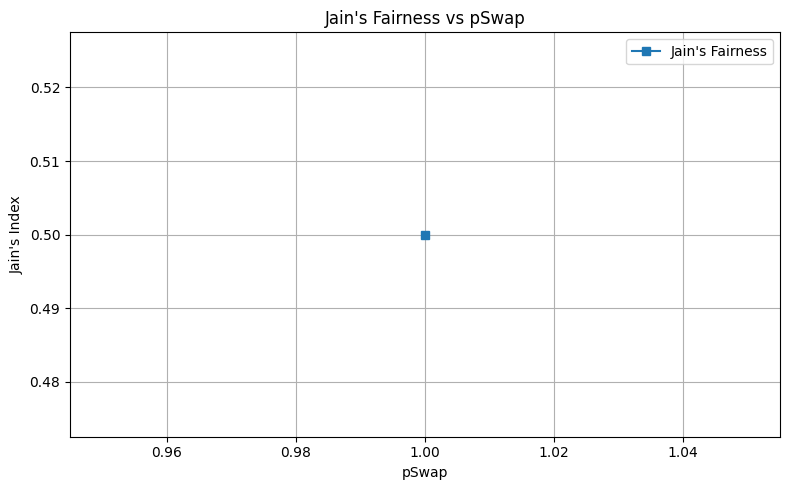

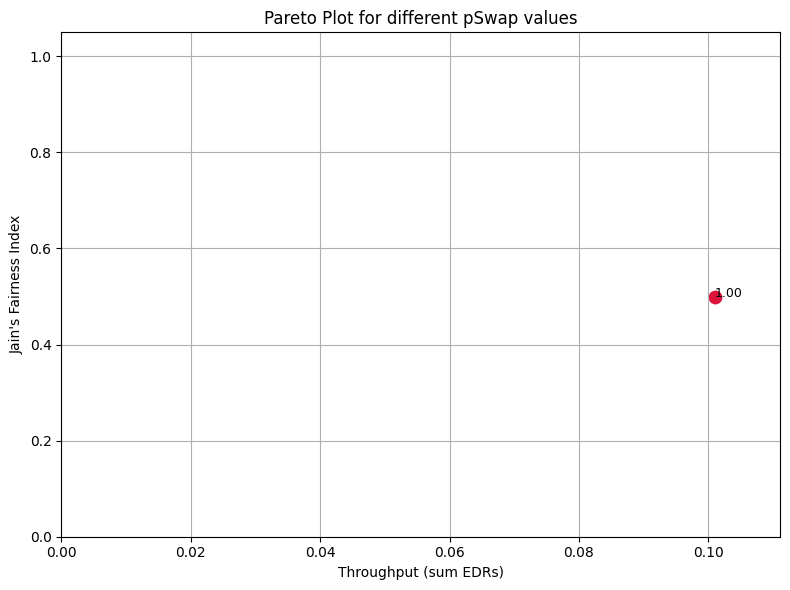


=== Running for pSwap=0.2, pGen=0.4 ===

=== Training with pSwap = 0.2 ===
Step 100000
Step 200000
Step 300000
Step 400000
Step 500000
Step 600000
Step 700000
Step 800000
Step 900000
Step 1000000
Step 1000000: alpha = 0.000250

Metrics After Burn-in (first 5000 steps ignored):
Mean EDRs: {(0, 4): '0.0004', (3, 5): '0.0506'}
Total Throughput (sum of EDRs): 0.0510
Jain's Fairness Index: 0.5074
Waited when could have acted: 1668/13427 = 0.1242


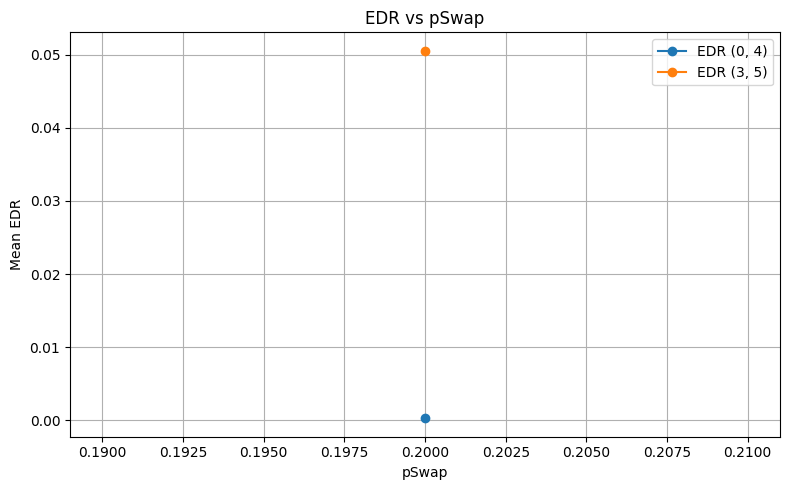

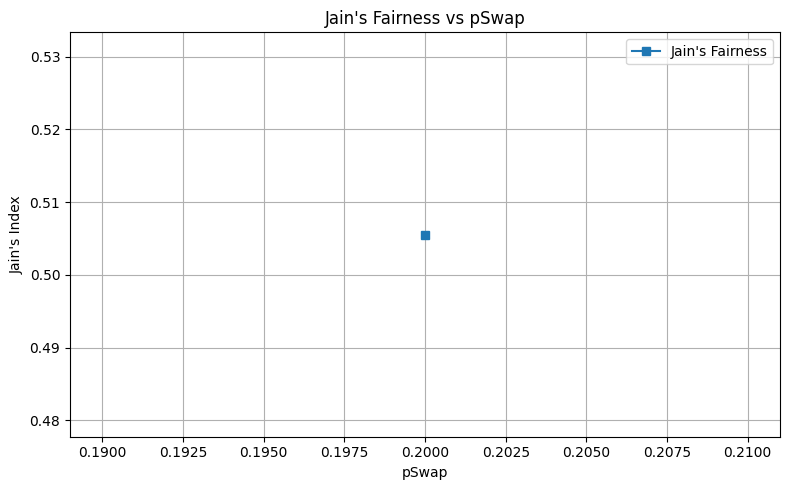

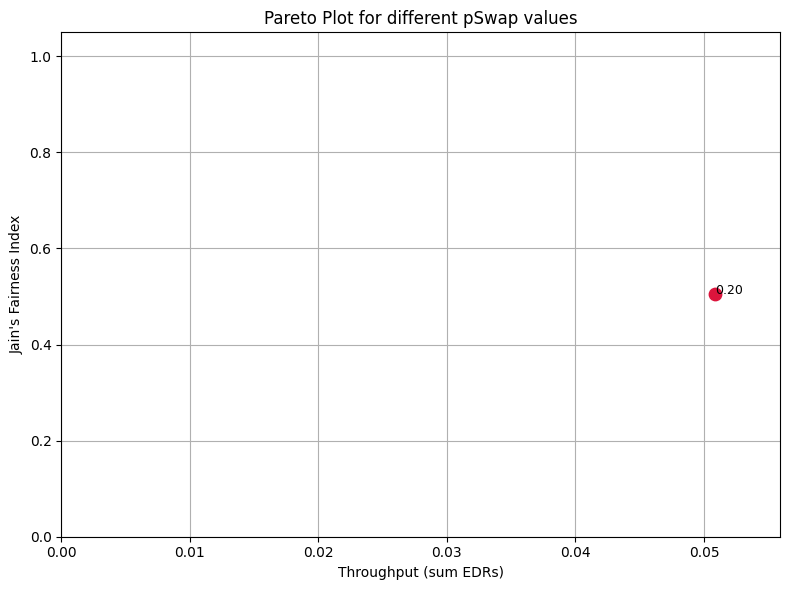


=== Running for pSwap=0.4, pGen=0.4 ===

=== Training with pSwap = 0.4 ===
Step 100000
Step 200000
Step 300000
Step 400000
Step 500000
Step 600000
Step 700000
Step 800000
Step 900000
Step 1000000
Step 1000000: alpha = 0.000250

Metrics After Burn-in (first 5000 steps ignored):
Mean EDRs: {(0, 4): '0.0012', (3, 5): '0.1053'}
Total Throughput (sum of EDRs): 0.1065
Jain's Fairness Index: 0.5117
Waited when could have acted: 1992/13517 = 0.1474


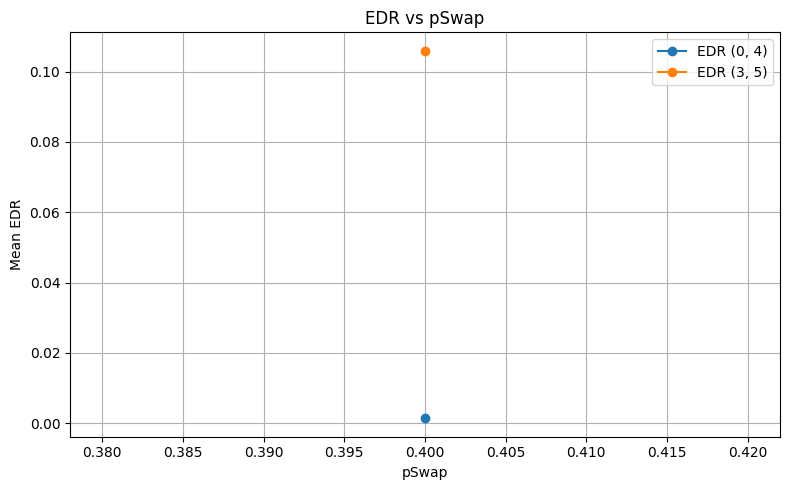

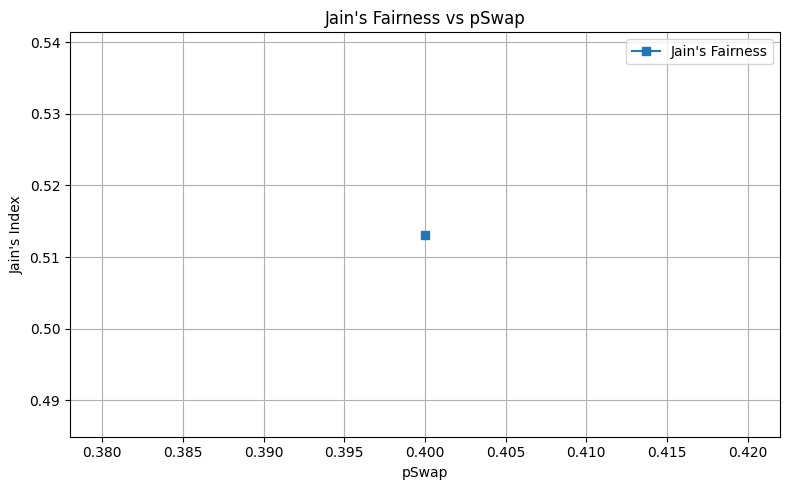

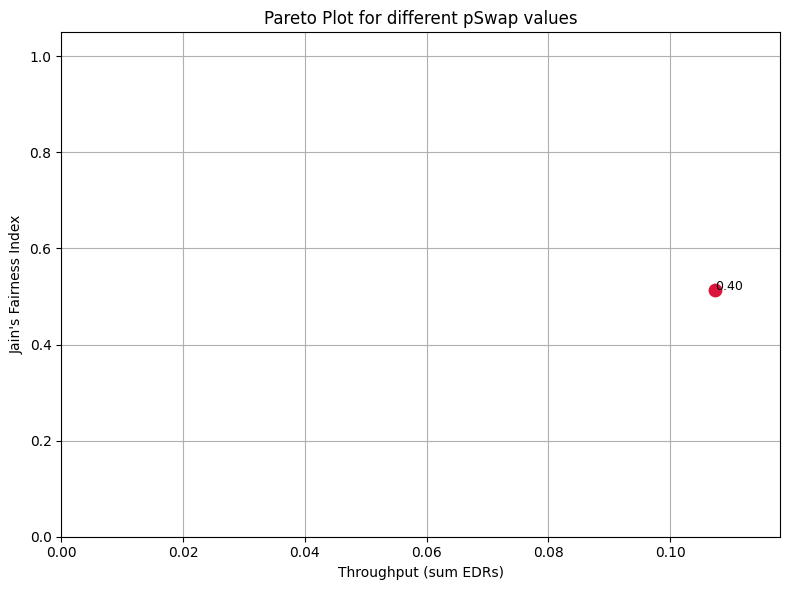


=== Running for pSwap=0.6, pGen=0.4 ===

=== Training with pSwap = 0.6 ===
Step 100000
Step 200000
Step 300000
Step 400000
Step 500000
Step 600000
Step 700000
Step 800000
Step 900000
Step 1000000
Step 1000000: alpha = 0.000250

Metrics After Burn-in (first 5000 steps ignored):
Mean EDRs: {(0, 4): '0.0138', (3, 5): '0.1537'}
Total Throughput (sum of EDRs): 0.1674
Jain's Fairness Index: 0.5888
Waited when could have acted: 0/12571 = 0.0000


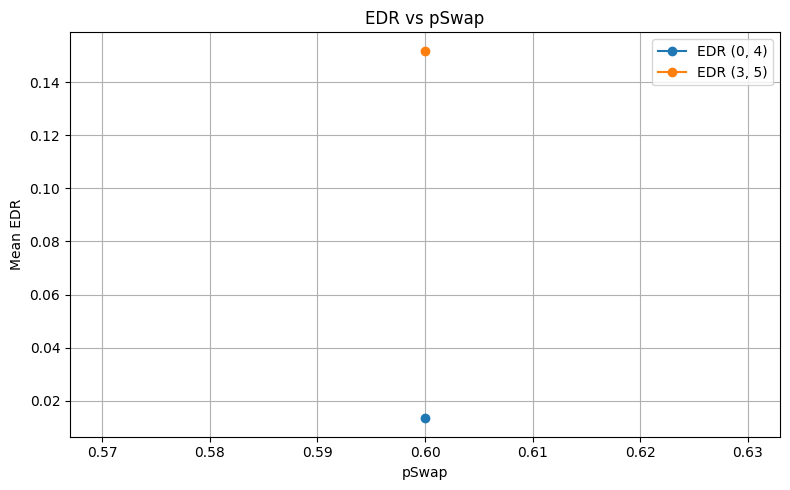

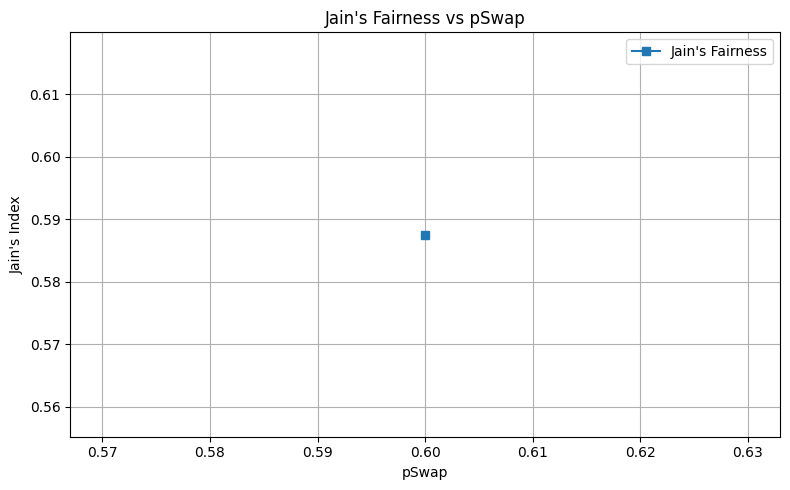

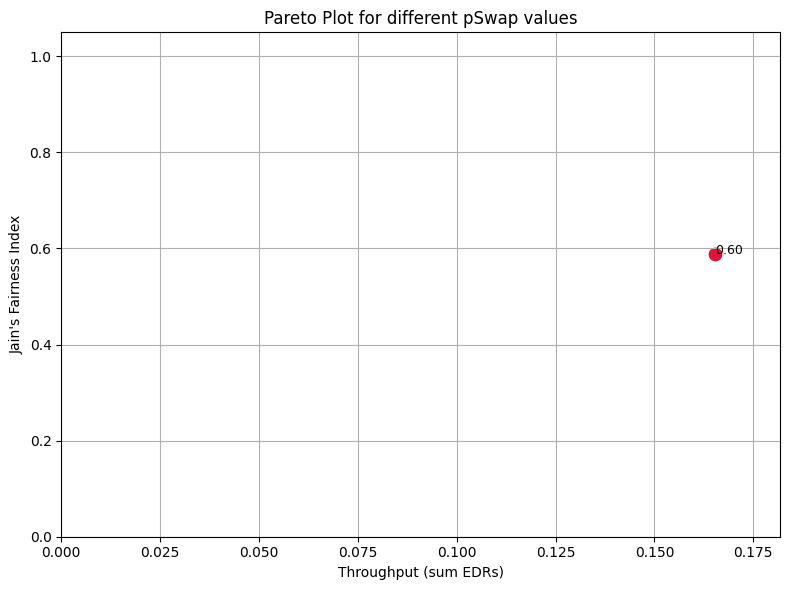


=== Running for pSwap=0.8, pGen=0.4 ===

=== Training with pSwap = 0.8 ===
Step 100000
Step 200000
Step 300000
Step 400000
Step 500000
Step 600000
Step 700000
Step 800000
Step 900000
Step 1000000
Step 1000000: alpha = 0.000250

Metrics After Burn-in (first 5000 steps ignored):
Mean EDRs: {(0, 4): '0.0417', (3, 5): '0.1876'}
Total Throughput (sum of EDRs): 0.2293
Jain's Fairness Index: 0.7120
Waited when could have acted: 0/12724 = 0.0000


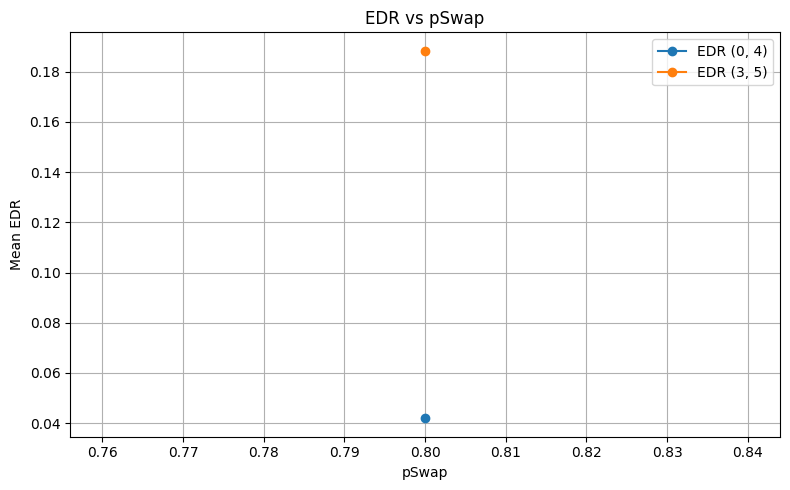

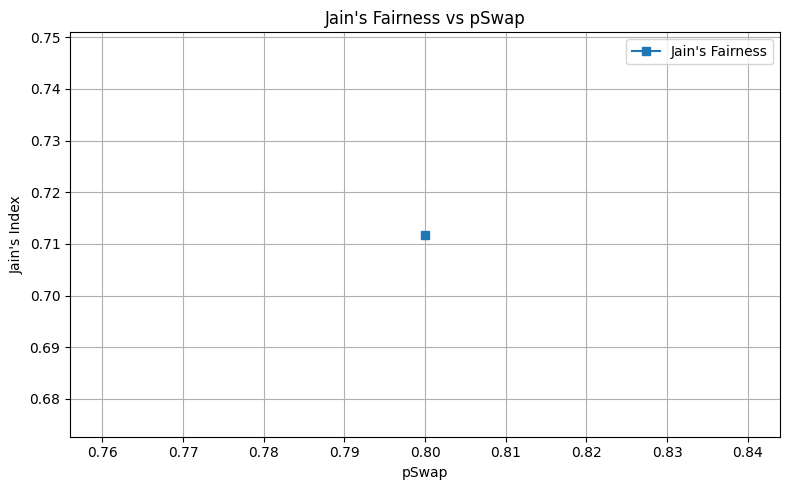

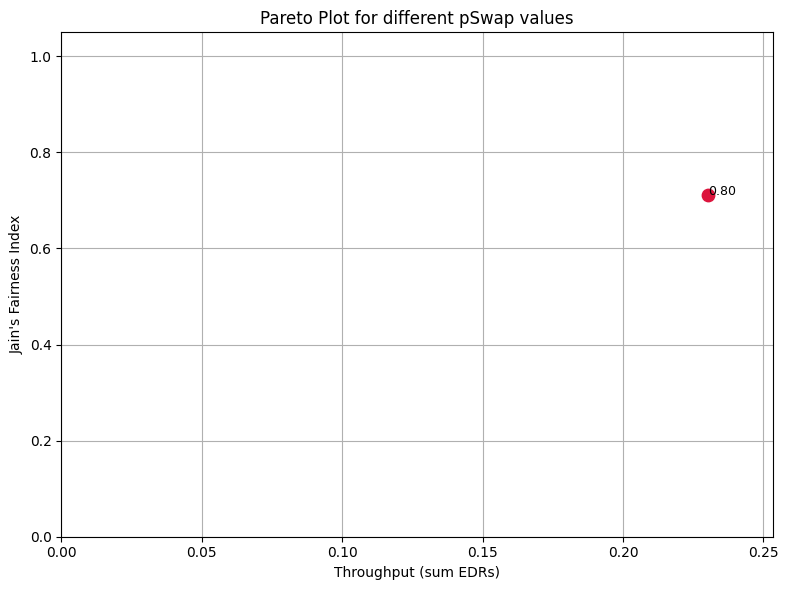


=== Running for pSwap=1, pGen=0.4 ===

=== Training with pSwap = 1 ===
Step 100000
Step 200000
Step 300000
Step 400000
Step 500000
Step 600000
Step 700000
Step 800000
Step 900000
Step 1000000
Step 1000000: alpha = 0.000250

Metrics After Burn-in (first 5000 steps ignored):
Mean EDRs: {(0, 4): '0.0000', (3, 5): '0.2637'}
Total Throughput (sum of EDRs): 0.2637
Jain's Fairness Index: 0.5000
Waited when could have acted: 3366/13913 = 0.2419


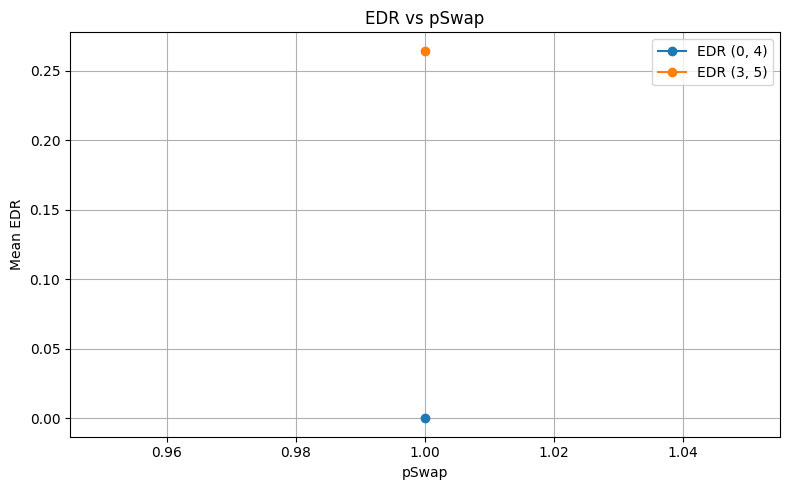

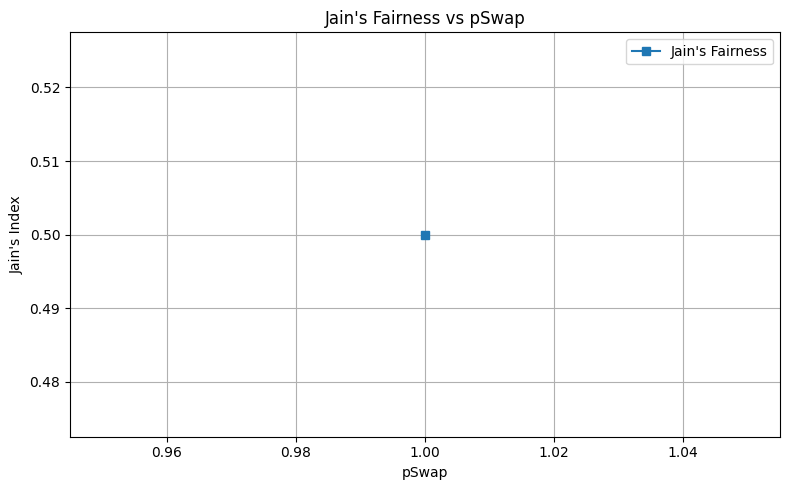

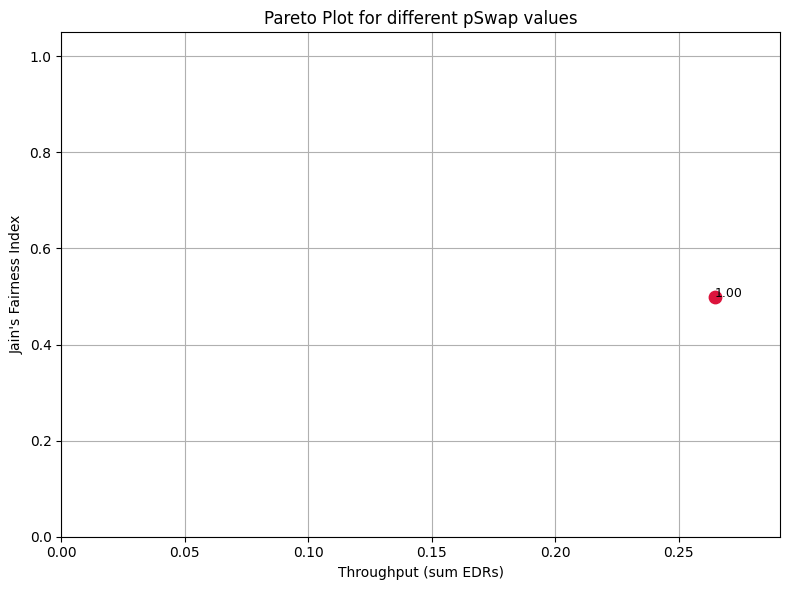


=== Running for pSwap=0.2, pGen=0.6 ===

=== Training with pSwap = 0.2 ===
Step 100000
Step 200000
Step 300000
Step 400000
Step 500000
Step 600000
Step 700000
Step 800000
Step 900000
Step 1000000
Step 1000000: alpha = 0.000250

Metrics After Burn-in (first 5000 steps ignored):
Mean EDRs: {(0, 4): '0.0004', (3, 5): '0.0917'}
Total Throughput (sum of EDRs): 0.0921
Jain's Fairness Index: 0.5040
Waited when could have acted: 3235/22813 = 0.1418


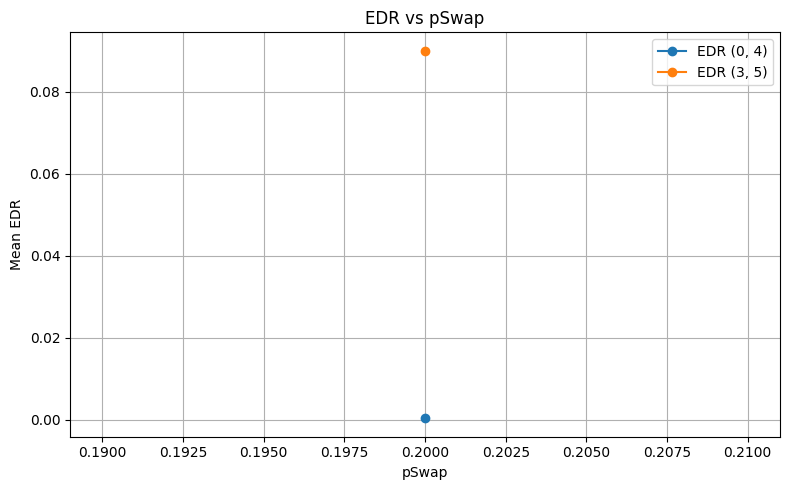

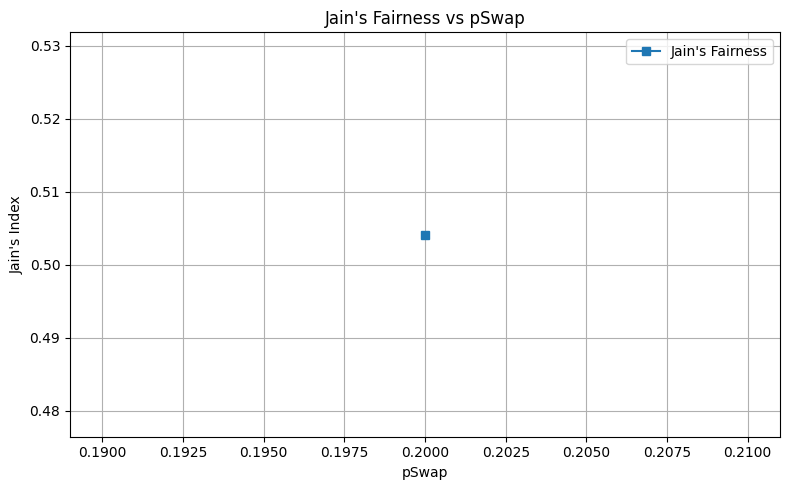

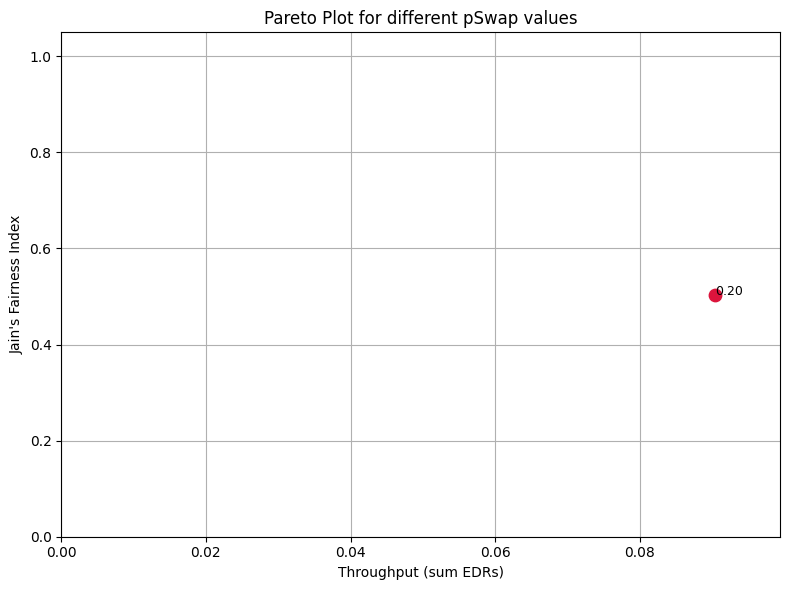


=== Running for pSwap=0.4, pGen=0.6 ===

=== Training with pSwap = 0.4 ===
Step 100000
Step 200000
Step 300000
Step 400000
Step 500000
Step 600000
Step 700000
Step 800000
Step 900000
Step 1000000
Step 1000000: alpha = 0.000250

Metrics After Burn-in (first 5000 steps ignored):
Mean EDRs: {(0, 4): '0.0062', (3, 5): '0.1760'}
Total Throughput (sum of EDRs): 0.1822
Jain's Fairness Index: 0.5352
Waited when could have acted: 275/21837 = 0.0126


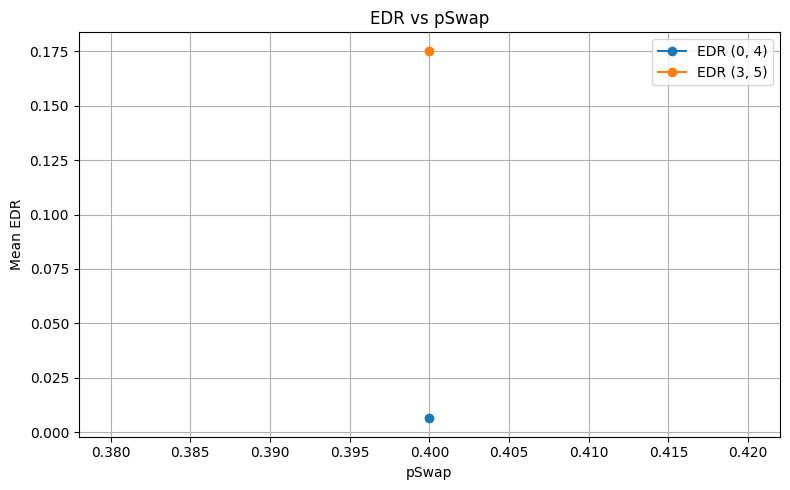

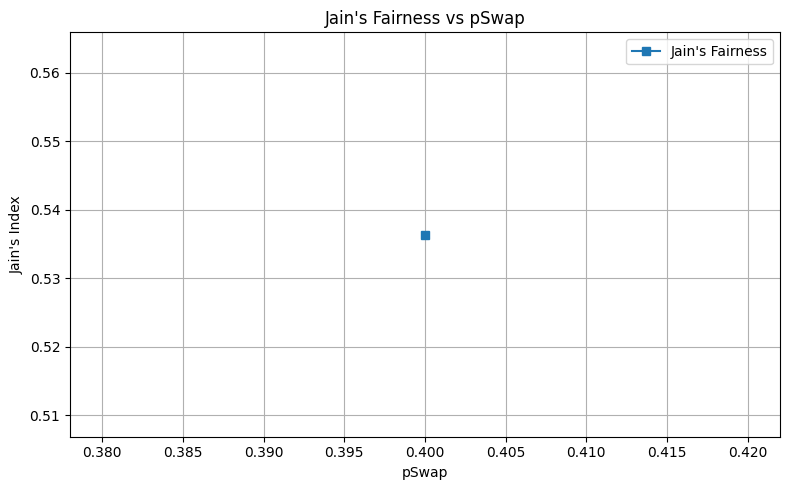

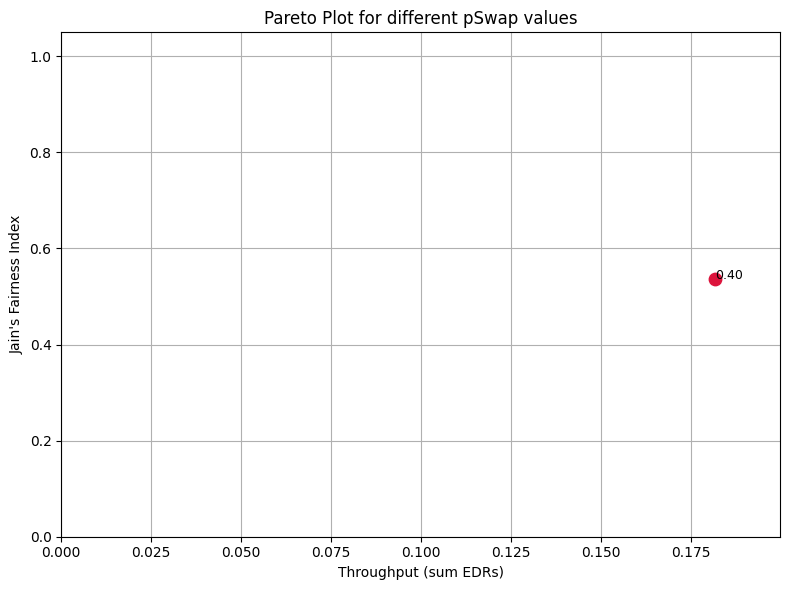


=== Running for pSwap=0.6, pGen=0.6 ===

=== Training with pSwap = 0.6 ===
Step 100000
Step 200000
Step 300000
Step 400000
Step 500000
Step 600000
Step 700000
Step 800000
Step 900000
Step 1000000
Step 1000000: alpha = 0.000250

Metrics After Burn-in (first 5000 steps ignored):
Mean EDRs: {(0, 4): '0.0219', (3, 5): '0.2636'}
Total Throughput (sum of EDRs): 0.2855
Jain's Fairness Index: 0.5825
Waited when could have acted: 0/21645 = 0.0000


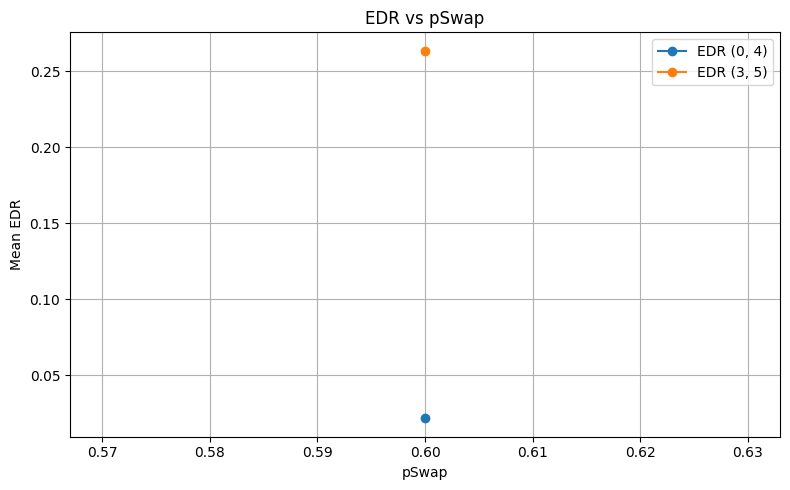

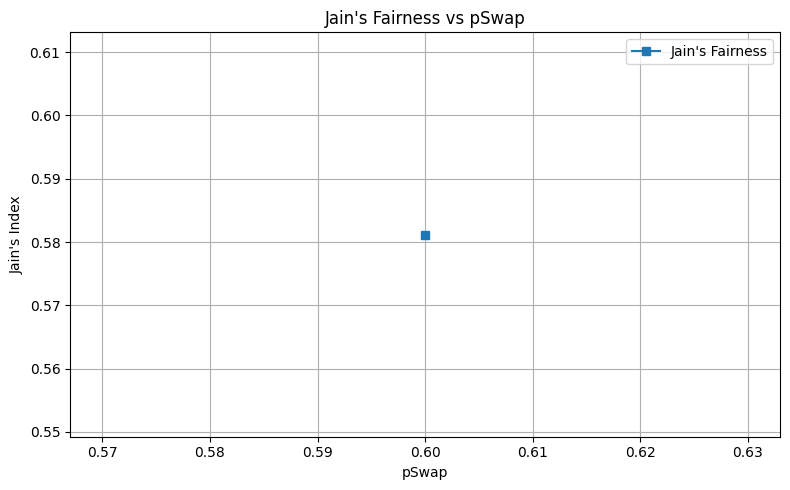

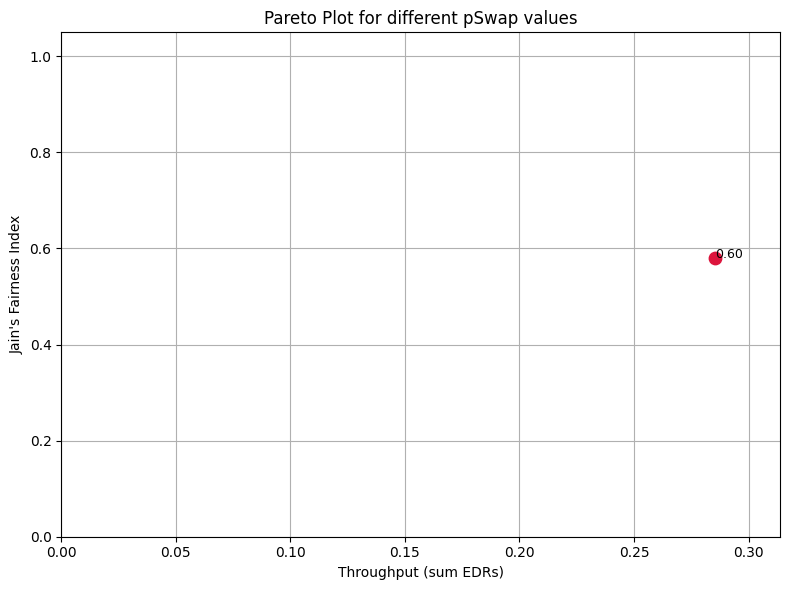


=== Running for pSwap=0.8, pGen=0.6 ===

=== Training with pSwap = 0.8 ===
Step 100000
Step 200000
Step 300000
Step 400000
Step 500000
Step 600000
Step 700000
Step 800000
Step 900000
Step 1000000
Step 1000000: alpha = 0.000250

Metrics After Burn-in (first 5000 steps ignored):
Mean EDRs: {(0, 4): '0.0932', (3, 5): '0.2936'}
Total Throughput (sum of EDRs): 0.3868
Jain's Fairness Index: 0.7883
Waited when could have acted: 0/21966 = 0.0000


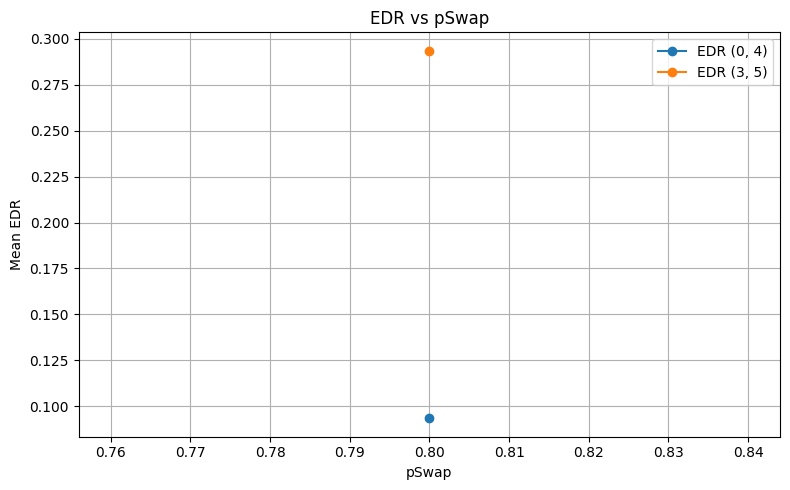

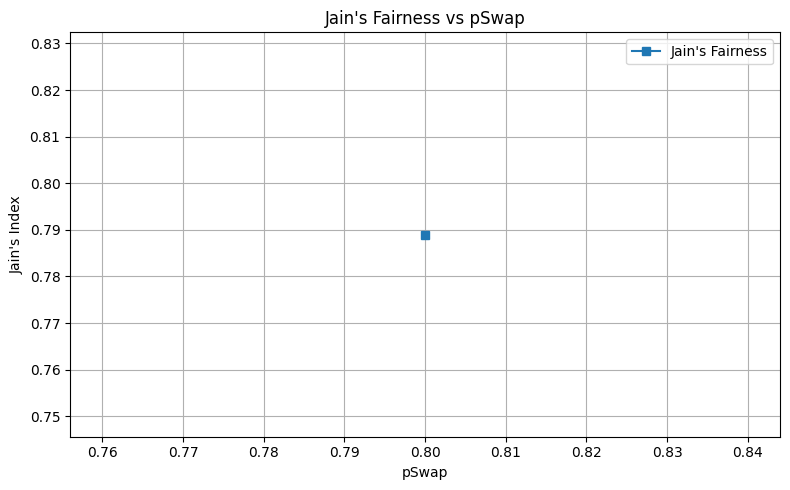

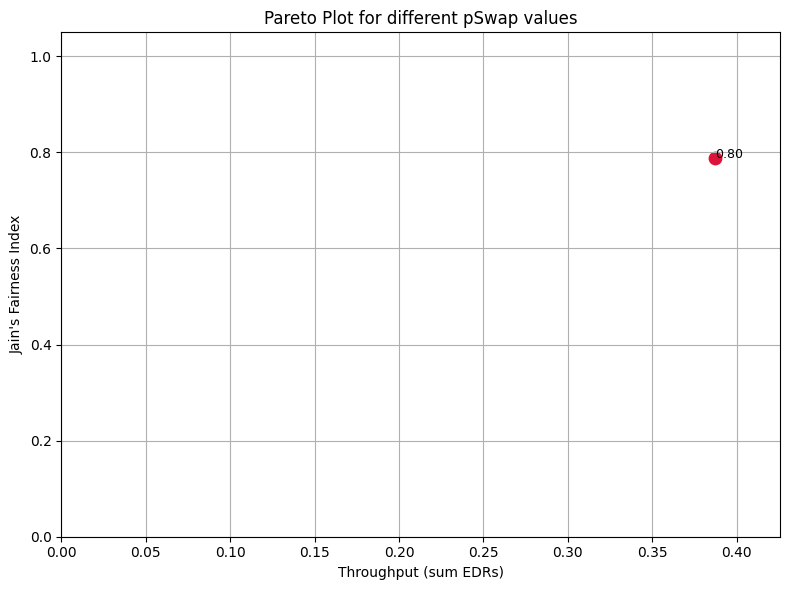


=== Running for pSwap=1, pGen=0.6 ===

=== Training with pSwap = 1 ===
Step 100000
Step 200000
Step 300000
Step 400000
Step 500000
Step 600000
Step 700000
Step 800000
Step 900000
Step 1000000
Step 1000000: alpha = 0.000250

Metrics After Burn-in (first 5000 steps ignored):
Mean EDRs: {(0, 4): '0.2483', (3, 5): '0.3032'}
Total Throughput (sum of EDRs): 0.5515
Jain's Fairness Index: 0.9902
Waited when could have acted: 0/21968 = 0.0000


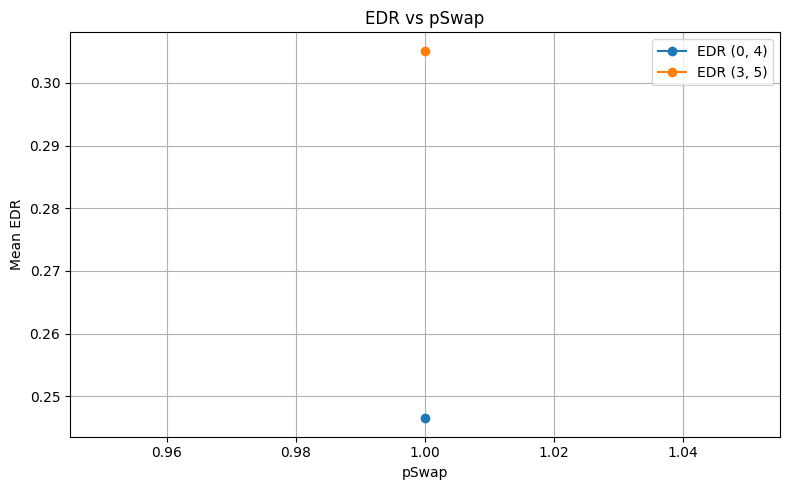

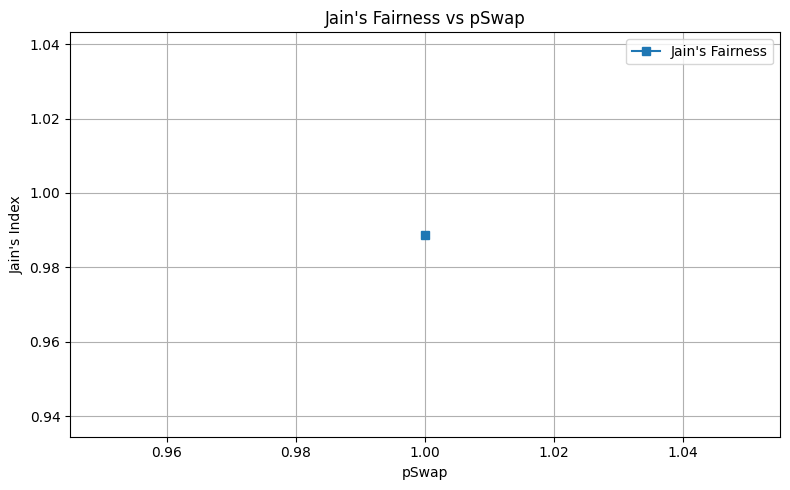

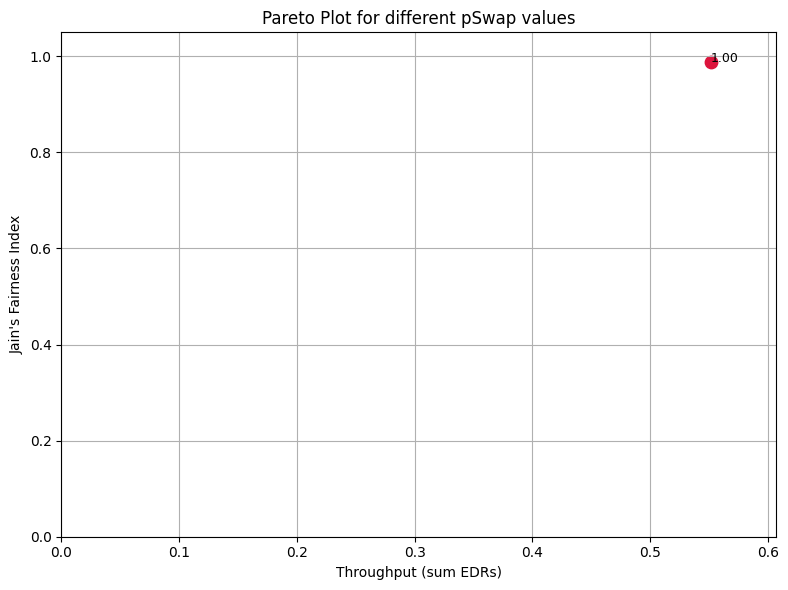


=== Running for pSwap=0.2, pGen=0.8 ===

=== Training with pSwap = 0.2 ===
Step 100000
Step 200000
Step 300000
Step 400000
Step 500000
Step 600000
Step 700000
Step 800000
Step 900000
Step 1000000
Step 1000000: alpha = 0.000250

Metrics After Burn-in (first 5000 steps ignored):
Mean EDRs: {(0, 4): '0.0000', (3, 5): '0.1369'}
Total Throughput (sum of EDRs): 0.1369
Jain's Fairness Index: 0.5000
Waited when could have acted: 4392/31836 = 0.1380


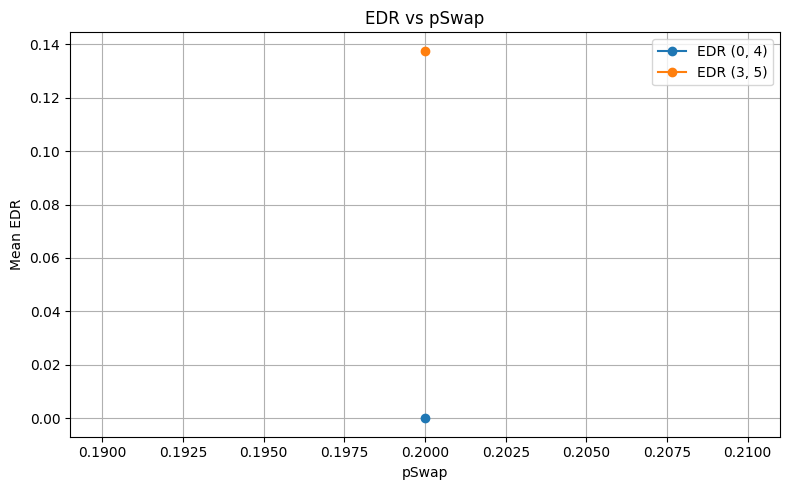

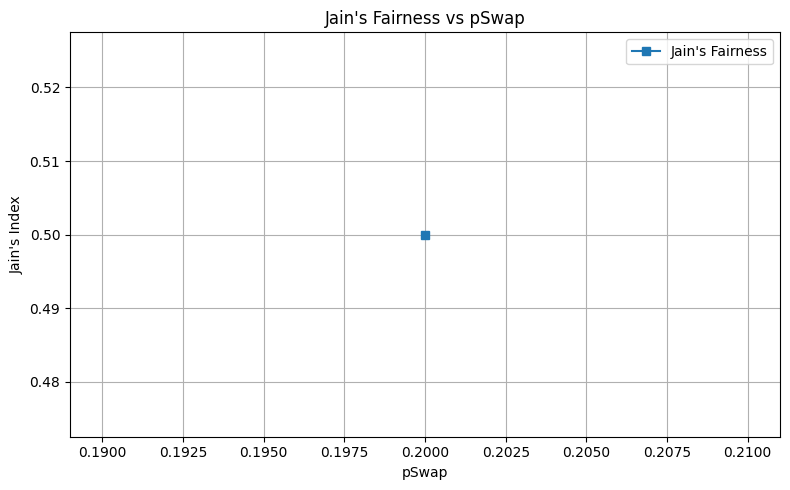

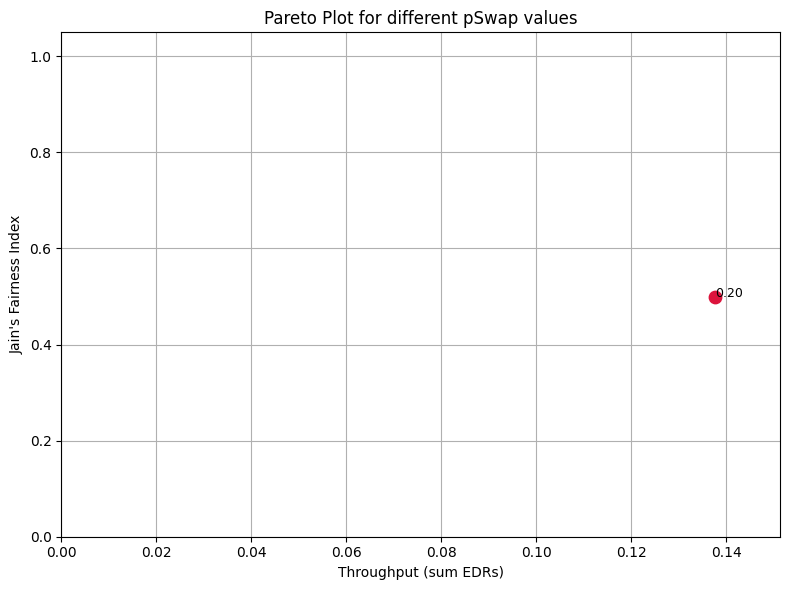


=== Running for pSwap=0.4, pGen=0.8 ===

=== Training with pSwap = 0.4 ===
Step 100000
Step 200000
Step 300000
Step 400000
Step 500000
Step 600000
Step 700000
Step 800000
Step 900000
Step 1000000
Step 1000000: alpha = 0.000250

Metrics After Burn-in (first 5000 steps ignored):
Mean EDRs: {(0, 4): '0.0068', (3, 5): '0.2702'}
Total Throughput (sum of EDRs): 0.2770
Jain's Fairness Index: 0.5250
Waited when could have acted: 0/31067 = 0.0000


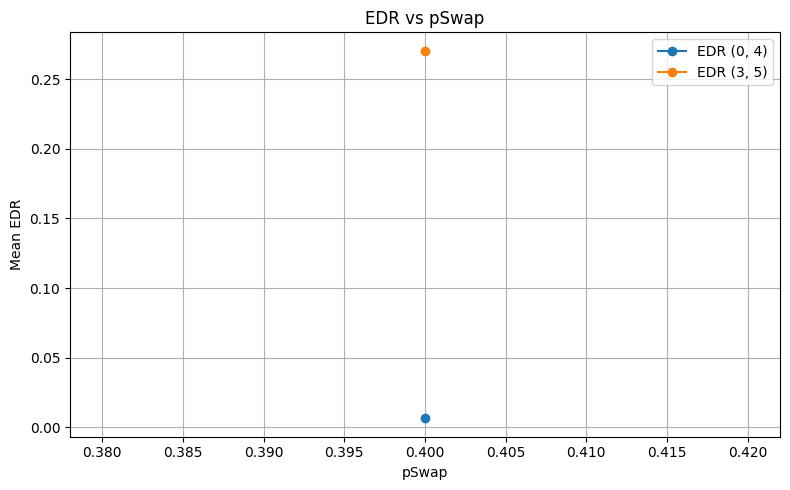

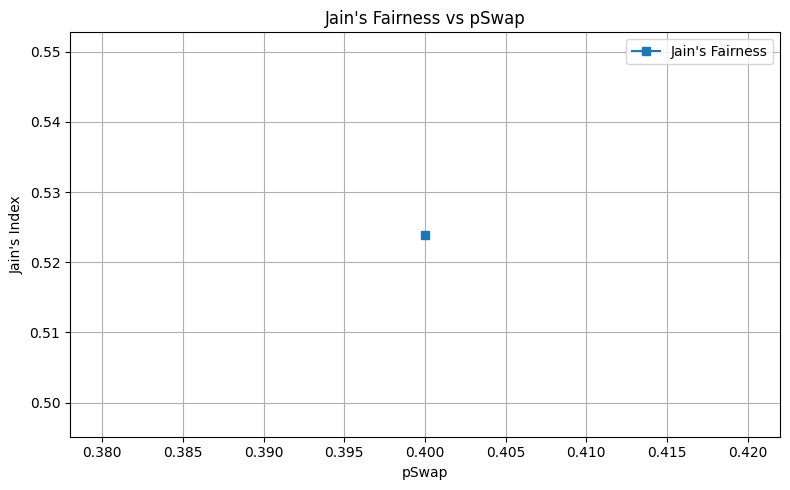

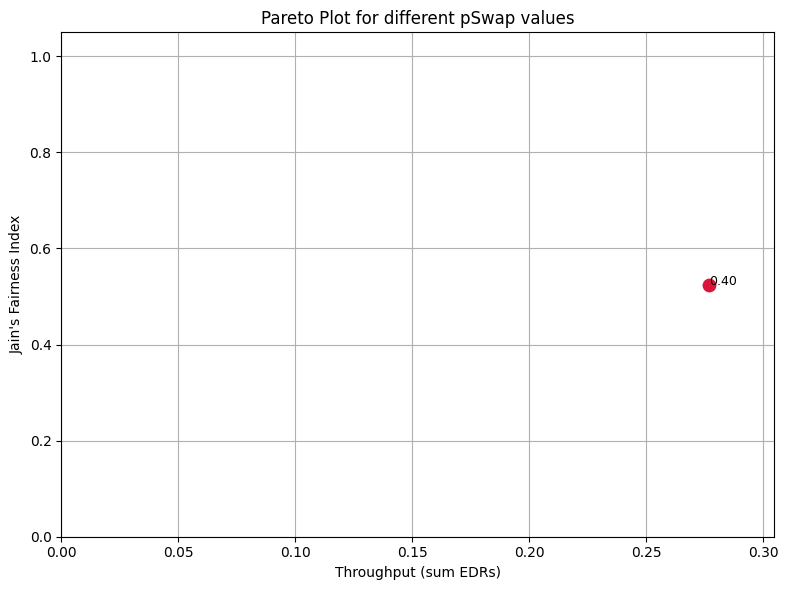


=== Running for pSwap=0.6, pGen=0.8 ===

=== Training with pSwap = 0.6 ===
Step 100000
Step 200000
Step 300000
Step 400000
Step 500000
Step 600000
Step 700000
Step 800000
Step 900000
Step 1000000
Step 1000000: alpha = 0.000250

Metrics After Burn-in (first 5000 steps ignored):
Mean EDRs: {(0, 4): '0.0226', (3, 5): '0.4035'}
Total Throughput (sum of EDRs): 0.4261
Jain's Fairness Index: 0.5559
Waited when could have acted: 0/31053 = 0.0000


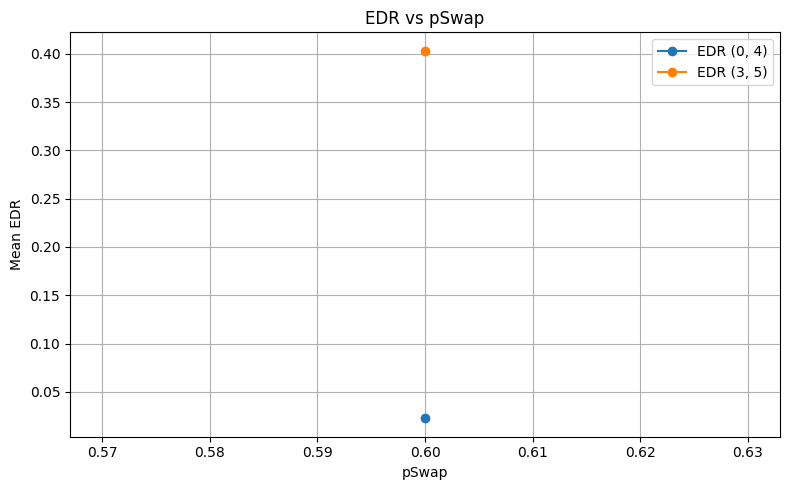

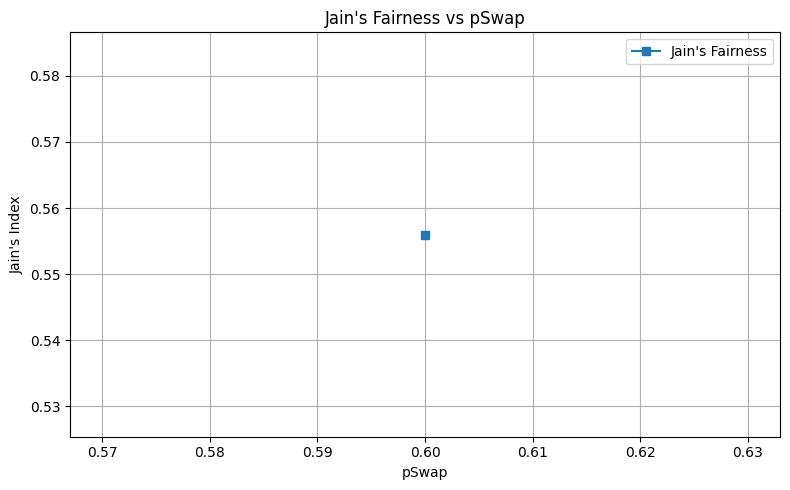

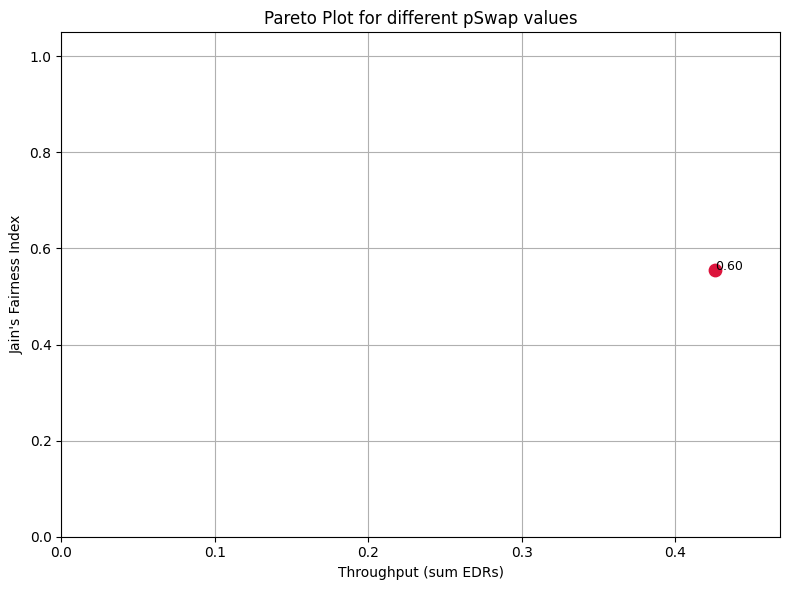


=== Running for pSwap=0.8, pGen=0.8 ===

=== Training with pSwap = 0.8 ===
Step 100000
Step 200000
Step 300000
Step 400000
Step 500000
Step 600000
Step 700000
Step 800000
Step 900000
Step 1000000
Step 1000000: alpha = 0.000250

Metrics After Burn-in (first 5000 steps ignored):
Mean EDRs: {(0, 4): '0.0841', (3, 5): '0.4880'}
Total Throughput (sum of EDRs): 0.5721
Jain's Fairness Index: 0.6674
Waited when could have acted: 0/31146 = 0.0000


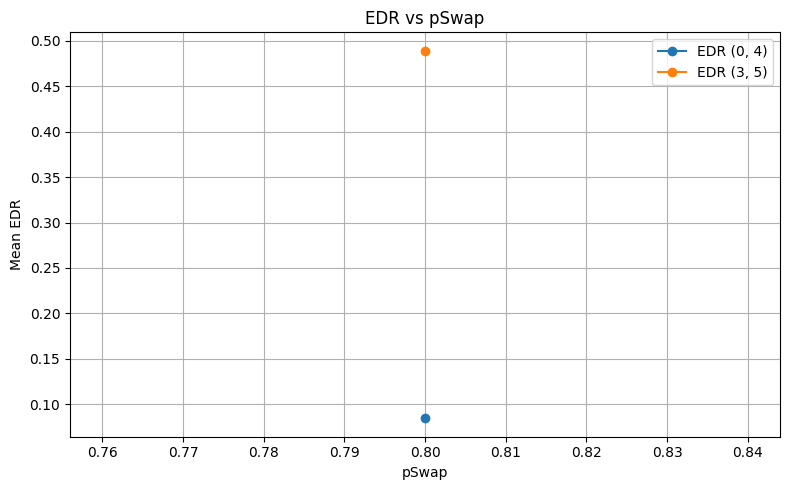

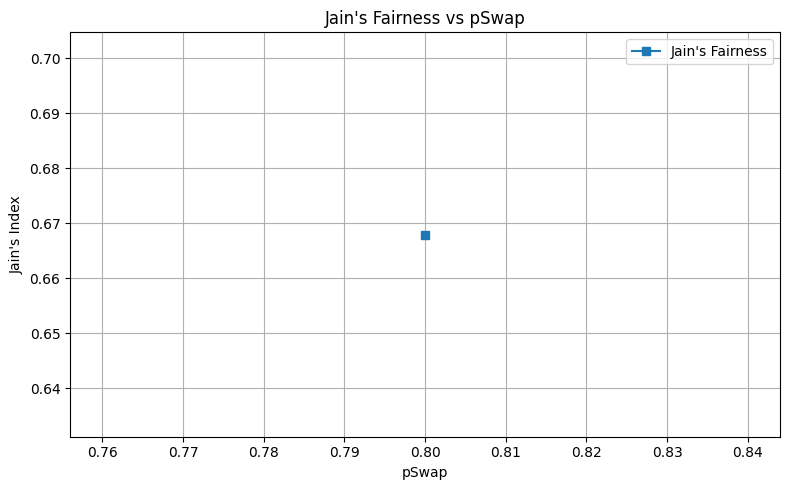

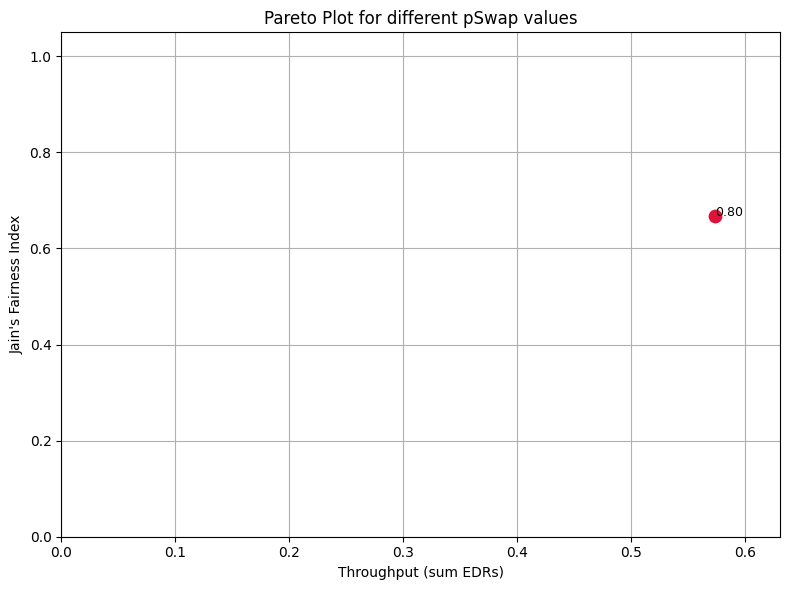


=== Running for pSwap=1, pGen=0.8 ===

=== Training with pSwap = 1 ===
Step 100000
Step 200000
Step 300000
Step 400000
Step 500000
Step 600000
Step 700000
Step 800000
Step 900000
Step 1000000
Step 1000000: alpha = 0.000250

Metrics After Burn-in (first 5000 steps ignored):
Mean EDRs: {(0, 4): '0.4171', (3, 5): '0.3709'}
Total Throughput (sum of EDRs): 0.7881
Jain's Fairness Index: 0.9966
Waited when could have acted: 0/31520 = 0.0000


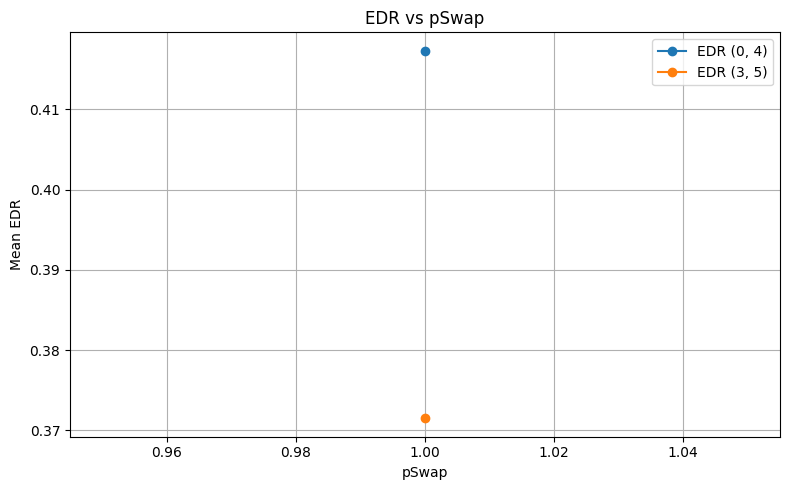

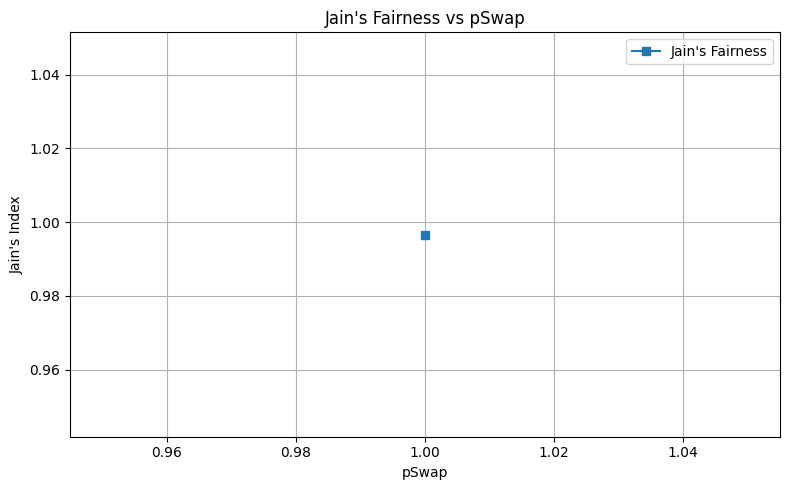

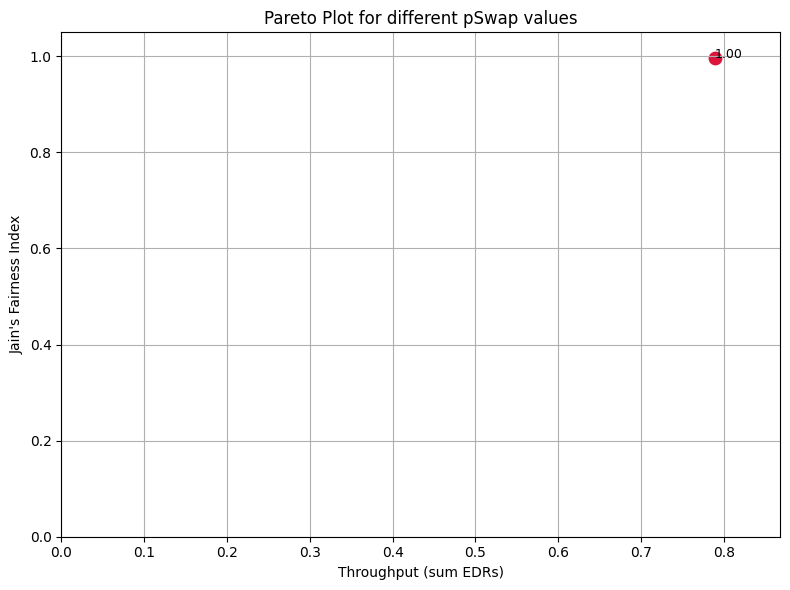


=== Running for pSwap=0.2, pGen=1 ===

=== Training with pSwap = 0.2 ===
Step 100000
Step 200000
Step 300000
Step 400000
Step 500000
Step 600000
Step 700000
Step 800000
Step 900000
Step 1000000
Step 1000000: alpha = 0.000250

Metrics After Burn-in (first 5000 steps ignored):
Mean EDRs: {(0, 4): '0.0000', (3, 5): '0.1999'}
Total Throughput (sum of EDRs): 0.1999
Jain's Fairness Index: 0.5000
Waited when could have acted: 0/39999 = 0.0000


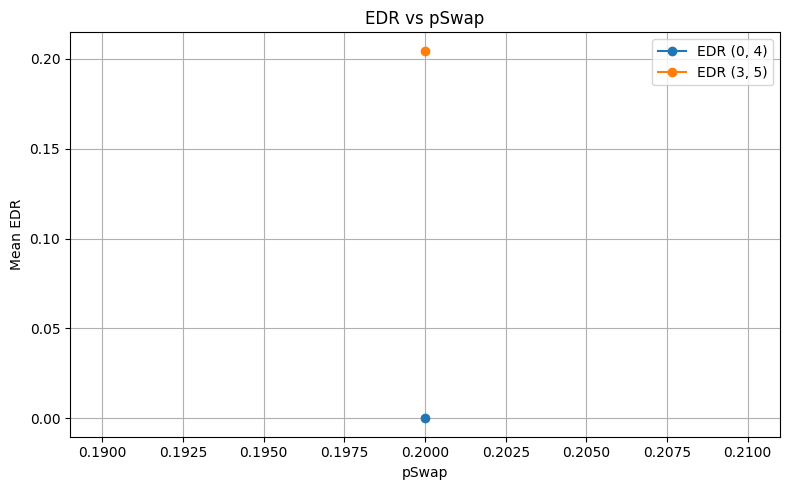

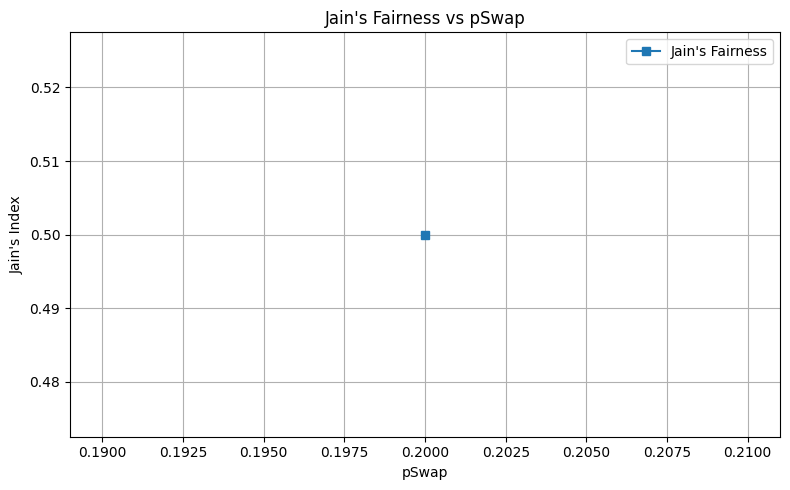

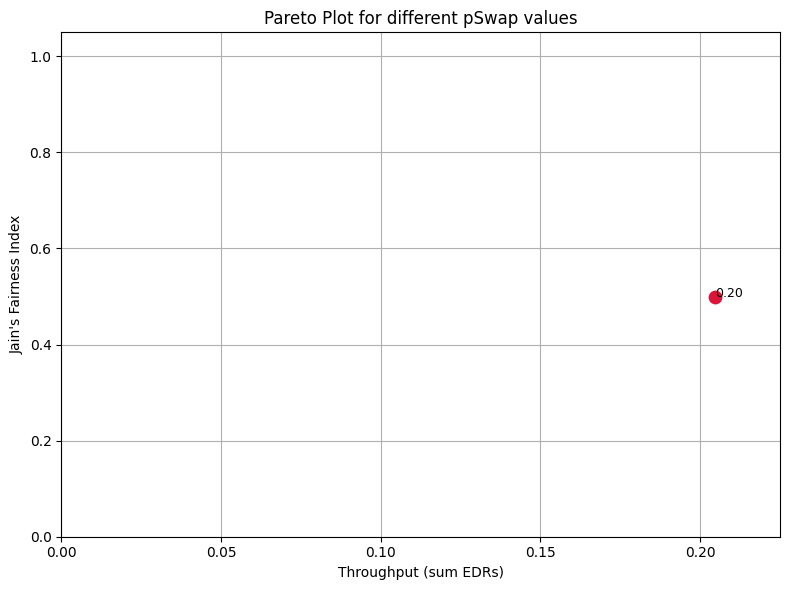


=== Running for pSwap=0.4, pGen=1 ===

=== Training with pSwap = 0.4 ===
Step 100000
Step 200000
Step 300000
Step 400000
Step 500000
Step 600000
Step 700000
Step 800000
Step 900000
Step 1000000
Step 1000000: alpha = 0.000250

Metrics After Burn-in (first 5000 steps ignored):
Mean EDRs: {(0, 4): '0.0000', (3, 5): '0.3989'}
Total Throughput (sum of EDRs): 0.3989
Jain's Fairness Index: 0.5000
Waited when could have acted: 0/39999 = 0.0000


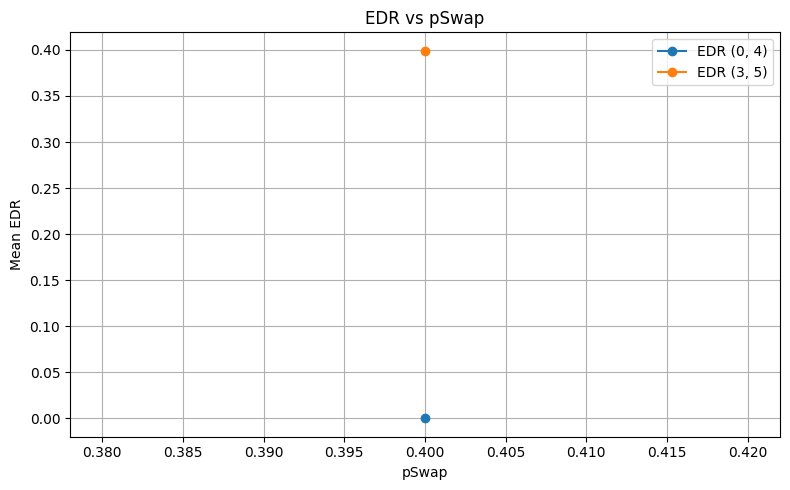

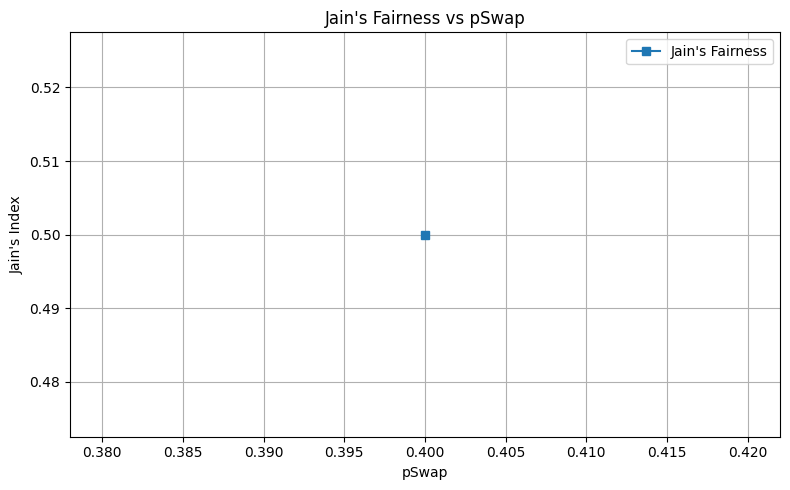

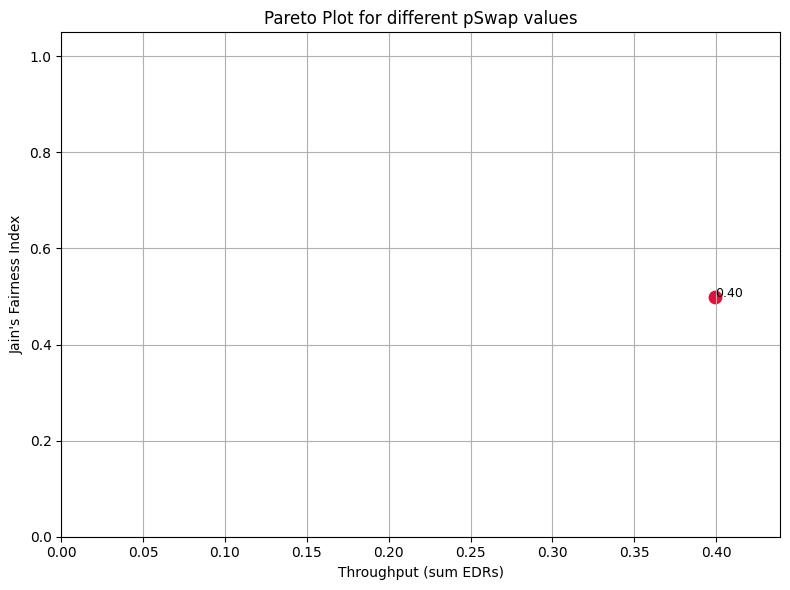


=== Running for pSwap=0.6, pGen=1 ===

=== Training with pSwap = 0.6 ===
Step 100000
Step 200000
Step 300000
Step 400000
Step 500000
Step 600000
Step 700000
Step 800000
Step 900000
Step 1000000
Step 1000000: alpha = 0.000250

Metrics After Burn-in (first 5000 steps ignored):
Mean EDRs: {(0, 4): '0.0000', (3, 5): '0.5982'}
Total Throughput (sum of EDRs): 0.5982
Jain's Fairness Index: 0.5000
Waited when could have acted: 0/39999 = 0.0000


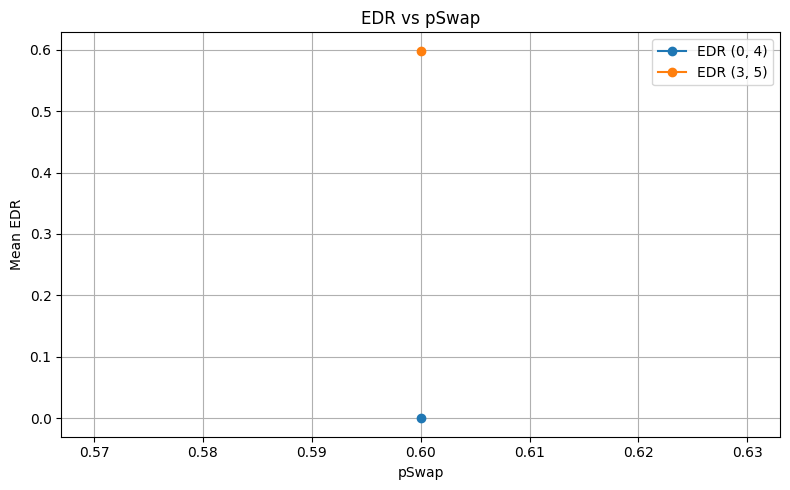

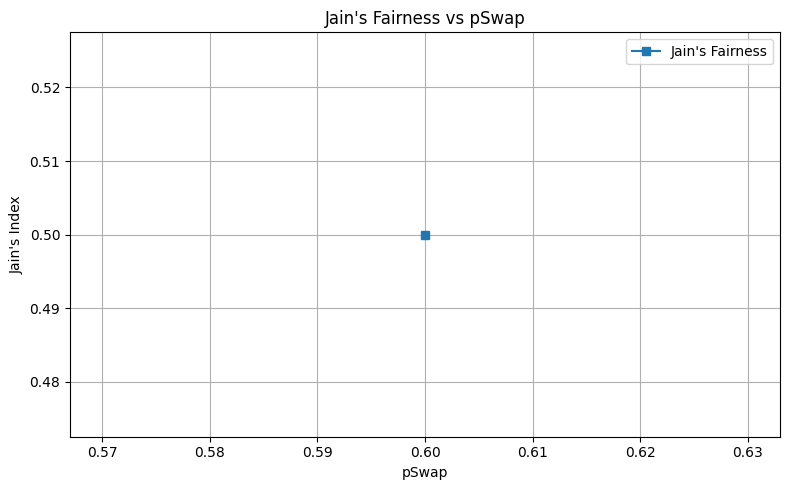

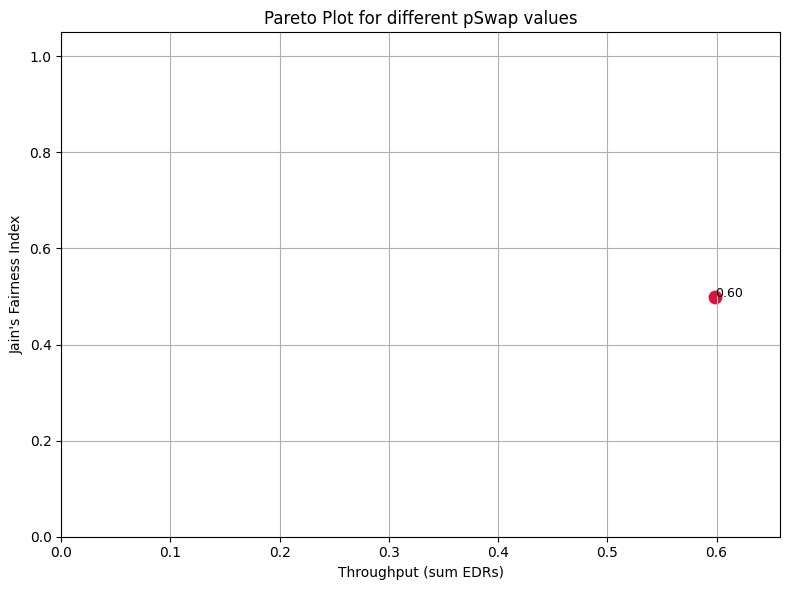


=== Running for pSwap=0.8, pGen=1 ===

=== Training with pSwap = 0.8 ===
Step 100000
Step 200000
Step 300000
Step 400000
Step 500000
Step 600000
Step 700000
Step 800000
Step 900000
Step 1000000
Step 1000000: alpha = 0.000250

Metrics After Burn-in (first 5000 steps ignored):
Mean EDRs: {(0, 4): '0.1713', (3, 5): '0.5356'}
Total Throughput (sum of EDRs): 0.7069
Jain's Fairness Index: 0.7902
Waited when could have acted: 0/39999 = 0.0000


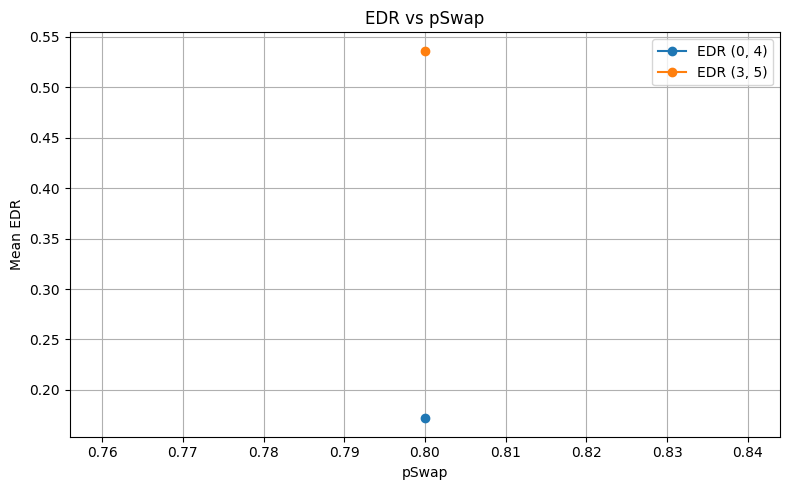

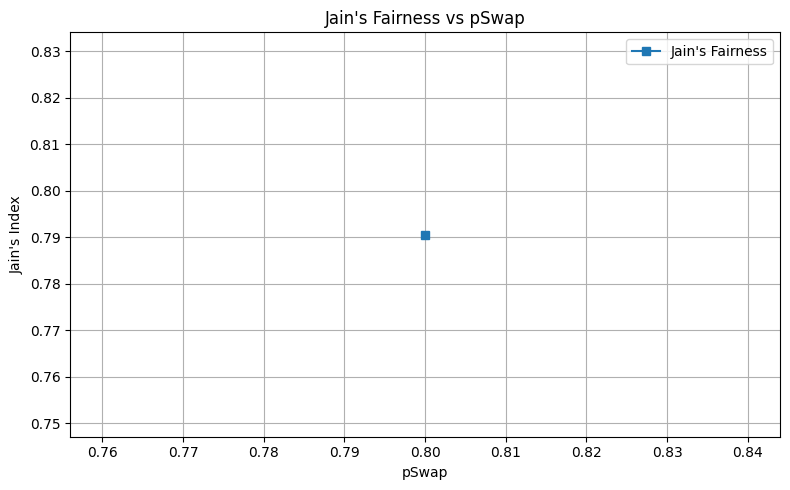

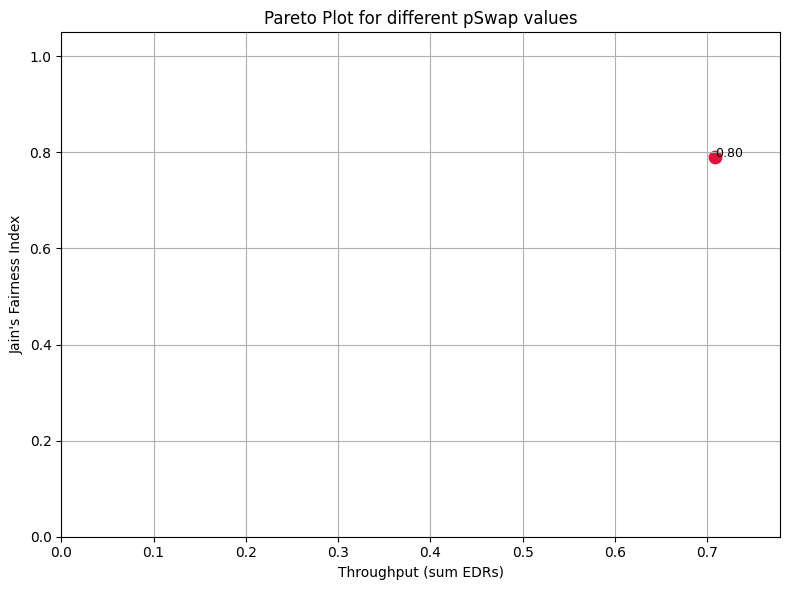


=== Running for pSwap=1, pGen=1 ===

=== Training with pSwap = 1 ===
Step 100000
Step 200000
Step 300000
Step 400000
Step 500000
Step 600000
Step 700000
Step 800000
Step 900000
Step 1000000
Step 1000000: alpha = 0.000250

Metrics After Burn-in (first 5000 steps ignored):
Mean EDRs: {(0, 4): '0.5000', (3, 5): '0.5000'}
Total Throughput (sum of EDRs): 1.0000
Jain's Fairness Index: 1.0000
Waited when could have acted: 0/39999 = 0.0000


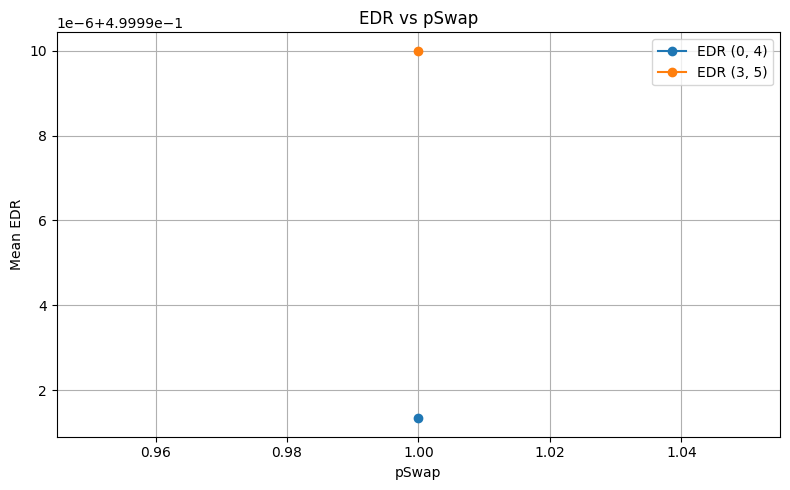

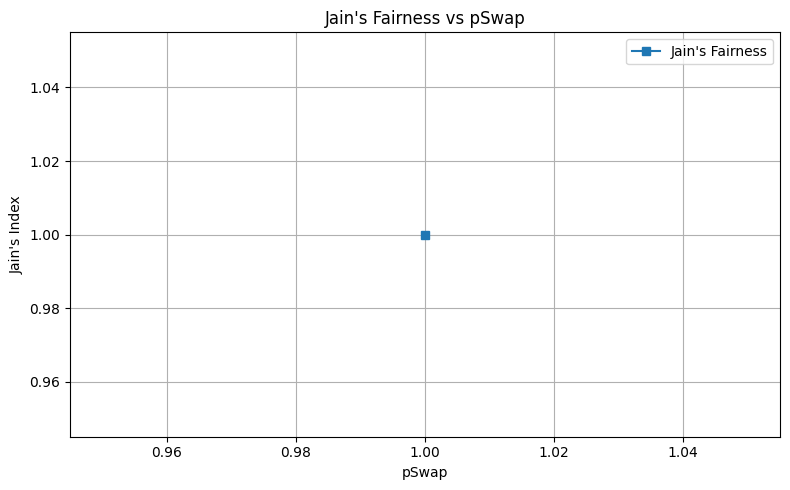

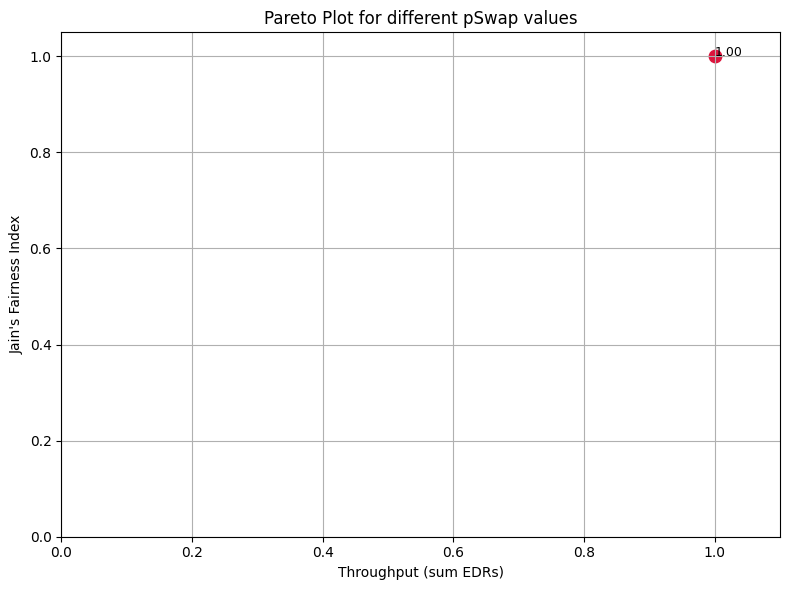

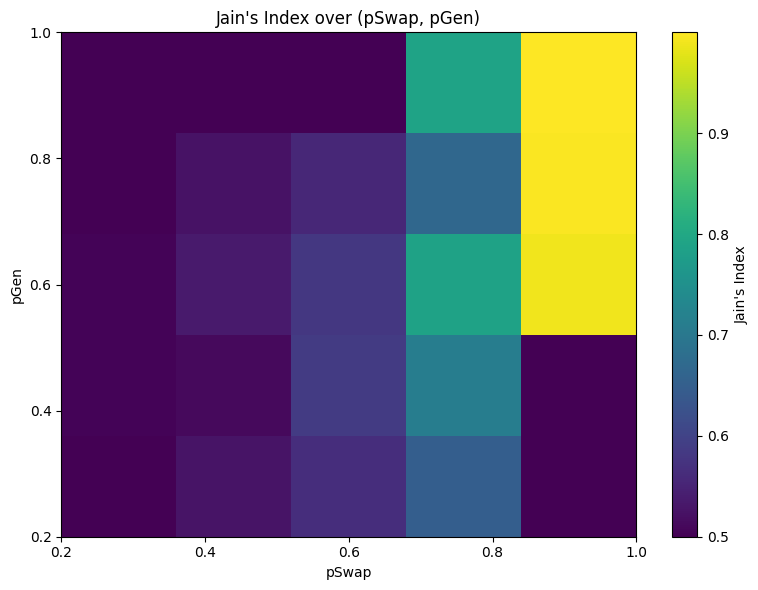

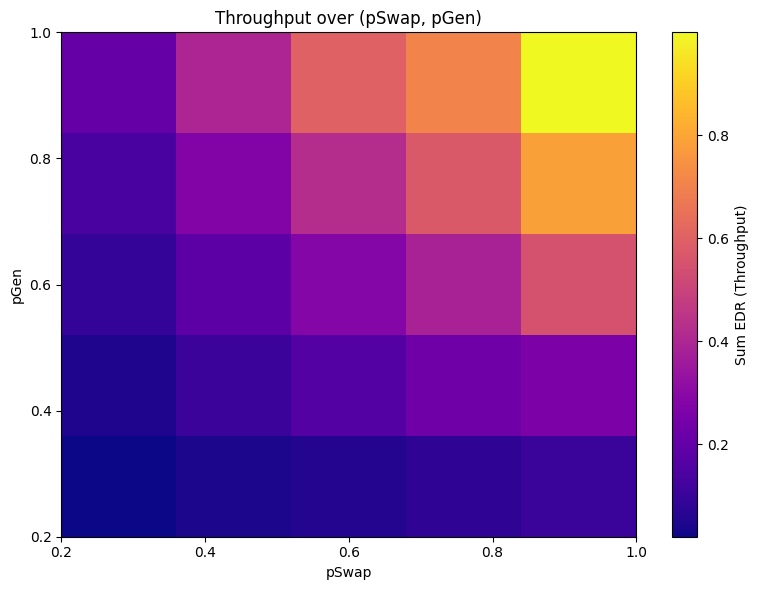

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Set up parameters
seed = 30
random.seed(seed)
np.random.seed(seed)

edges = [(0,1), (1,2), (2,3), (3,4), (2,5)]
goal_edges = [(0,4), (3,5)]

pSwap = 0.6
pGen = 0.6
maxAge = 3
totalSteps = 1_000_000

nLookahead = 5
gamma = 0.995
windowSize = 1000
reward_mode = 'basic' 
temperature = 6.0
final_temperature = 0.1
temperature_decay = (final_temperature / temperature) ** (1.0 / (totalSteps * 1.2))
nestedSwaps = False

# --- Define your sweeps ---
pSwap_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
pGen_values =[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

pSwap_values = [0.2, 0.4, 0.6, 0.8, 1]
pGen_values =[0.2, 0.4, 0.6, 0.8, 1]
# Prepare matrices
jain_matrix = np.zeros((len(pGen_values), len(pSwap_values)))
edr_matrix = np.zeros((len(pGen_values), len(pSwap_values)))

# --- Loop over (pGen, pSwap) grid ---
for i, pGen_val in enumerate(pGen_values):
    for j, pSwap_val in enumerate(pSwap_values):
        print(f"\n=== Running for pSwap={pSwap_val}, pGen={pGen_val} ===")
        
        result = compareOverParam(
            param_name='pSwap',  # We will manually vary pSwap and pGen
            param_values=[pSwap_val],  # just single value
            edges=edges,
            goal_edges=goal_edges,
            pSwap=pSwap_val,
            pGen=pGen_val,
            max_age=maxAge,
            totalSteps=totalSteps,
            nLookahead=nLookahead,
            alpha=alpha,
            gamma=gamma,
            edr_window_size=windowSize,
            reward_mode='basic',  # or linear, partial
            temperature=temperature,
            temperature_decay=temperature_decay,
            seed=seed,
            nestedSwaps=nestedSwaps,
            training_function=train_sarsa_linear_policy,
            simulate_steps=40_000,
            burn_in_ratio=0.5,
        )

        # Extract Jain and EDR (throughput = sum EDRs)
        jain = result['jain_results'][0]
        edr_sum = sum(result['edr_results'][g][0] for g in goal_edges)

        jain_matrix[i, j] = jain
        edr_matrix[i, j] = edr_sum

# --- Now plot heatmaps ---

# (1) Jain's Index Heatmap
plt.figure(figsize=(8,6))
plt.imshow(jain_matrix, origin='lower', cmap='viridis', extent=[min(pSwap_values), max(pSwap_values), min(pGen_values), max(pGen_values)], aspect='auto')
plt.colorbar(label="Jain's Index")
plt.xlabel('pSwap')
plt.ylabel('pGen')
plt.title("Jain's Index over (pSwap, pGen)")
plt.xticks(pSwap_values)
plt.yticks(pGen_values)
plt.grid(False)
plt.tight_layout()
plt.show()

# (2) EDR Sum (Throughput) Heatmap
plt.figure(figsize=(8,6))
plt.imshow(edr_matrix, origin='lower', cmap='plasma', extent=[min(pSwap_values), max(pSwap_values), min(pGen_values), max(pGen_values)], aspect='auto')
plt.colorbar(label="Sum EDR (Throughput)")
plt.xlabel('pSwap')
plt.ylabel('pGen')
plt.title("Throughput over (pSwap, pGen)")
plt.xticks(pSwap_values)
plt.yticks(pGen_values)
plt.grid(False)
plt.tight_layout()
plt.show()


In [ ]:

print(big_grid_jain)
print(big_grid_Edr)

[[0.5        0.52704163 0.5653287  0.65032336 0.5       ]
 [0.5055372  0.51313699 0.58755214 0.71181663 0.5       ]
 [0.50414515 0.53636279 0.58118257 0.78899026 0.98881581]
 [0.5        0.52394399 0.55600171 0.66795353 0.9966423 ]
 [0.5        0.5        0.5        0.79062111 1.        ]]
[[0.02028475 0.03978548 0.05766298 0.07887823 0.10097255]
 [0.05082624 0.10731733 0.16523235 0.23028179 0.2645889 ]
 [0.09035444 0.18162424 0.28522811 0.38695364 0.55162476]
 [0.13755975 0.27689112 0.42574295 0.57361236 0.78879176]
 [0.20455935 0.39913665 0.59827355 0.7080442  0.99999134]]


In [ ]:
# Set up parameters
seed = 30
random.seed(seed)
np.random.seed(seed)

edges = [(0,1), (1,2), (2,3), (3,4), (2,5)]
goal_edges = [(0,4), (3,5)]

pSwap = 0.6
pGen = 0.6
maxAge = 3
totalSteps = 500_000

nLookahead = 5
gamma = 0.995
windowSize = 1000
reward_mode = 'alphafair' 
temperature = 6.0
final_temperature = 0.1
temperature_decay = (final_temperature / temperature) ** (1.0 / (totalSteps * 1.2))
nestedSwaps = False

# Alpha values you want to sweep (example)
alpha_values = [0.2, 0.4, 0.6, 0.9, 1, 1.5, 2]

# Call compareOverAlpha
results = compareOverAlpha(
    alpha_values=alpha_values,
    edges=edges,
    goal_edges=goal_edges,
    pSwap=pSwap,
    pGen=pGen,
    max_age=maxAge,
    totalSteps=totalSteps,
    nLookahead=nLookahead,
    gamma=gamma,
    edr_window_size=windowSize,
    reward_mode=reward_mode,
    temperature=temperature,
    temperature_decay=temperature_decay,
    seed=seed,
    nestedSwaps=nestedSwaps,
    training_function=train_sarsa_linear_policy,  # or train_q_learning_linear_policy
    simulate_steps=50_000,
    burn_in_ratio=0.5
)


In [ ]:
# Imports
import numpy as np
import random

# Set seed
seed = 30
random.seed(seed)
np.random.seed(seed)

# Define your network and parameters
edges = [(0,1), (1,2), (2,3), (3,4), (2,5)]
goal_edges = [(0,4), (3,5)]

pSwap = 0.6
pGen = 0.6
maxAge = 3
totalSteps = 2_000_000

nLookahead = 5
gamma = 0.995
windowSize = 1000
reward_mode = 'basic'
alpha = 0.005
temperature = 6.0
final_temperature = 0.1
temperature_decay = (final_temperature / temperature) ** (1.0 / (totalSteps * 1.2))

nestedSwaps = False   # or True, depending what you want

# Parameter sweep
param_name = 'pSwap'   # <-- what parameter you want to vary
param_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

# Now call your compareOverParam function
resultspSwap = compareOverParam(
    param_name=param_name,
    param_values=param_values,
    edges=edges,
    goal_edges=goal_edges,
    pSwap=pSwap,
    pGen=pGen,
    max_age=maxAge,
    totalSteps=totalSteps,
    nLookahead=nLookahead,
    alpha=alpha,
    gamma=gamma,
    edr_window_size=windowSize,
    reward_mode=reward_mode,
    temperature=temperature,
    temperature_decay=temperature_decay,
    seed=seed,
    nestedSwaps=nestedSwaps,
    training_function=train_sarsa_linear_policy,
    simulate_steps=50_000,
    burn_in_ratio=0.1,   # Optional: change to 0.1 for faster burn-in
)

param_name = 'pGen'   # <-- what parameter you want to vary

resultspGen = compareOverParam(
    param_name=param_name,
    param_values=param_values,
    edges=edges,
    goal_edges=goal_edges,
    pSwap=pSwap,
    pGen=pGen,
    max_age=maxAge,
    totalSteps=totalSteps,
    nLookahead=nLookahead,
    alpha=alpha,
    gamma=gamma,
    edr_window_size=windowSize,
    reward_mode=reward_mode,
    temperature=temperature,
    temperature_decay=temperature_decay,
    seed=seed,
    nestedSwaps=nestedSwaps,
    training_function=train_sarsa_linear_policy,
    simulate_steps=50_000,
    burn_in_ratio=0.1,   # Optional: change to 0.1 for faster burn-in
)


In [ ]:
# Imports
import numpy as np
import random

# Set seed
seed = 30
random.seed(seed)
np.random.seed(seed)

# Define your network and parameters
edges = [(0,1), (1,2), (2,3), (3,4), (2,5)]
goal_edges = [(0,4), (3,5)]

pSwap = 0.6
pGen = 0.6
maxAge = 3
totalSteps = 200_000

nLookahead = 5
gamma = 0.995
windowSize = 1000
reward_mode = 'basic'
alpha = 0.005
temperature = 6.0
final_temperature = 0.1
temperature_decay = (final_temperature / temperature) ** (1.0 / (totalSteps * 1.2))

nestedSwaps = False   # or True, depending on what you want

# Parameter sweep setup
param_name = 'pGen'
param_values = [0.1, 0.3, 0.5, 0.7, 0.8, 1]

# Reward modes to sweep
reward_modes = ['basic', 'partial']

# Finally call compareOverParamAndRewardMode
all_results_normalreward= compareOverParamAndRewardMode(
    param_name=param_name,
    param_values=param_values,
    reward_modes=reward_modes,
    edges=edges,
    goal_edges=goal_edges,
    pSwap=pSwap,
    pGen=pGen,
    max_age=maxAge,
    totalSteps=totalSteps,
    nLookahead=nLookahead,
    alpha=alpha,
    gamma=gamma,
    edr_window_size=windowSize,
    temperature=temperature,
    temperature_decay=temperature_decay,
    seed=seed,
    nestedSwaps=nestedSwaps,
    training_function=train_sarsa_linear_policy,   # <=== you have to define which training function here
    simulate_steps=60_000,
    burn_in_ratio=0.5
)

param_name = 'pSwap'
param_values = [0.1, 0.3, 0.5, 0.7, 0.8, 1]

# Reward modes to sweep
reward_modes = ['basic', 'partial']

# Finally call compareOverParamAndRewardMode
all_results_normalreward= compareOverParamAndRewardMode(
    param_name=param_name,
    param_values=param_values,
    reward_modes=reward_modes,
    edges=edges,
    goal_edges=goal_edges,
    pSwap=pSwap,
    pGen=pGen,
    max_age=maxAge,
    totalSteps=totalSteps,
    nLookahead=nLookahead,
    alpha=alpha,
    gamma=gamma,
    edr_window_size=windowSize,
    temperature=temperature,
    temperature_decay=temperature_decay,
    seed=seed,
    nestedSwaps=nestedSwaps,
    training_function=train_sarsa_linear_policy,   # <=== you have to define which training function here
    simulate_steps=60_000,
    burn_in_ratio=0.5
)


In [ ]:
# Set seed
seed = 30
random.seed(seed)
np.random.seed(seed)

# Network topology and goal edges
edges = [(0,1), (1,2), (2,3), (3,4), (2,5)]
goal_edges = [(0,4), (3,5)]

# Swap and generation probabilities
pSwap = 0.6
pGen = 0.6
maxAge = 3
totalSteps = 500_000

# SARSA hyperparameters
nLookahead = 5
gamma = 0.995
windowSize = 1000
reward_mode = 'basic'
alpha = 0.005
temperature = 6.0
final_temperature = 0.1
temperature_decay = (final_temperature / temperature) ** (1.0 / (totalSteps * 1.2))
paramValues= [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
# === Now call compareNestedVsNonNested ===
compareNestedpSwap = compareNestedVsNonNested(
    param_name='pSwap',                  # Choose which parameter to sweep (could also use 'pGen')
    param_values=paramValues,   # Example sweep over pSwap values
    sarsa_func=train_sarsa_linear_policy,    # Your SARSA training function
    edges=edges,
    goal_edges=goal_edges,
    pSwap=pSwap,                           # Base value (only overwritten for sweep)
    pGen=pGen,
    max_age=maxAge,
    totalSteps=totalSteps,
    nLookahead=nLookahead,
    alpha=alpha,
    gamma=gamma,
    edr_window_size=windowSize,
    reward_mode=reward_mode,
    temperature=temperature,
    temperature_decay=temperature_decay,
    seed=seed,
    simulate_steps=30_000,                  # How long to simulate after training
)


""" sarsa 500k, 0.6, 0.6, main, gives 

{'nested': {'param_values': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], 'throughputs': [np.float64(0.04479173409113084), np.float64(0.089807141270978), np.float64(0.13394902587228277), np.float64(0.17990761796143231), np.float64(0.22991024117051917), np.float64(0.2818934627136345), np.float64(0.33523304789475794), np.float64(0.39519306049669667), np.float64(0.46298218184218565), np.float64(0.5502106493187333)], 'jain_results': [np.float64(0.5041105079674845), np.float64(0.5011325449574769), np.float64(0.5148825890270682), np.float64(0.5307178572177074), np.float64(0.5516622707981663), np.float64(0.571438681337192), np.float64(0.6329514110428551), np.float64(0.686835914269177), np.float64(0.901849353702561), np.float64(0.9598492713921325)], 'wait_rates': [0.03147214290054074, 0.21367134449977365, 0.08167096925604318, 0.07704476212795876, 0.07846556233653008, 0.0916, 0.07310344827586207, 0.07935421301842661, 0.07264523406655386, 0.07982583454281568], 'pareto_points': [(np.float64(0.04479173409113084), np.float64(0.5041105079674845)), (np.float64(0.089807141270978), np.float64(0.5011325449574769)), (np.float64(0.13394902587228277), np.float64(0.5148825890270682)), (np.float64(0.17990761796143231), np.float64(0.5307178572177074)), (np.float64(0.22991024117051917), np.float64(0.5516622707981663)), (np.float64(0.2818934627136345), np.float64(0.571438681337192)), (np.float64(0.33523304789475794), np.float64(0.6329514110428551)), (np.float64(0.39519306049669667), np.float64(0.686835914269177)), (np.float64(0.46298218184218565), np.float64(0.901849353702561)), (np.float64(0.5502106493187333), np.float64(0.9598492713921325))]}, 'non_nested': {'param_values': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], 'throughputs': [np.float64(0.04531722023121352), np.float64(0.08984169486916369), np.float64(0.13484894172821396), np.float64(0.1803932722680079), np.float64(0.22931611256865778), np.float64(0.28128791866412656), np.float64(0.3315077131712439), np.float64(0.39384526071305986), np.float64(0.465622672557804), np.float64(0.5517184953504484)], 'jain_results': [np.float64(0.5042371023310197), np.float64(0.5011548145368954), np.float64(0.5176766081875562), np.float64(0.5351256080225916), np.float64(0.5546053362051213), np.float64(0.580218656547907), np.float64(0.6490807776780783), np.float64(0.6983053470564536), np.float64(0.9051326257014519), np.float64(0.9507401094555775)], 'wait_rates': [0.0, 0.19471028362623977, 0.01493550577053632, 0.0001867297398232292, 0.0, 0.011403562842877397, 0.0, 0.0, 0.0, 0.0], 'pareto_points': [(np.float64(0.04531722023121352), np.float64(0.5042371023310197)), (np.float64(0.08984169486916369), np.float64(0.5011548145368954)), (np.float64(0.13484894172821396), np.float64(0.5176766081875562)), (np.float64(0.1803932722680079), np.float64(0.5351256080225916)), (np.float64(0.22931611256865778), np.float64(0.5546053362051213)), (np.float64(0.28128791866412656), np.float64(0.580218656547907)), (np.float64(0.3315077131712439), np.float64(0.6490807776780783)), (np.float64(0.39384526071305986), np.float64(0.6983053470564536)), (np.float64(0.465622672557804), np.float64(0.9051326257014519)), (np.float64(0.5517184953504484), np.float64(0.9507401094555775))]}}
"""


In [ ]:
compareTrainingMethods(
    param_name='pSwap',
    param_values=paramValues,
    training_func=train_q_learning_linear_policy,
    edges=edges,
    goal_edges=goal_edges,
    pSwap=pSwap,
    pGen=pGen,
    max_age=maxAge,
    totalSteps=totalSteps,
    alpha=alpha,
    gamma=gamma,
    edr_window_size=windowSize,
    temperature=temperature,
    temperature_decay=temperature_decay,
    seed=seed,
    method_type="qlearning",   # <<< Important
)


In [ ]:
print(compareNestedpSwap)

In [ ]:
# Set seed
seed = 30
random.seed(seed)
np.random.seed(seed)

# Network topology and goal edges
edges = [(0,1), (1,2), (2,3), (3,4), (2,5)]
goal_edges = [(0,4), (3,5)]

# Swap and generation probabilities
pSwap = 0.6
pGen = 0.6
maxAge = 3
totalSteps = 10_000

# Q-Learning hyperparameters
gamma = 0.995
windowSize = 1000
reward_mode = 'basic'
alpha = 0.005
temperature = 6.0
final_temperature = 0.1
temperature_decay = (final_temperature / temperature) ** (1.0 / (totalSteps * 1.2))
paramValues = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

# === Now call compareNestedVsNonNested with Q-learning ===
compareNestedpSwap_Q = compareNestedVsNonNested(
    param_name='pSwap',                         # Parameter to sweep
    param_values=paramValues,                   # Values to sweep over
    sarsa_func=train_q_learning_linear_policy,  # <<<< Q-Learning training function
    edges=edges,
    goal_edges=goal_edges,
    pSwap=pSwap,                                # Base value
    pGen=pGen,
    max_age=maxAge,
    totalSteps=totalSteps,
    alpha=alpha,
    gamma=gamma,
    edr_window_size=windowSize,
    reward_mode=reward_mode,
    temperature=temperature,
    temperature_decay=temperature_decay,
    seed=seed,
    simulate_steps=30_000,                      # Simulate after training

    # --- Q-Learning-specific parameters ---
    softmax=True,                               # Softmax exploration
    nestedSwaps=False                           # Toggle nested swaps if needed
)


In [ ]:
# Set seed
seed = 30
random.seed(seed)
np.random.seed(seed)

# Network topology and goal edges
edges = [(0,1), (1,2), (2,3), (3,4), (2,5)]
goal_edges = [(0,4), (3,5)]

# Swap and generation probabilities
pSwap = 0.6
pGen = 0.6
maxAge = 3
totalSteps = 500_000

# SARSA hyperparameters
nLookahead = 5
gamma = 0.995
windowSize = 1000
reward_mode = 'basic'
alpha = 0.005
temperature = 6.0
final_temperature = 0.1
temperature_decay = (final_temperature / temperature) ** (1.0 / (totalSteps * 1.2))
paramValues= [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
# === Now call compareNestedVsNonNested ===
compareNestedpSwap = compareNestedVsNonNested(
    param_name='pSwap',                  # Choose which parameter to sweep (could also use 'pGen')
    param_values=paramValues,   # Example sweep over pSwap values
    sarsa_func=train_sarsa_linear_policy,    # Your SARSA training function
    edges=edges,
    goal_edges=goal_edges,
    pSwap=pSwap,                           # Base value (only overwritten for sweep)
    pGen=pGen,
    max_age=maxAge,
    totalSteps=totalSteps,
    nLookahead=nLookahead,
    alpha=alpha,
    gamma=gamma,
    edr_window_size=windowSize,
    reward_mode=reward_mode,
    temperature=temperature,
    temperature_decay=temperature_decay,
    seed=seed,
    simulate_steps=30_000,                  # How long to simulate after training
)




In [ ]:
# Make sure seed is set
import random
import numpy as np

seed = 20
random.seed(seed)
np.random.seed(seed)

# Your environment and parameters
edges = [(0,1), (1,2), (2,3), (3,4), (2,5)]
goal_edges = [(0,4), (3,5)]

pSwap = 0.6
pGen = 0.6
maxAge = 3
totalSteps = 2_000_000
nestedSwap = False

nLookahead = 5
gamma = 0.995
windowSize = 1000
reward_mode = 'basic'
alpha = 0.005

temperature = 6.0
final_temperature = 0.1
temperature_decay = (final_temperature / temperature) ** (1.0 / (totalSteps * 1.2))

# Sweep settings
param_name = 'pSwap'
param_values = [0.2, 0.5, 0.6, 0.8]

# Models dictionary
models = {
    "SARSA": train_sarsa_linear_policy,
    "Q-Learning": train_q_learning_linear_policy
}

# Now finally call
all_results_models = compareOverParamAndModel(
    param_name=param_name,
    param_values=param_values,
    models=models,
    edges=edges,
    goal_edges=goal_edges,
    pSwap=pSwap,
    pGen=pGen,
    max_age=maxAge,
    totalSteps=totalSteps,
    nLookahead=nLookahead,
    alpha=alpha,
    gamma=gamma,
    edr_window_size=windowSize,
    temperature=temperature,
    temperature_decay=temperature_decay,
    seed=seed,
    nestedSwaps=nestedSwap,
    simulate_steps=60_000,
    burn_in_ratio=0.5,
    reward_mode=reward_mode,
    softmax=True,
)



In [ ]:
seed = 20
random.seed(seed)
np.random.seed(seed)
#####
edges = [(0,1), (1,2), (2,3), (3,4), (2,5)]
goal_edges = [(0,4), (3,5)]

pSwap       = 0.6
pGen        = 0.6
maxAge      =  3
totalSteps     = 800_000
nestedSwap = False
#####
nLookahead     = 5
gamma          = 0.995
windowSize     = 1000
reward_mode    = 'basic'
alpha          = 0.005
temperature = 6.0
final_temperature   = 0.1
temperature_decay = (final_temperature / temperature) ** (1.0 / (totalSteps * 1.2))


# Define your sweep
param_name = 'pSwap'  # or 'pGen'
param_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
reward_modes = ['basic', 'linear', 'partial']
# Call the comparison function
all_results2 = compareOverParamAndRewardMode(
    param_name=param_name,
    param_values=param_values,
    reward_modes=reward_modes,
    edges=edges,
    goal_edges=goal_edges,
    pSwap=pSwap,
    pGen=pGen,
    max_age=maxAge,
    totalSteps=totalSteps,
    nLookahead=nLookahead,
    alpha=alpha,
    gamma=gamma,
    edr_window_size=windowSize,
    temperature=temperature,
    temperature_decay=temperature_decay,
    seed=seed,
    nestedSwaps=nestedSwap,
    training_function=train_sarsa_linear_policy,
    simulate_steps=60_000,
    burn_in_ratio=0.5
)
